<a href="https://colab.research.google.com/github/RashmiJK/PGP-AIML-ReneWind-NN/blob/main/renewind_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

## Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).

## Objective

“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description

The data provided is a transformed version of the original data which was collected using sensors.

- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.

Both the datasets consist of 40 predictor variables and 1 target variable.

# 1 - Installing and Importing the necessary libraries

The objective is to build classification neural network model to predict the turbine failures.

**Instruction:** Restart the runtime after installing libraries to ensure correct package versions and ignore dependency warnings.

In [2]:
# Installing the libraries with the specified version
!pip install tensorflow==2.18.0 scikit-learn==1.3.2 matplotlib===3.8.3 seaborn==0.13.2 numpy==1.26.4 pandas==2.2.2 -q --user --no-warn-script-location --no-deps

In [1]:
# Libraries for data manipulation, analysis and scientific computing
import pandas as pd
import numpy as np

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library for time related functions
import time

# For splitting datasets into training and testing sets.
from sklearn.model_selection import train_test_split
# Tools for data preprocessing including label encoding, one-hot encoding, and standard scaling
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
# Imports a class for imputing missing values in datasets.
from sklearn.impute import SimpleImputer

# Imports for evaluating the performance of machine learning models
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    classification_report
)

# Imports the tensorflow, keras and layers.
import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras import backend

from sklearn.decomposition import PCA

# To suppress unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 100)

# 2 - Import Dataset

In [3]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import train and test set
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project-4/Train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project-4/Test.csv")

In [5]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed that influences operations that involve randomess like shuffling data, initializing weights or dropout layers
# 2) backend random seed that influences operations within keras itself
# 3) `python` random seed
keras.utils.set_random_seed(812)

# Call function so that TensorFlow attempts to make operations more deterministic
tf.config.experimental.enable_op_determinism()

# 3 - Data Overview

## 3.1 - Shape of the dataset

In [6]:
# Shape of the train data
df.shape

(20000, 41)

In [7]:
# Shape of the test data
df_test.shape

(5000, 41)

In [8]:
# Make a copy of train data and preserve the original
data = df.copy()

In [9]:
# Make a copy of test data and preserve the original
data_test = df_test.copy()

<span style="color: blue;"> **Observation**</span>
* The train set has 20000 rows and 41 columns
* The test set has 5000 rows and 41 columns

## 3.2 - View sample rows of the dataset

In [10]:
# View the first 5 rows of the data
data.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -4.464606 -4.679129  3.101546  0.506130 -0.221083 -2.032511 -2.910870   
1  3.365912  3.653381  0.909671 -1.367528  0.332016  2.358938  0.732600   
2 -3.831843 -5.824444  0.634031 -2.418815 -1.773827  1.016824 -2.098941   
3  1.618098  1.888342  7.046143 -1.147285  0.083080 -1.529780  0.207309   
4 -0.111440  3.872488 -3.758361 -2.982897  3.792714  0.544960  0.205433   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.050714 -1.522351  3.761892 -5.714719  0.735893  0.981251  1.417884   
1 -4.332135  0.565695 -0.101080  1.914465 -0.951458 -1.255259 -2.706522   
2 -3.173204 -2.081860  5.392621 -0.770673  1.106718  1.144261  0.943301   
3 -2.493629  0.344926  2.118578 -3.053023  0.459719  2.704527 -0.636086   
4  4.848994 -1.854920 -6.220023  1.998347  4.723757  0.709113 -1.989432   

        V15       V16       V17       V18       V19       V20       V21  \
0 -3.375815 -3.047303  0.306194  2.914097  2.269979  4.394876 -2.388299   
1  0.193223 -4.769379 -2.205319  0.907716  0.756894 -5.833678 -3.065122   
2 -3.163804 -4.247825 -4.038909  3.688534  3.311196  1.059002 -2.143026   
3 -0.453717 -3.174046 -3.404347 -1.281536  1.582104 -1.951778 -3.516555   
4 -2.632684  4.184447  2.245356  3.734452 -6.312766 -5.379918 -0.886667   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.646388 -1.190508  3.132986  0.665277 -2.510846 -0.036744  0.726218   
1  1.596647 -1.757311  1.766444 -0.267098  3.625036  1.500346 -0.585712   
2  1.650120 -1.660592  1.679910 -0.450782 -4.550695  3.738779  1.134404   
3 -1.206011 -5.627854 -1.817653  2.124142  5.294642  4.748137 -2.308536   
4  2.061694  9.445586  4.489976 -3.945144  4.582065 -8.780422 -3.382967   

        V29       V30       V31       V32       V33        V34       V35  \
0 -3.982187 -1.072638  1.667098  3.059700 -1.690440   2.846296  2.235198   
1  0.783034 -0.201217  0.024883 -1.795474  3.032780  -2.467514  1.894599   
2 -2.033531  0.840839 -1.600395 -0.257101  0.803550   4.086219  2.292138   
3 -3.962977 -6.028730  4.948770 -3.584425 -2.577474   1.363769  0.622714   
4  5.106507  6.787513  2.044184  8.265896  6.629213 -10.068689  1.222987   

        V36       V37       V38       V39       V40  Target  
0  6.667486  0.443809 -2.369169  2.950578 -3.480324       0  
1 -2.297780 -1.731048  5.908837 -0.386345  0.616242       0  
2  5.360850  0.351993  2.940021  3.839160 -4.309402       0  
3  5.550100 -1.526796  0.138853  3.101430 -1.277378       0  
4 -3.229763  1.686909 -2.163896 -3.644622  6.510338       0

In [11]:
# View random 5 rows of the data
data.sample(5)

V1        V2        V3        V4        V5        V6        V7  \
12064 -0.764552 -4.941473  0.222119 -5.095314 -1.262965 -1.112442 -2.694133   
1557  -4.089934  3.152208  3.423398  3.999387  2.250355 -2.849602 -0.595100   
547   -0.029813 -3.022956 -0.265373 -4.457207  0.300206 -0.144165 -0.065150   
13830  2.898566 -1.006482 -2.702558 -4.060640 -1.094510  0.348894  3.174205   
19580  1.231375 -2.878551  5.776283 -3.307992 -1.662522 -1.616792 -1.254765   

             V8        V9       V10       V11       V12       V13       V14  \
12064  0.192237  0.986656 -0.559456 -4.743450  4.087388  5.939446  1.494009   
1557   1.126280 -3.093891  1.350575 -3.070396  4.199762 -0.267420 -2.377282   
547    2.777640 -2.104705  0.885664 -0.241385  2.069763  1.279603  1.945204   
13830  4.285828 -1.695746 -2.051190  2.108290  4.125534 -3.177813  0.653460   
19580 -0.436271  0.538919  2.077890 -2.120219  0.285741  5.414061  1.640368   

            V15       V16       V17       V18       V19       V20       V21  \
12064 -7.019193 -5.897938  0.388389  7.368904 -3.119402  4.363991 -6.347991   
1557  -2.559785 -0.771482  0.640583 -0.806499  5.603059 -2.381178 -3.099341   
547    0.378906  3.566069 -1.767384  1.783763 -3.252419 -0.464406  1.130130   
13830  6.999765  6.382671  3.220894 -0.714219 -2.327440  1.603711  5.611470   
19580 -2.289312 -1.484388 -4.562397  0.093081 -0.771748  1.286346 -3.793965   

            V22       V23       V24       V25       V26       V27       V28  \
12064  4.909830  4.527317 -2.074595  1.592214 -3.220394  2.033211 -1.738571   
1557  -0.086305  0.882630  8.884040 -3.176450  5.453012 -6.105008  0.034906   
547    0.181083  2.219966 -0.920986  0.457871 -1.776223  2.003802 -1.741961   
13830 -0.624359  2.027053 -4.438849  2.635511 -5.090026  2.779883  0.940352   
19580 -0.772187 -3.990718 -5.192889  2.357024  1.240530  5.766191 -3.332751   

            V29       V30       V31       V32       V33       V34       V35  \
12064 -3.812661 -0.262135 -3.018894 -2.489202 -4.217574 -1.504447 -0.134008   
1557  -1.283661  1.437989  3.343975  8.946837  3.060782  0.563135  5.420494   
547   -0.360826  0.007331  3.710043  1.382491 -0.363915 -1.435063 -0.912192   
13830  2.369909 -0.851931 -1.012343 -7.683395 -5.242774  1.483598 -5.274655   
19580 -2.845104 -3.297941  4.235937 -3.400158 -2.351994  0.767014  1.168552   

            V36       V37       V38       V39       V40  Target  
12064  6.486465  4.214021 -5.031245  2.967805  0.685425       0  
1557   0.689776 -2.158107  2.568949  0.539156 -4.008018       0  
547    4.796112  1.195906 -3.659618  0.664196  2.633353       0  
13830  0.553090  3.235861 -1.345798 -0.920241  6.664309       1  
19580  7.102530  0.006747 -5.306493  2.990179 -0.850073       0

In [12]:
# View the first 5 rows of the test data
data_test.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -0.613489 -3.819640  2.202302  1.300420 -1.184929 -4.495964 -1.835817   
1  0.389608 -0.512341  0.527053 -2.576776 -1.016766  2.235112 -0.441301   
2 -0.874861 -0.640632  4.084202 -1.590454  0.525855 -1.957592 -0.695367   
3  0.238384  1.458607  4.014528  2.534478  1.196987 -3.117330 -0.924035   
4  5.828225  2.768260 -1.234530  2.809264 -1.641648 -1.406698  0.568643   

         V8        V9       V10       V11       V12       V13       V14  \
0  4.722989  1.206140 -0.341909 -5.122874  1.017021  4.818549  3.269001   
1 -4.405744 -0.332869  1.966794  1.796544  0.410490  0.638328 -1.389600   
2  1.347309 -1.732348  0.466500 -4.928214  3.565070 -0.449329 -0.656246   
3  0.269493  1.322436  0.702345 -5.578345 -0.850662  2.590525  0.767418   
4  0.965043  1.918379 -2.774855 -0.530016  1.374544 -0.650941 -1.679466   

        V15       V16       V17       V18       V19       V20       V21  \
0 -2.984330  1.387370  2.032002 -0.511587 -1.023069  7.338733 -2.242244   
1 -1.883410 -5.017922 -3.827238  2.418060  1.762285 -3.242297 -3.192960   
2 -0.166537 -1.630207  2.291865  2.396492  0.601278  1.793534 -2.120238   
3 -2.390809 -2.341961  0.571875 -0.933751  0.508677  1.210715 -3.259524   
4 -0.379220 -4.443143  3.893857 -0.607640  2.944931  0.367233 -5.789081   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.155489  2.053786 -2.772273  1.851369 -1.788696 -0.277282 -1.255143   
1  1.857454 -1.707954  0.633444 -0.587898  0.083683  3.013935 -0.182309   
2  0.481968 -0.840707  1.790197  1.874395  0.363930 -0.169063 -0.483832   
3  0.104587 -0.658875  1.498107  1.100305  4.142988 -0.248446 -1.136516   
4  4.597528  4.450264  3.224941  0.396701  0.247765 -2.362047  1.079378   

        V29       V30       V31       V32       V33       V34       V35  \
0 -3.832886 -1.504542  1.586765  2.291204 -5.411388  0.870073  0.574479   
1  0.223917  0.865228 -1.782158 -2.474936  2.493582  0.315165  2.059288   
2 -2.118982 -2.156586  2.907291 -1.318888 -2.997464  0.459664  0.619774   
3 -5.355810 -4.545931  3.808667  3.517918 -3.074085 -0.284220  0.954576   
4 -0.473076  2.242810 -3.591421  1.773841 -1.501573 -2.226702  4.776830   

        V36       V37        V38       V39       V40  Target  
0  4.157191  1.428093 -10.511342  0.454664 -1.448363       0  
1  0.683859 -0.485452   5.128350  1.720744 -1.488235       0  
2  5.631504  1.323512  -1.752154  1.808302  1.675748       0  
3  3.029331 -1.367198  -3.412140  0.906000 -2.450889       0  
4 -6.559698 -0.805551  -0.276007 -3.858207 -0.537694       0

In [13]:
# View random 5 rows of the test data
data_test.sample(5)

V1        V2        V3        V4        V5        V6        V7  \
4315  2.618494 -3.191676  3.031255 -2.368510 -1.997619 -2.164036 -1.111450   
3559  0.695100  0.168081  1.208282 -6.640823  2.218828  3.085847  0.587179   
3464 -0.024189 -3.604224  3.840381 -3.143159 -0.915704 -1.275399 -1.726067   
311  -4.688899  0.286059  2.591574  3.176721  1.182458 -2.073267 -0.708966   
3172 -0.328996  0.711194  4.350392  0.367634  0.233979 -0.243263 -1.533171   

            V8        V9       V10       V11       V12       V13       V14  \
4315  1.190680  1.642055  0.551021 -2.705755  0.285446  5.310006  2.445836   
3559 -2.679194 -1.564612  1.682963  0.508370 -1.099111 -0.858966  0.132783   
3464  0.780507 -0.436314  1.987590 -1.688781  0.269244  4.547511  1.966785   
311  -0.780850 -2.334516  2.952707 -5.329062  2.983852 -2.293846 -1.266000   
3172 -3.485223  1.448103  0.724604 -3.733459 -1.711292  0.549223 -1.135692   

           V15       V16       V17       V18       V19       V20       V21  \
4315 -2.394685 -1.414572 -1.898786  0.392164 -1.680833  3.271001 -3.911604   
3559  1.710629  0.427648 -4.251250  3.145762 -5.092608 -5.837187  2.127793   
3464 -2.734846 -0.058644 -4.033663  1.031868 -1.536072  0.913761 -2.922876   
311  -0.897745 -3.206876  2.664876  1.029436  5.650534  1.638511 -1.052298   
3172 -2.159418 -5.950062  0.153368  1.796897  0.677420  0.828173 -3.497138   

           V22       V23       V24       V25       V26       V27       V28  \
4315  1.030938 -0.265800 -4.920196  2.666716 -0.754164  4.576995 -2.437166   
3559 -0.847501 -2.487390 -1.083902  1.038873  1.979315  4.793393 -2.279777   
3464 -0.326258 -1.600565 -2.739692  1.028948  0.316272  3.389576 -3.042895   
311   0.396357 -1.012577  6.792212 -0.376734  0.347995 -2.421598  2.610988   
3172  0.127790 -4.355305  0.011858  1.651989  2.378928  1.041839 -0.423864   

           V29       V30       V31       V32       V33       V34       V35  \
4315 -3.512911 -2.676940  1.894731 -2.209975 -4.324685 -0.094115  0.615038   
3559 -0.398800 -3.572594  5.485736 -2.713247  1.722762 -2.856871 -3.623083   
3464 -1.845041 -0.945287  4.514637  0.663702 -0.173915 -0.614979  1.913042   
311  -3.749525 -2.107858  0.123124  2.609404 -2.112966  4.397915  1.408204   
3172 -2.374576 -3.098095  0.734892 -2.953439 -1.054328  0.207185  0.649782   

           V36       V37       V38       V39       V40  Target  
4315  4.793602  0.799068 -7.198435  1.321070 -0.378571       0  
3559  5.843807  0.084745  2.721640  2.252480  4.447061       0  
3464  6.293275  0.008954 -5.611372  1.991419 -0.608109       0  
311   3.269961 -0.330060  3.940974  2.523738 -3.774929       0  
3172  2.853349 -0.299467  0.829404  2.068049 -0.970966       0

<span style="color: blue;"> **Observation**</span>
* All predictor variables (V1 to V40) are of floating-point data type.

## 3.3 - Check the data types of the columns

In [14]:
# View the data types of the columns in the train data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [15]:
# View the data types of the columns in the test data
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

Convert the 'Target' column to float for compatibility with neural network operations.

In [16]:
# Convert the 'Target' column to float in train set
data['Target'] = data['Target'].astype(float)

In [17]:
# Convert the 'Target' column to float in test set
data_test['Target'] = data_test['Target'].astype(float)

In [18]:
# Check the distinct categories in Target column of train data
print("Train set categories and value counts")
print("Number of unique categories:", data["Target"].nunique(),"\n")
print("Value counts for each category:\n", data["Target"].value_counts(), "\n")
print("Percentage of each category:\n", data["Target"].value_counts()/data["Target"].shape[0], "\n")

print("-" * 50)

# Check the distinct categories in Target column of test data
print("Test set categories and value counts")
print("Number of unique categories:", data_test["Target"].nunique(),"\n")
print("Value counts for each category:\n", data_test["Target"].value_counts(), "\n")
print("Percentage of each category:\n", data_test["Target"].value_counts()/data_test["Target"].shape[0], "\n")

Train set categories and value counts
Number of unique categories: 2 

Value counts for each category:
 Target
0.0    18890
1.0     1110
Name: count, dtype: int64 

Percentage of each category:
 Target
0.0    0.9445
1.0    0.0555
Name: count, dtype: float64 

--------------------------------------------------
Test set categories and value counts
Number of unique categories: 2 

Value counts for each category:
 Target
0.0    4718
1.0     282
Name: count, dtype: int64 

Percentage of each category:
 Target
0.0    0.9436
1.0    0.0564
Name: count, dtype: float64 



<span style="color: blue;"> **Observation**</span>
* As observed earlier, predictor variables (V1 to V40) are of floating-point data type.
* The Target column was of integer type which was converted to floating type.
* Missing values are present in columns V1 and V2 in both the train and test datasets.
* Percentage of each category in 'Target' column **shows data imbalance**. Approximately 94.45% of the cases represent "No failure" (Target = 0), while about 5.5% represent "Failure" (Target = 1).

## 3.4 - Check for duplicate values

In [19]:
# Check for duplicates in the train data
data.duplicated().sum()

np.int64(0)

In [20]:
# Check for duplicates in the test data
data_test.duplicated().sum()

np.int64(0)

<span style="color: blue;"> **Observation**</span>
* No duplicates in train set
* No duplicates in test set

## 3.5 - Check for missing values

In [21]:
# Check for missing values in the train data
data.isnull().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

In [22]:
# Check for missing values in the test data
data_test.isnull().sum()

V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

<span style="color: blue;"> **Observation**</span>
* As observed earlier, missing values are present in columns V1 and V2 in both the train and test datasets. This needs imputation.

## 3.6 - Describe dataset

In [23]:
# View the statistical summary of the numerical columns in the train data
data.describe().T

count      mean       std        min       25%       50%       75%  \
V1      19982.0 -0.271996  3.441625 -11.876451 -2.737146 -0.747917  1.840112   
V2      19982.0  0.440430  3.150784 -12.319951 -1.640674  0.471536  2.543967   
V3      20000.0  2.484699  3.388963 -10.708139  0.206860  2.255786  4.566165   
V4      20000.0 -0.083152  3.431595 -15.082052 -2.347660 -0.135241  2.130615   
V5      20000.0 -0.053752  2.104801  -8.603361 -1.535607 -0.101952  1.340480   
V6      20000.0 -0.995443  2.040970 -10.227147 -2.347238 -1.000515  0.380330   
V7      20000.0 -0.879325  1.761626  -7.949681 -2.030926 -0.917179  0.223695   
V8      20000.0 -0.548195  3.295756 -15.657561 -2.642665 -0.389085  1.722965   
V9      20000.0 -0.016808  2.160568  -8.596313 -1.494973 -0.067597  1.409203   
V10     20000.0 -0.012998  2.193201  -9.853957 -1.411212  0.100973  1.477045   
V11     20000.0 -1.895393  3.124322 -14.832058 -3.922404 -1.921237  0.118906   
V12     20000.0  1.604825  2.930454 -12.948007 -0.396514  1.507841  3.571454   
V13     20000.0  1.580486  2.874658 -13.228247 -0.223545  1.637185  3.459886   
V14     20000.0 -0.950632  1.789651  -7.738593 -2.170741 -0.957163  0.270677   
V15     20000.0 -2.414993  3.354974 -16.416606 -4.415322 -2.382617 -0.359052   
V16     20000.0 -2.925225  4.221717 -20.374158 -5.634240 -2.682705 -0.095046   
V17     20000.0 -0.134261  3.345462 -14.091184 -2.215611 -0.014580  2.068751   
V18     20000.0  1.189347  2.592276 -11.643994 -0.403917  0.883398  2.571770   
V19     20000.0  1.181808  3.396925 -13.491784 -1.050168  1.279061  3.493299   
V20     20000.0  0.023608  3.669477 -13.922659 -2.432953  0.033415  2.512372   
V21     20000.0 -3.611252  3.567690 -17.956231 -5.930360 -3.532888 -1.265884   
V22     20000.0  0.951835  1.651547 -10.122095 -0.118127  0.974687  2.025594   
V23     20000.0 -0.366116  4.031860 -14.866128 -3.098756 -0.262093  2.451750   
V24     20000.0  1.134389  3.912069 -16.387147 -1.468062  0.969048  3.545975   
V25     20000.0 -0.002186  2.016740  -8.228266 -1.365178  0.025050  1.397112   
V26     20000.0  1.873785  3.435137 -11.834271 -0.337863  1.950531  4.130037   
V27     20000.0 -0.612413  4.368847 -14.904939 -3.652323 -0.884894  2.189177   
V28     20000.0 -0.883218  1.917713  -9.269489 -2.171218 -0.891073  0.375884   
V29     20000.0 -0.985625  2.684365 -12.579469 -2.787443 -1.176181  0.629773   
V30     20000.0 -0.015534  3.005258 -14.796047 -1.867114  0.184346  2.036229   
V31     20000.0  0.486842  3.461384 -13.722760 -1.817772  0.490304  2.730688   
V32     20000.0  0.303799  5.500400 -19.876502 -3.420469  0.052073  3.761722   
V33     20000.0  0.049825  3.575285 -16.898353 -2.242857 -0.066249  2.255134   
V34     20000.0 -0.462702  3.183841 -17.985094 -2.136984 -0.255008  1.436935   
V35     20000.0  2.229620  2.937102 -15.349803  0.336191  2.098633  4.064358   
V36     20000.0  1.514809  3.800860 -14.833178 -0.943809  1.566526  3.983939   
V37     20000.0  0.011316  1.788165  -5.478350 -1.255819 -0.128435  1.175533   
V38     20000.0 -0.344025  3.948147 -17.375002 -2.987638 -0.316849  2.279399   
V39     20000.0  0.890653  1.753054  -6.438880 -0.272250  0.919261  2.057540   
V40     20000.0 -0.875630  3.012155 -11.023935 -2.940193 -0.920806  1.119897   
Target  20000.0  0.055500  0.228959   0.000000  0.000000  0.000000  0.000000   

              max  
V1      15.493002  
V2      13.089269  
V3      17.090919  
V4      13.236381  
V5       8.133797  
V6       6.975847  
V7       8.006091  
V8      11.679495  
V9       8.137580  
V10      8.108472  
V11     11.826433  
V12     15.080698  
V13     15.419616  
V14      5.670664  
V15     12.246455  
V16     13.583212  
V17     16.756432  
V18     13.179863  
V19     13.237742  
V20     16.052339  
V21     13.840473  
V22      7.409856  
V23     14.458734  
V24     17.163291  
V25      8.223389  
V26     16.836410  
V27     17.560404  
V28      6.527643  
V29     10.722055  
V30     12.505812  
V31     17.255090  
V32     2

In [24]:
# View the statistical summary of the numerical columns in the test data
data_test.describe().T

count      mean       std        min       25%       50%       75%  \
V1      4995.0 -0.277622  3.466280 -12.381696 -2.743691 -0.764767  1.831313   
V2      4994.0  0.397928  3.139562 -10.716179 -1.649211  0.427369  2.444486   
V3      5000.0  2.551787  3.326607  -9.237940  0.314931  2.260428  4.587000   
V4      5000.0 -0.048943  3.413937 -14.682446 -2.292694 -0.145753  2.166468   
V5      5000.0 -0.080120  2.110870  -7.711569 -1.615238 -0.131890  1.341197   
V6      5000.0 -1.042138  2.005444  -8.924196 -2.368853 -1.048571  0.307555   
V7      5000.0 -0.907922  1.769017  -8.124230 -2.054259 -0.939695  0.212228   
V8      5000.0 -0.574592  3.331911 -12.252731 -2.642088 -0.357943  1.712896   
V9      5000.0  0.030121  2.174139  -6.785495 -1.455712 -0.079891  1.449548   
V10     5000.0  0.018524  2.145437  -8.170956 -1.353320  0.166292  1.511248   
V11     5000.0 -2.008615  3.112220 -13.151753 -4.050432 -2.043122  0.044069   
V12     5000.0  1.576413  2.907401  -8.164048 -0.449674  1.488253  3.562626   
V13     5000.0  1.622456  2.882892 -11.548209 -0.126012  1.718649  3.464604   
V14     5000.0 -0.921097  1.803470  -7.813929 -2.110952 -0.896011  0.272324   
V15     5000.0 -2.452174  3.387041 -15.285768 -4.479072 -2.417131 -0.432943   
V16     5000.0 -3.018503  4.264407 -20.985779 -5.648343 -2.773763 -0.178105   
V17     5000.0 -0.103721  3.336513 -13.418281 -2.227683  0.047462  2.111907   
V18     5000.0  1.195606  2.586403 -12.214016 -0.408850  0.881395  2.604014   
V19     5000.0  1.210490  3.384662 -14.169635 -1.026394  1.295864  3.526278   
V20     5000.0  0.138429  3.657171 -13.719620 -2.325454  0.193386  2.539550   
V21     5000.0 -3.664398  3.577841 -16.340707 -5.944369 -3.662870 -1.329645   
V22     5000.0  0.961960  1.640414  -6.740239 -0.047728  0.986020  2.029321   
V23     5000.0 -0.422182  4.056714 -14.422274 -3.162690 -0.279222  2.425911   
V24     5000.0  1.088841  3.968207 -12.315545 -1.623203  0.912815  3.537195   
V25     5000.0  0.061235  2.010227  -6.770139 -1.298377  0.076703  1.428491   
V26     5000.0  1.847261  3.400330 -11.414019 -0.242470  1.917032  4.156106   
V27     5000.0 -0.552397  4.402947 -13.177038 -3.662591 -0.871982  2.247257   
V28     5000.0 -0.867678  1.926181  -7.933388 -2.159811 -0.930695  0.420587   
V29     5000.0 -1.095805  2.655454  -9.987800 -2.861373 -1.340547  0.521843   
V30     5000.0 -0.118699  3.023292 -12.438434 -1.996743  0.112463  1.946450   
V31     5000.0  0.468810  3.446324 -11.263271 -1.822421  0.485742  2.779008   
V32     5000.0  0.232567  5.585628 -17.244168 -3.556267 -0.076694  3.751857   
V33     5000.0 -0.080115  3.538624 -14.903781 -2.348121 -0.159713  2.099160   
V34     5000.0 -0.392663  3.166101 -14.699725 -2.009604 -0.171745  1.465402   
V35     5000.0  2.211205  2.948426 -12.260591  0.321818  2.111750  4.031639   
V36     5000.0  1.594845  3.774970 -12.735567 -0.866066  1.702964  4.104409   
V37     5000.0  0.022931  1.785320  -5.079070 -1.240526 -0.110415  1.237522   
V38     5000.0 -0.405659  3.968936 -15.334533 -2.984480 -0.381162  2.287998   
V39     5000.0  0.938800  1.716502  -5.451050 -0.208024  0.959152  2.130769   
V40     5000.0 -0.932406  2.978193 -10.076234 -2.986587 -1.002764  1.079738   
Target  5000.0  0.056400  0.230716   0.000000  0.000000  0.000000  0.000000   

              max  
V1      13.504352  
V2      14.079073  
V3      15.314503  
V4      12.140157  
V5       7.672835  
V6       5.067685  
V7       7.616182  
V8      10.414722  
V9       8.850720  
V10      6.598728  
V11      9.956400  
V12     12.983644  
V13     12.620041  
V14      5.734112  
V15     11.673420  
V16     13.975843  
V17     19.776592  
V18     13.642235  
V19     12.427997  
V20     13.870565  
V21     11.046925  
V22      7.505291  
V23     13.180887  
V24     17.806035  
V25      6.556937  
V26     17.528193  
V27     17.290161  
V28      7.415659  
V29     14.039466  
V30     10.314976  
V31     12.558928  
V32     26.539391  
V33     13.323517  
V34     12

<span style="color: blue;"> **Observation**</span>
* The statistical summary shows a wide range of values and varying standard deviations across the predictor variables (V1-V40).
* Neural networks are sensitive to the scale of input features. Standardizing or normalizing the predictors is necessary to ensure that all features contribute equally during training and to improve model convergence and performance.

# 4 - Exploratory Data Analysis (EDA)

## 4.1 - Define utility functions for Univariate Analysis
Since all the columns are numerical, a utility function is built using histogram and box plots.

In [25]:
# Function to plot histogram and box plot

def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None, title=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show density curve (default False)
    bins: number of bins for histogram (default None)
    title: title of plot (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )

    # Add title to the figure if provided
    if title:
        f2.suptitle(title, y=0.9) # Use suptitle for a title over all subplots

    # creating the 2 subplots
    # boxplot will be created and a triangle will indicate the mean value of the column
    sns.boxplot(
        data= data, x= feature, ax= ax_box2, showmeans=True, color="turquoise"
    )

    # For histogram
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )

    # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--", label = 'Mean'
    )
    # Add median to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="orange", linestyle="-", label = 'Median'
    )
    ax_hist2.legend()


## 4.2 - Univariate analysis

### 4.2.1 - histogram_boxplot() on predictors V1 to V40

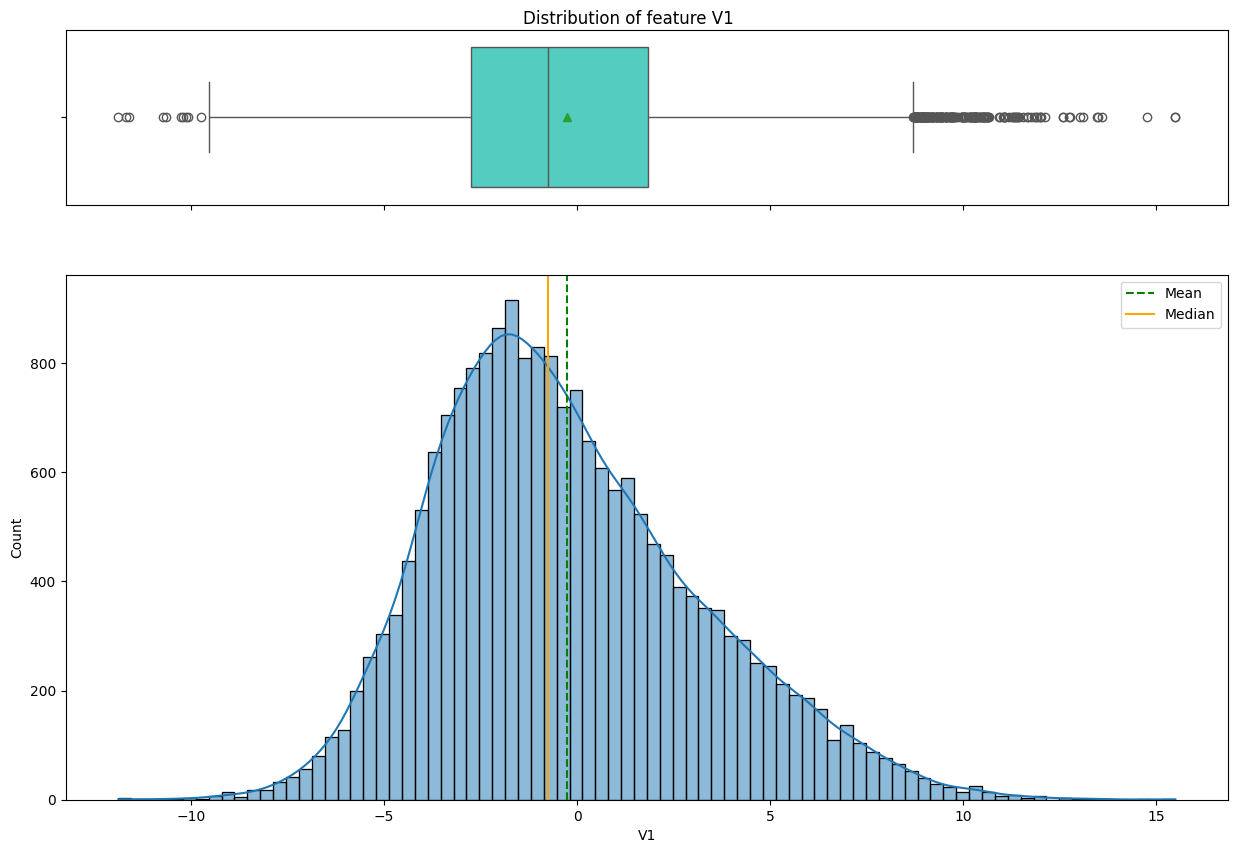

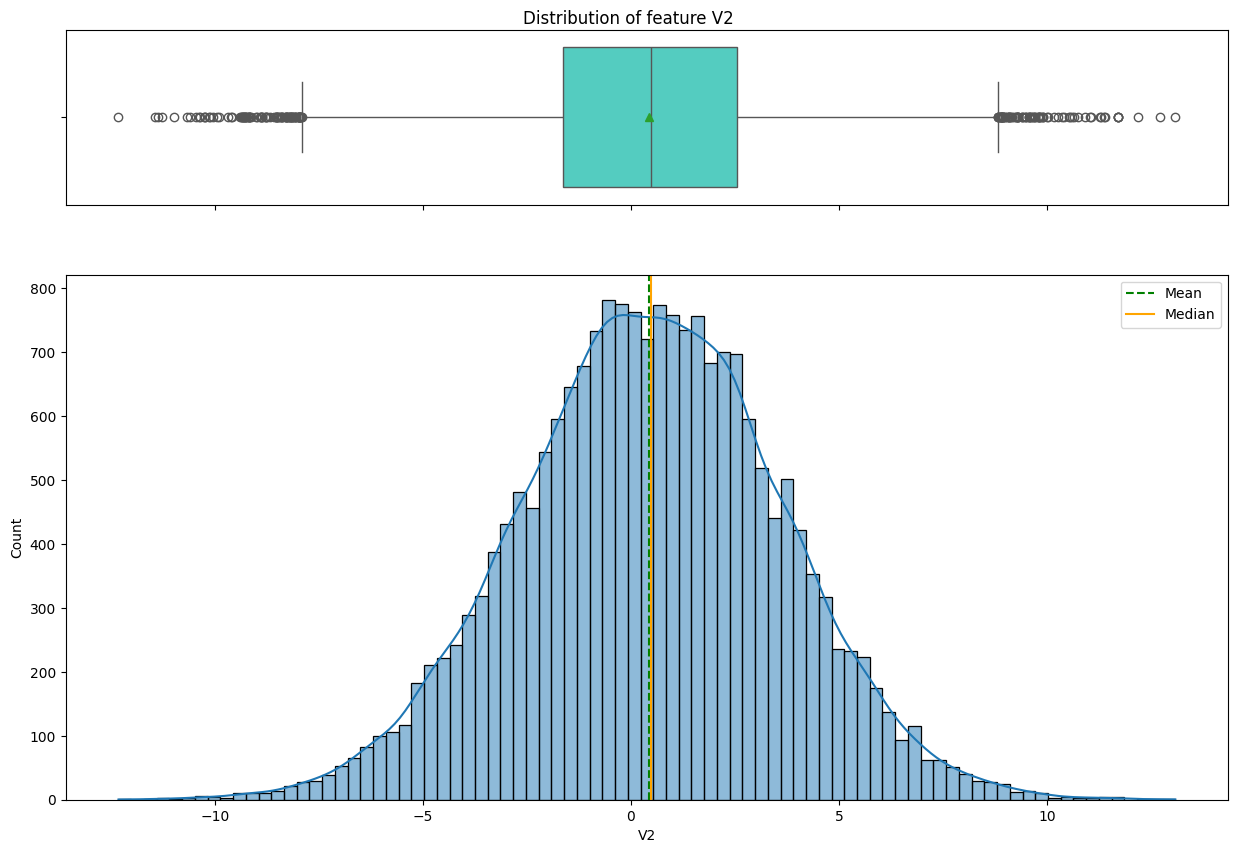

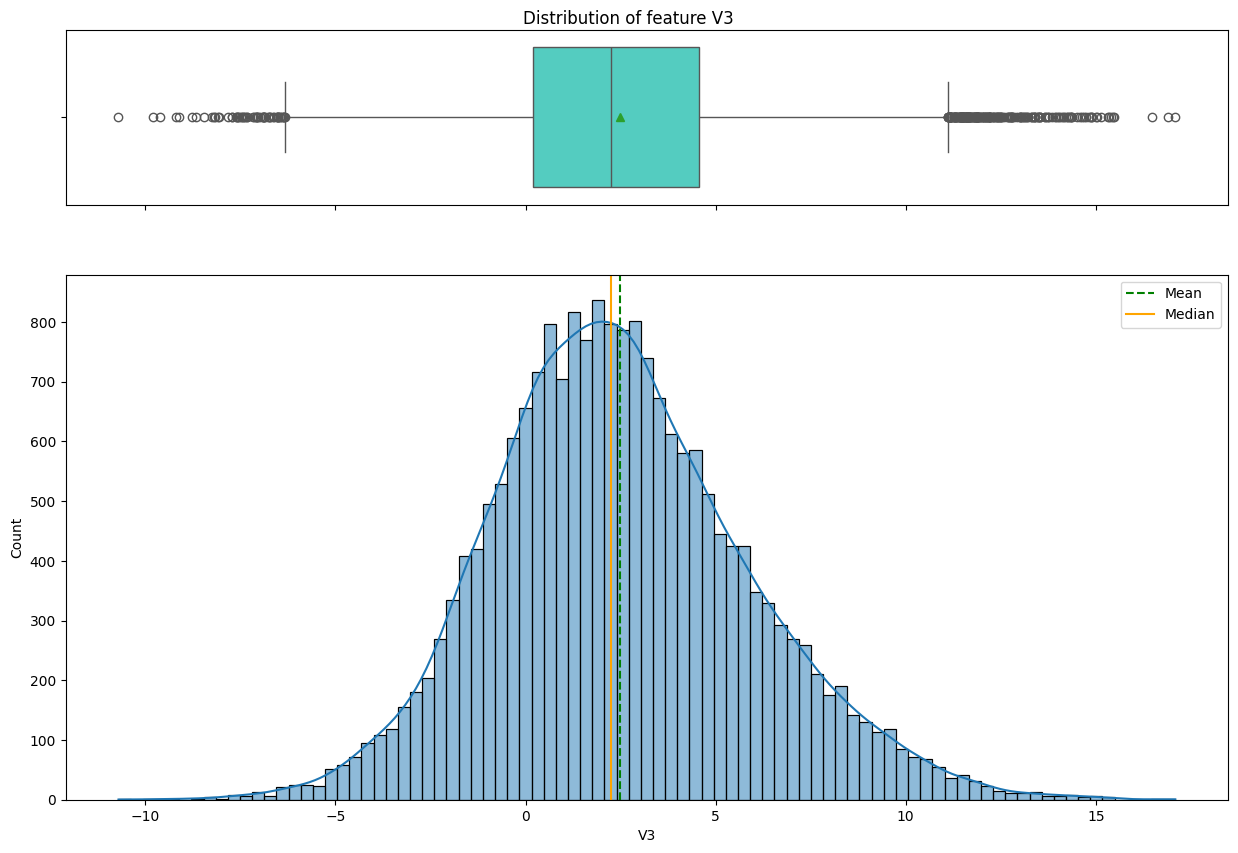

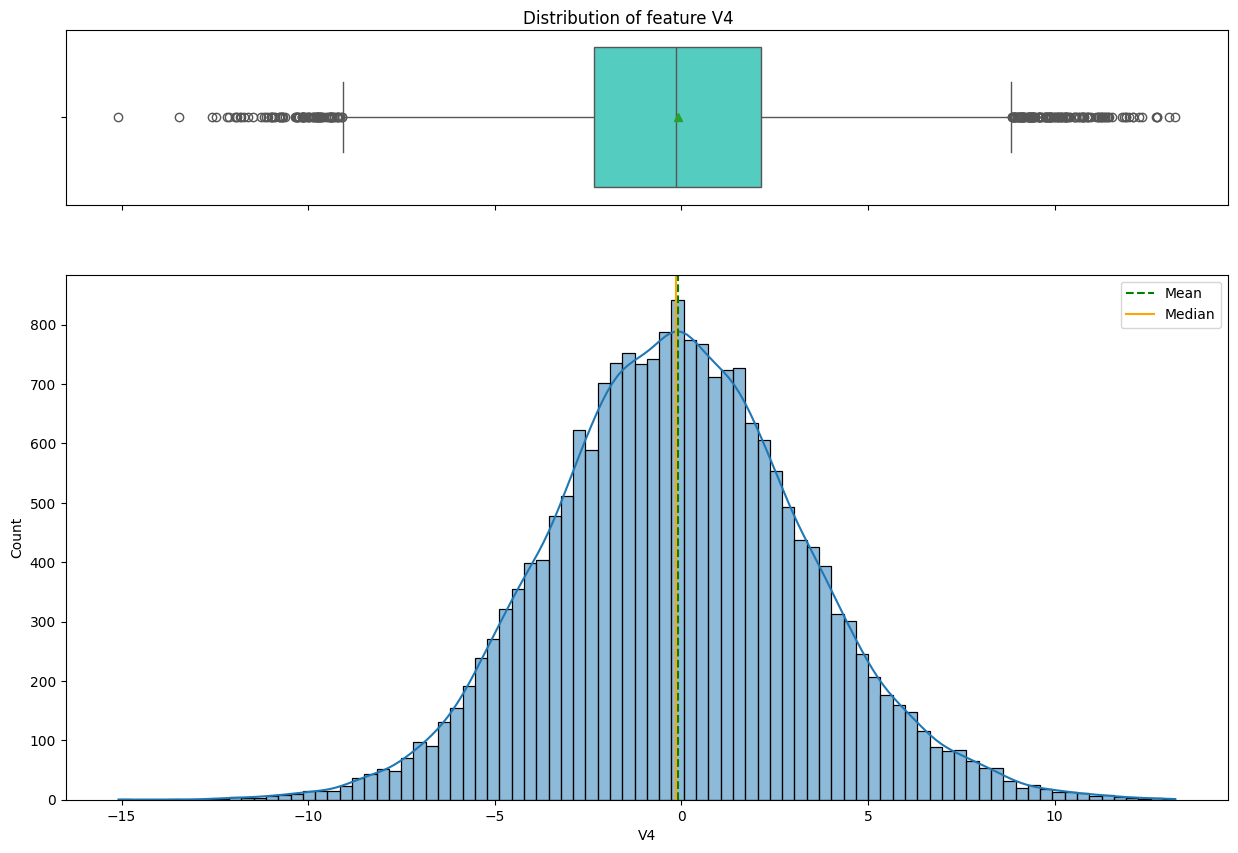

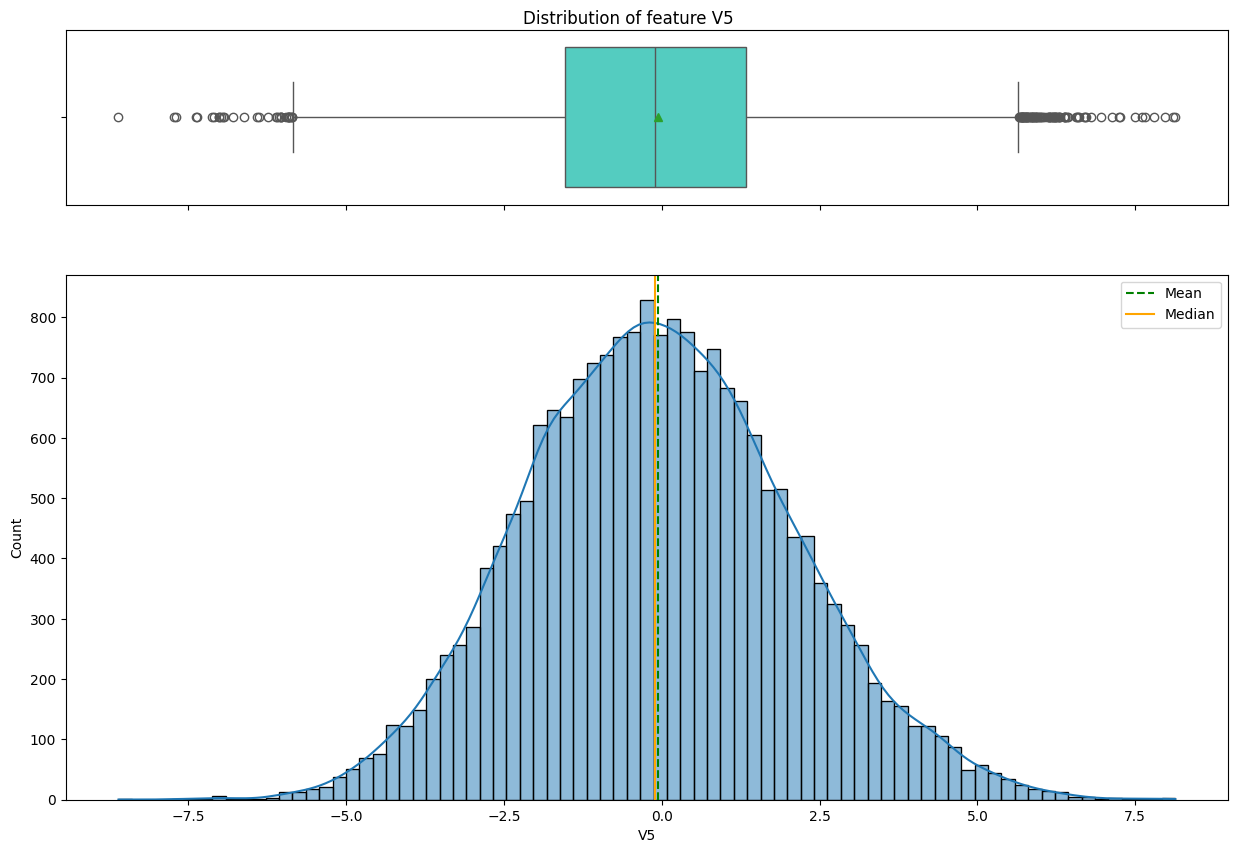

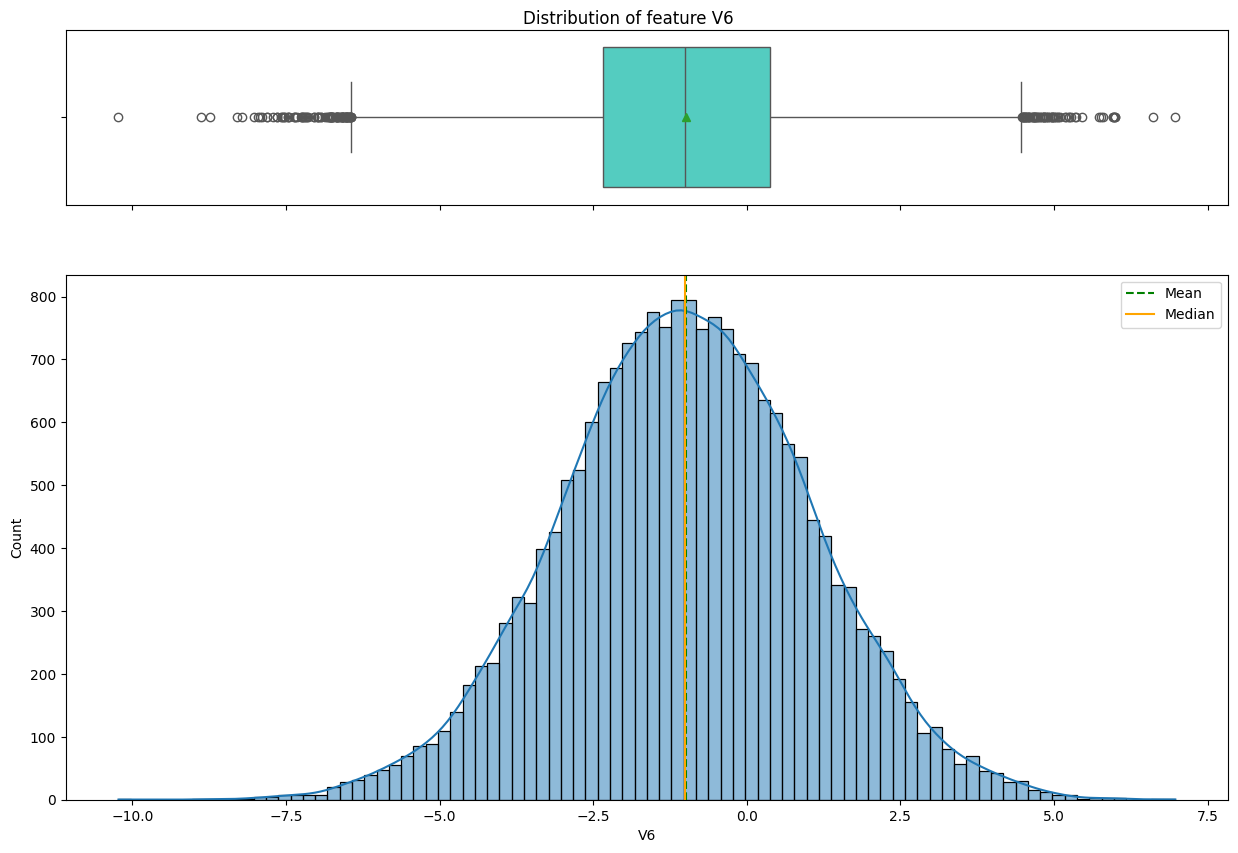

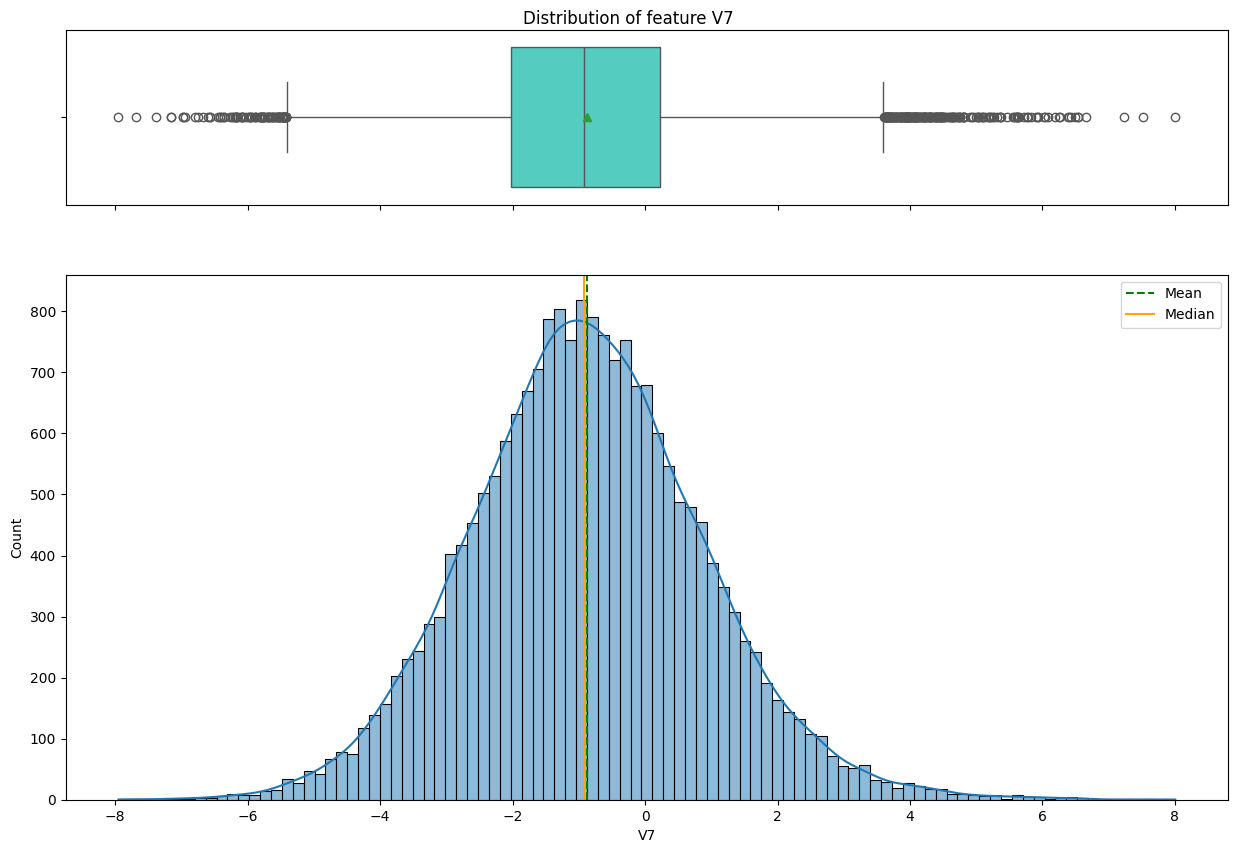

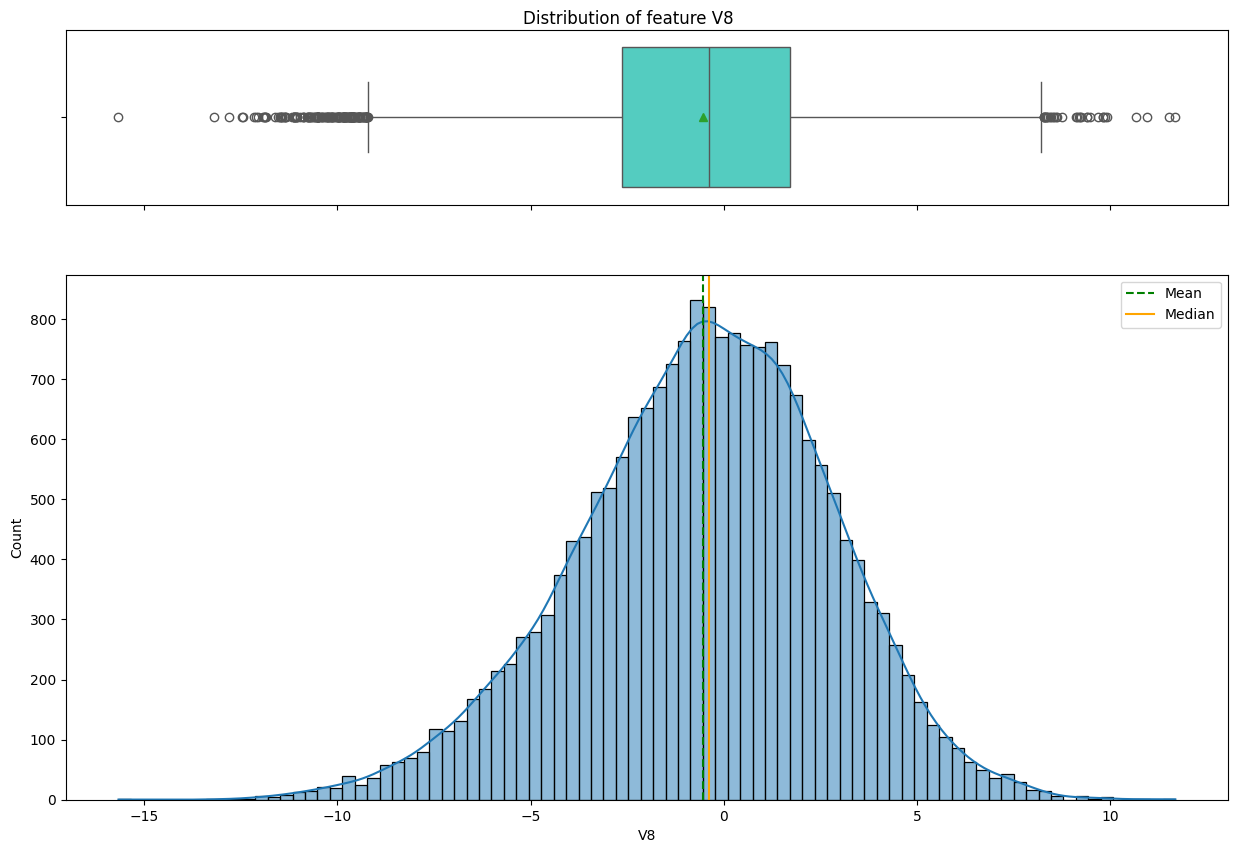

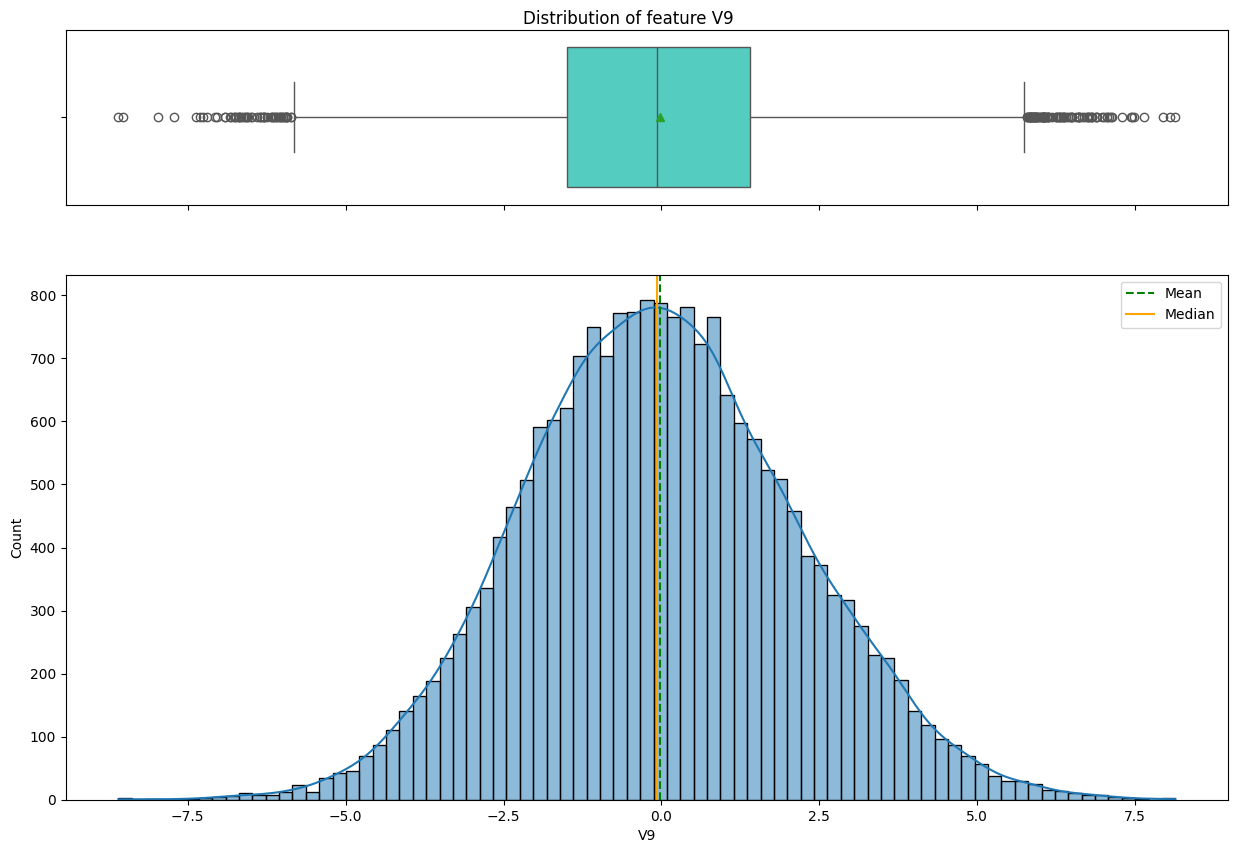

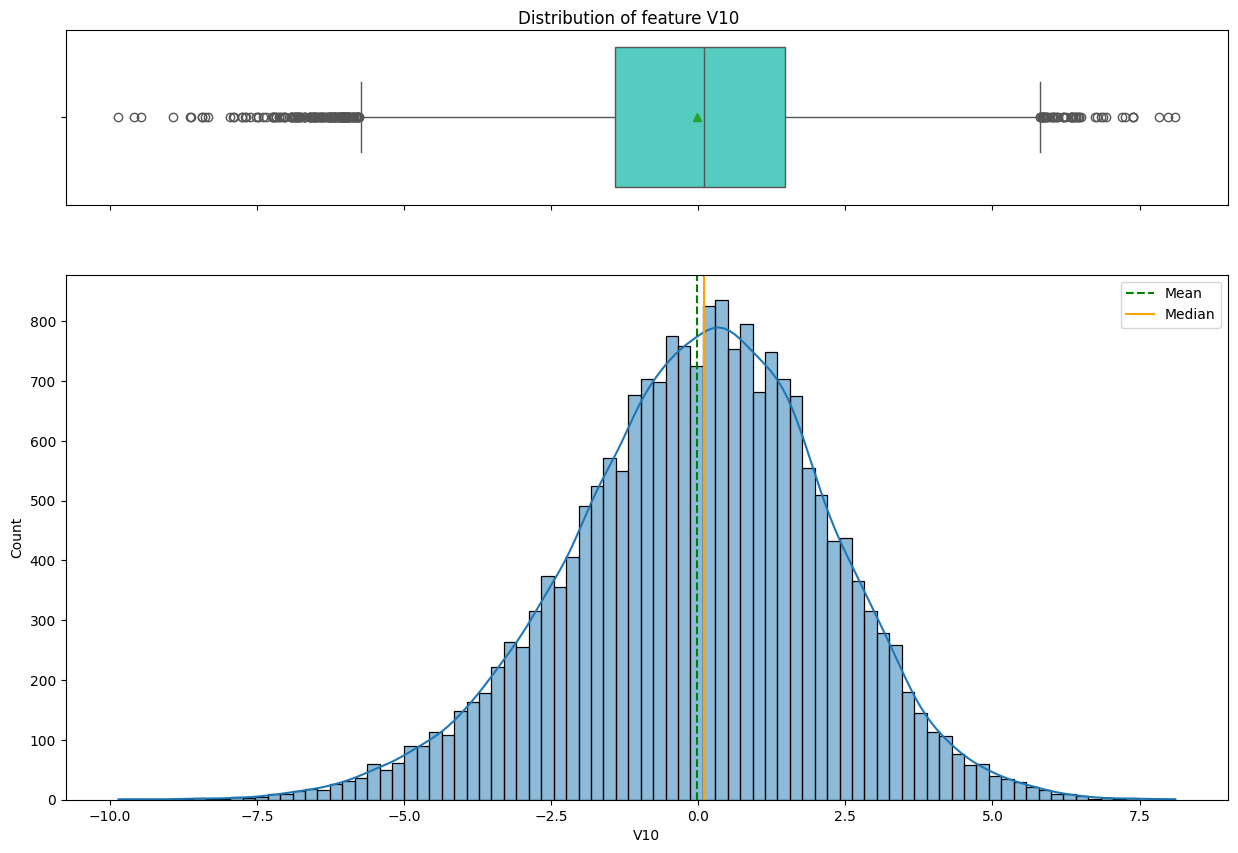

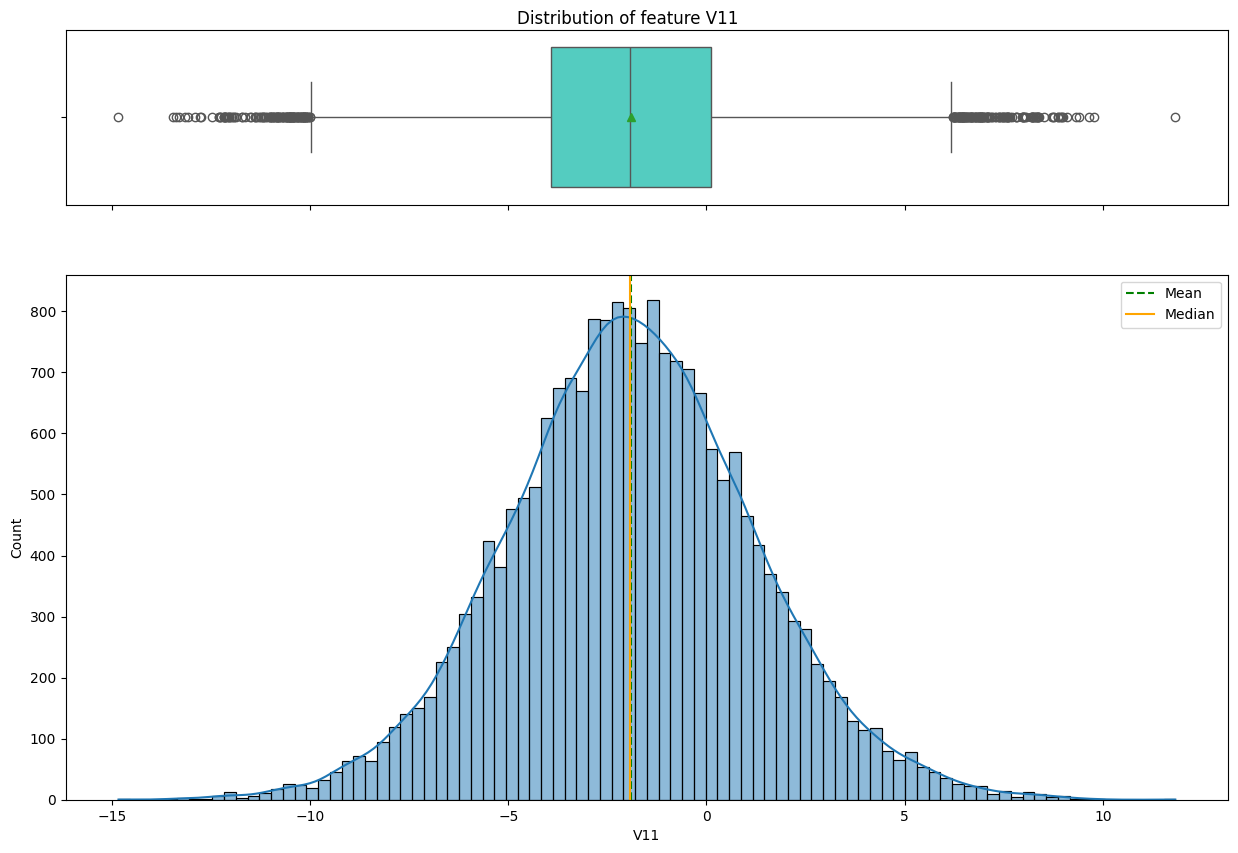

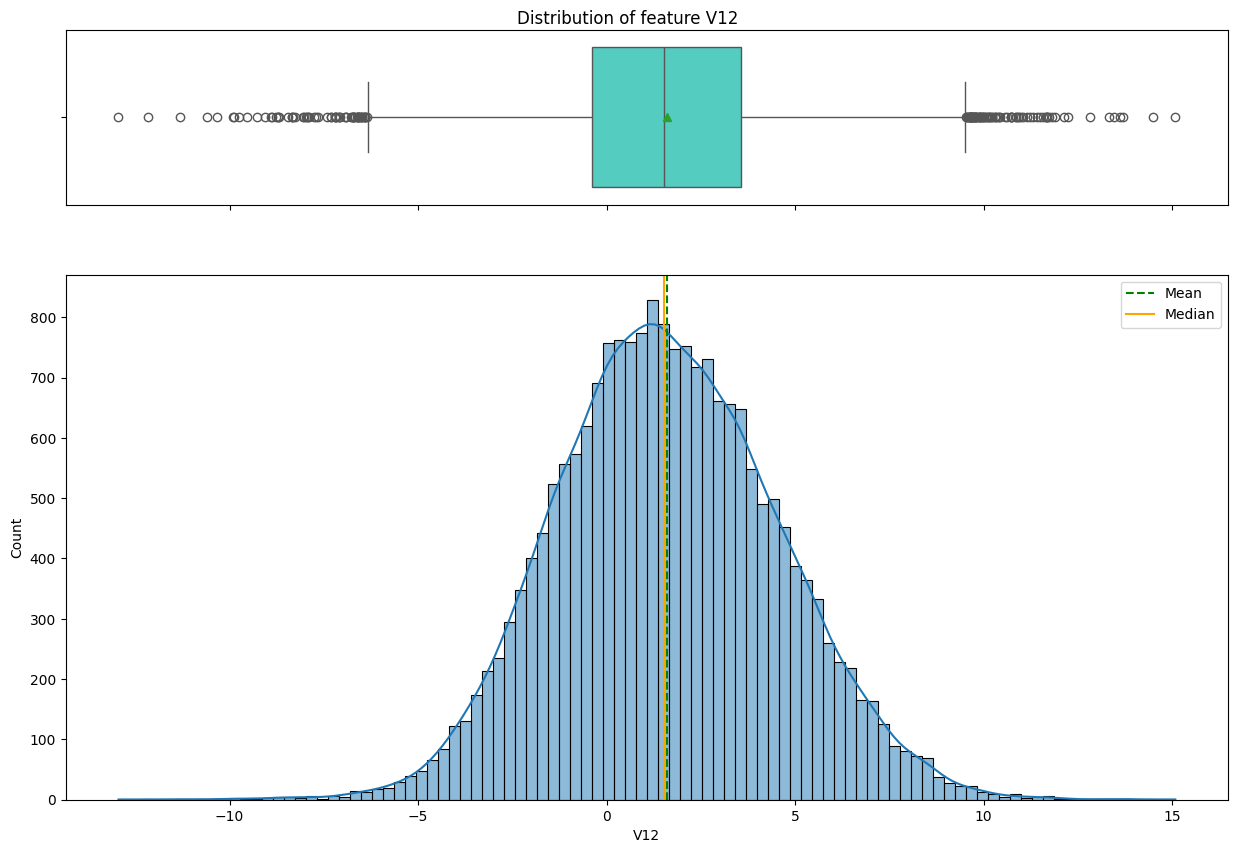

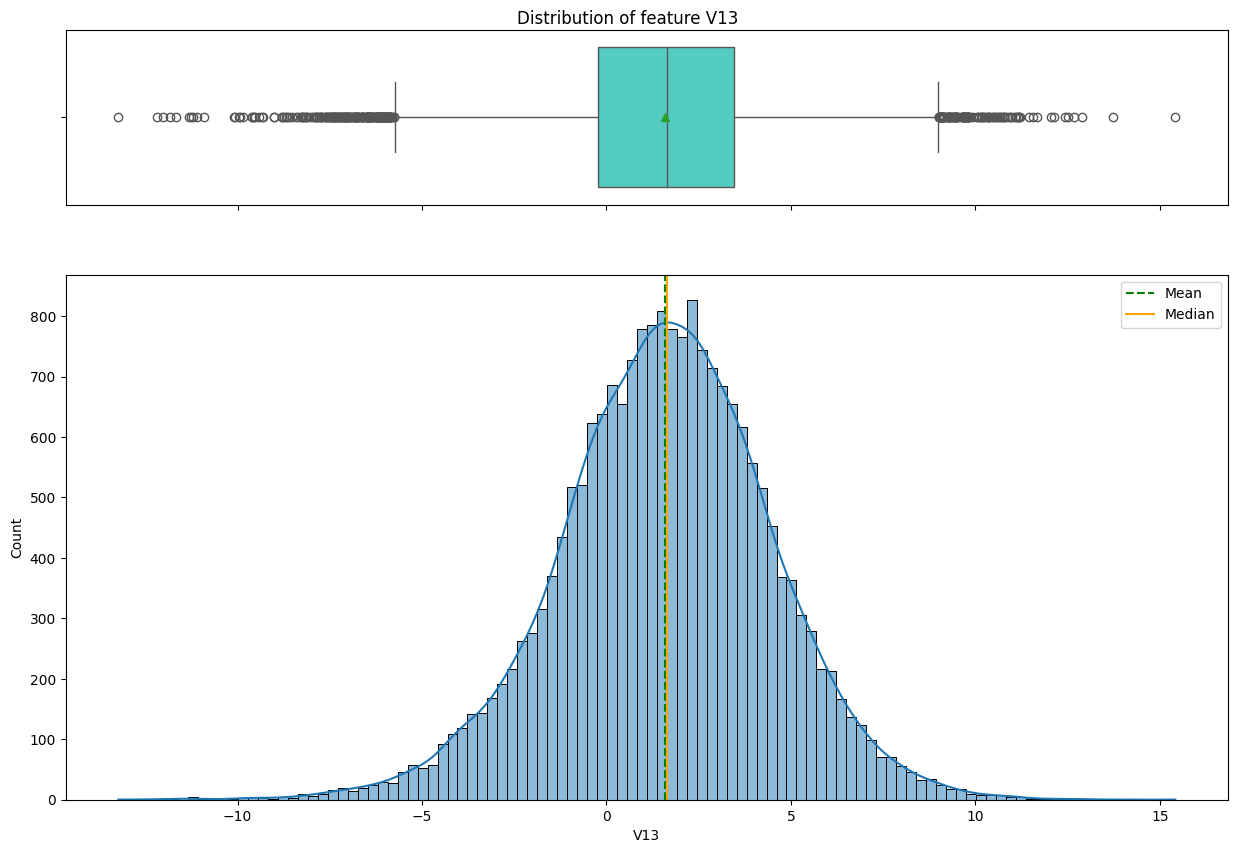

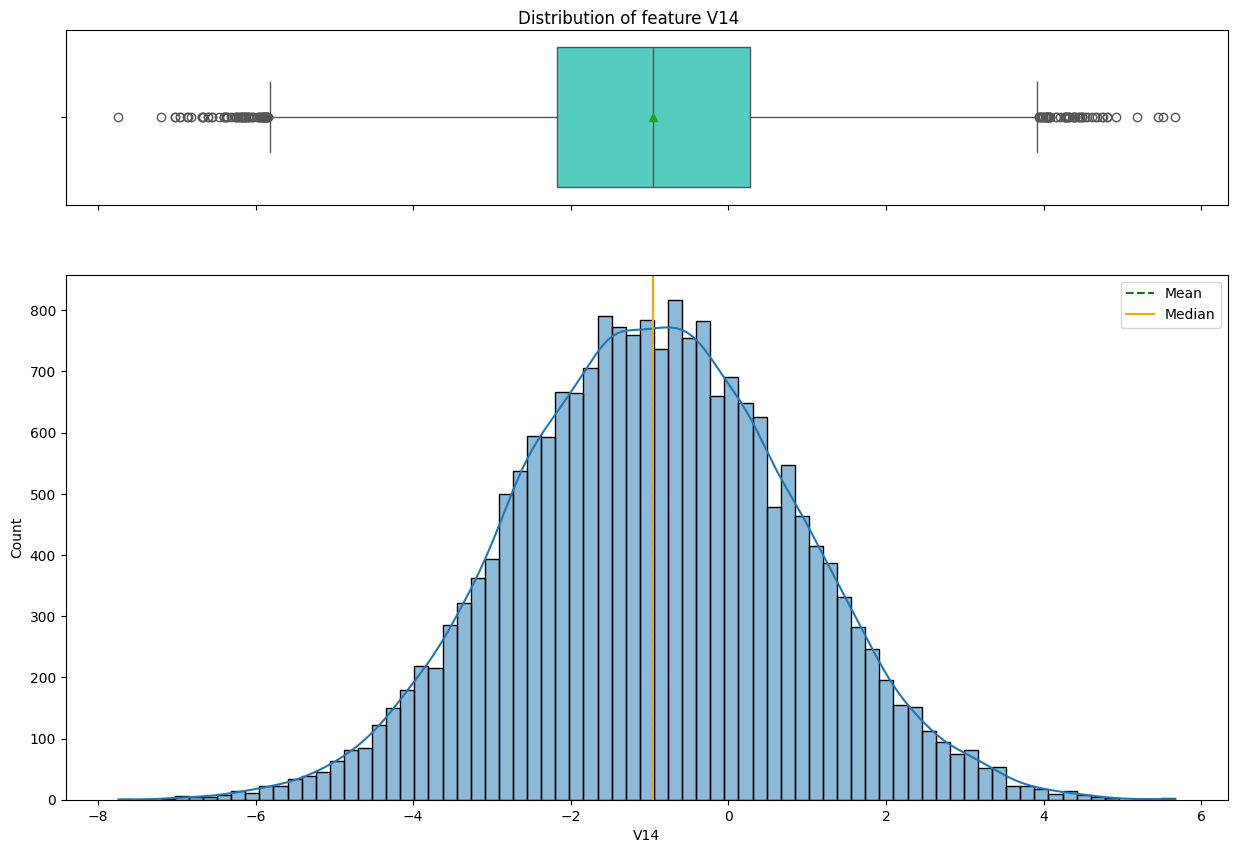

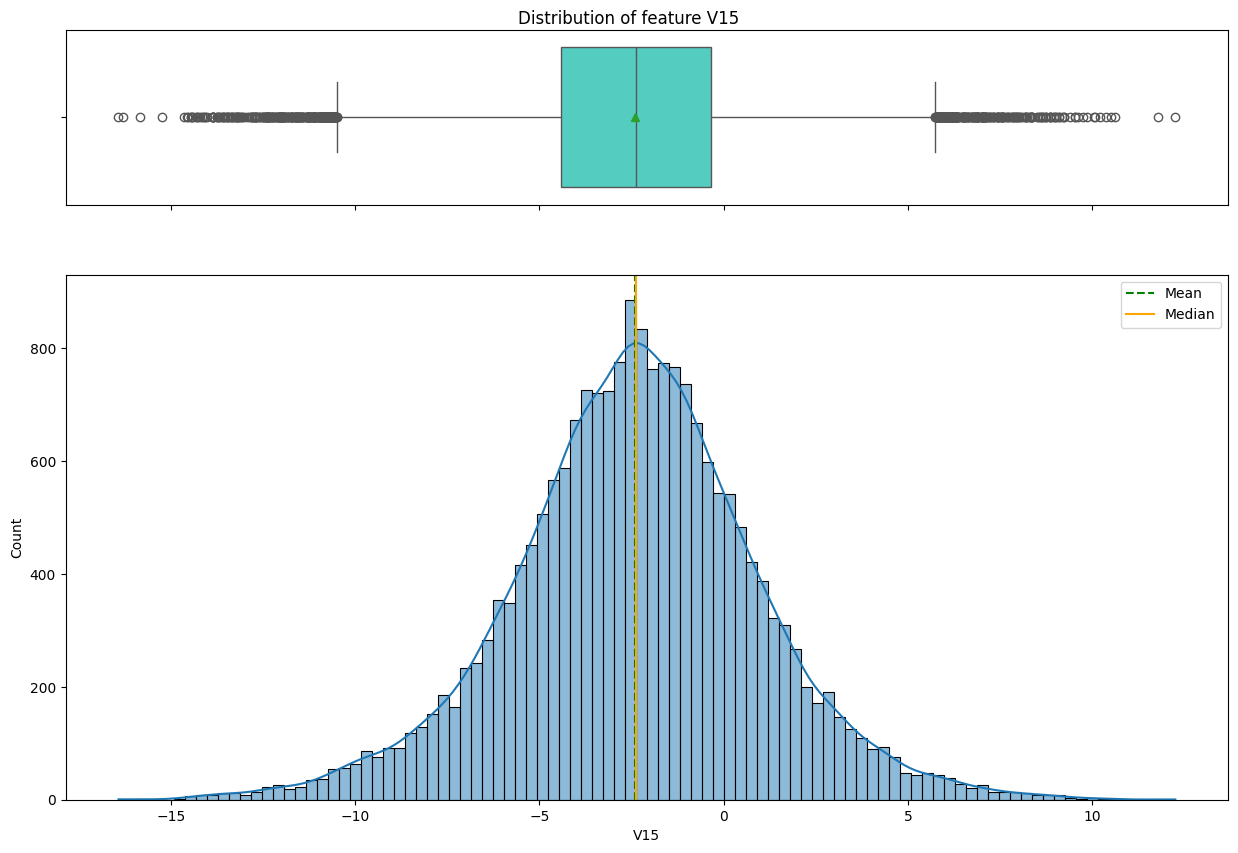

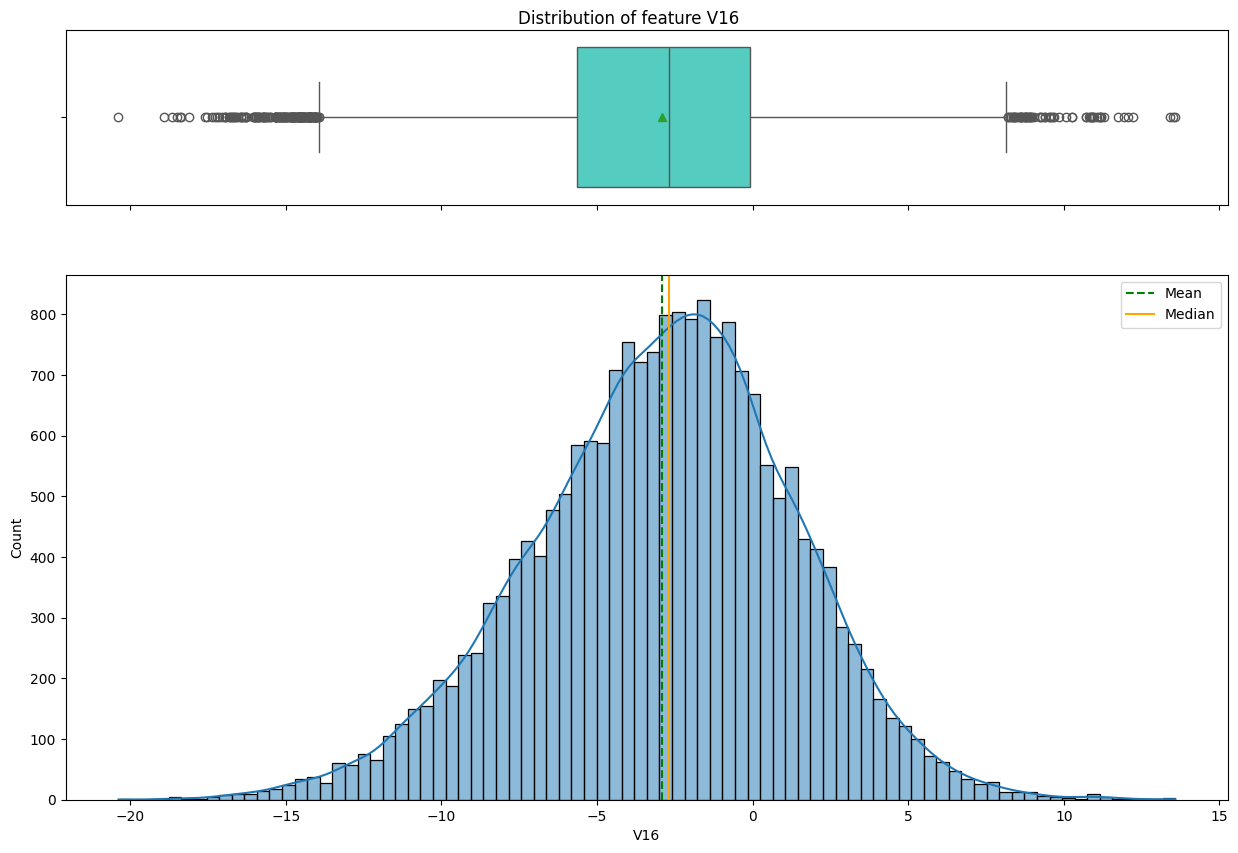

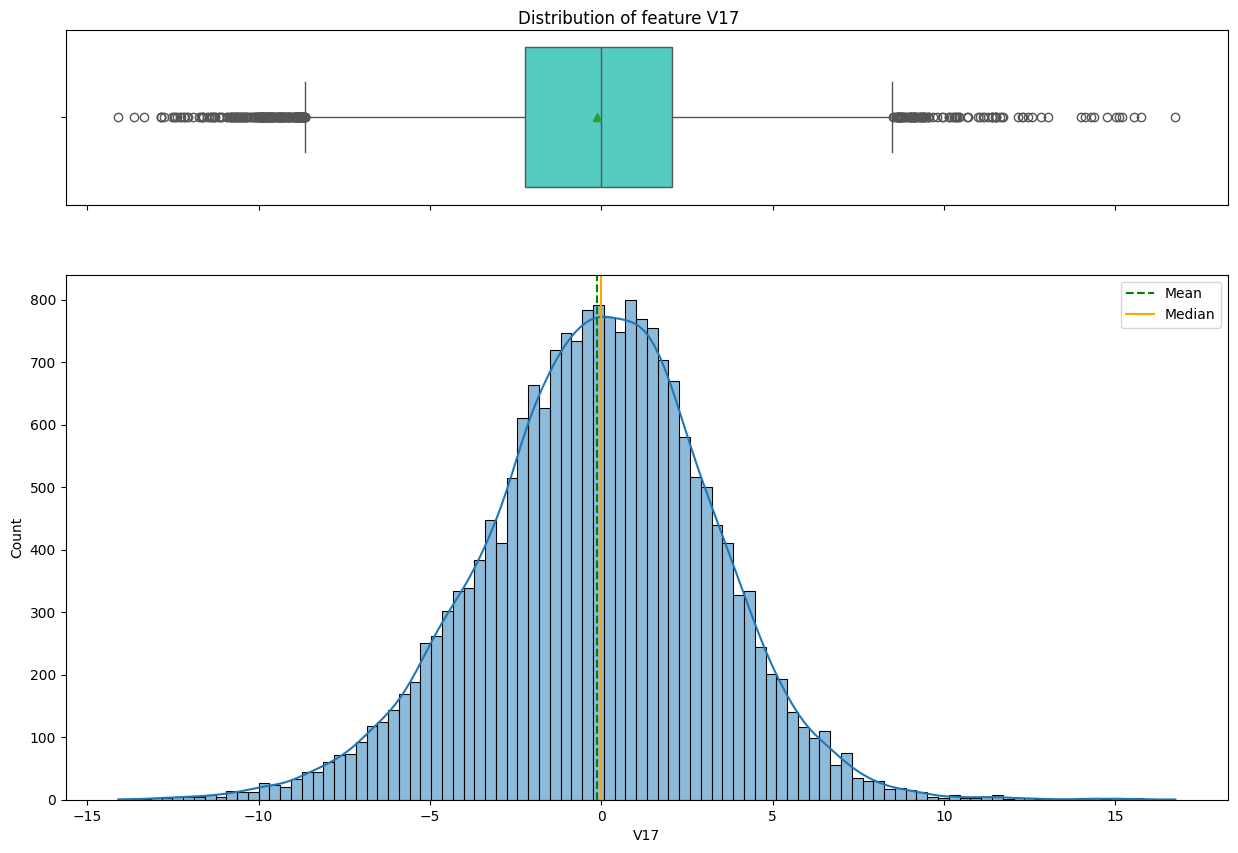

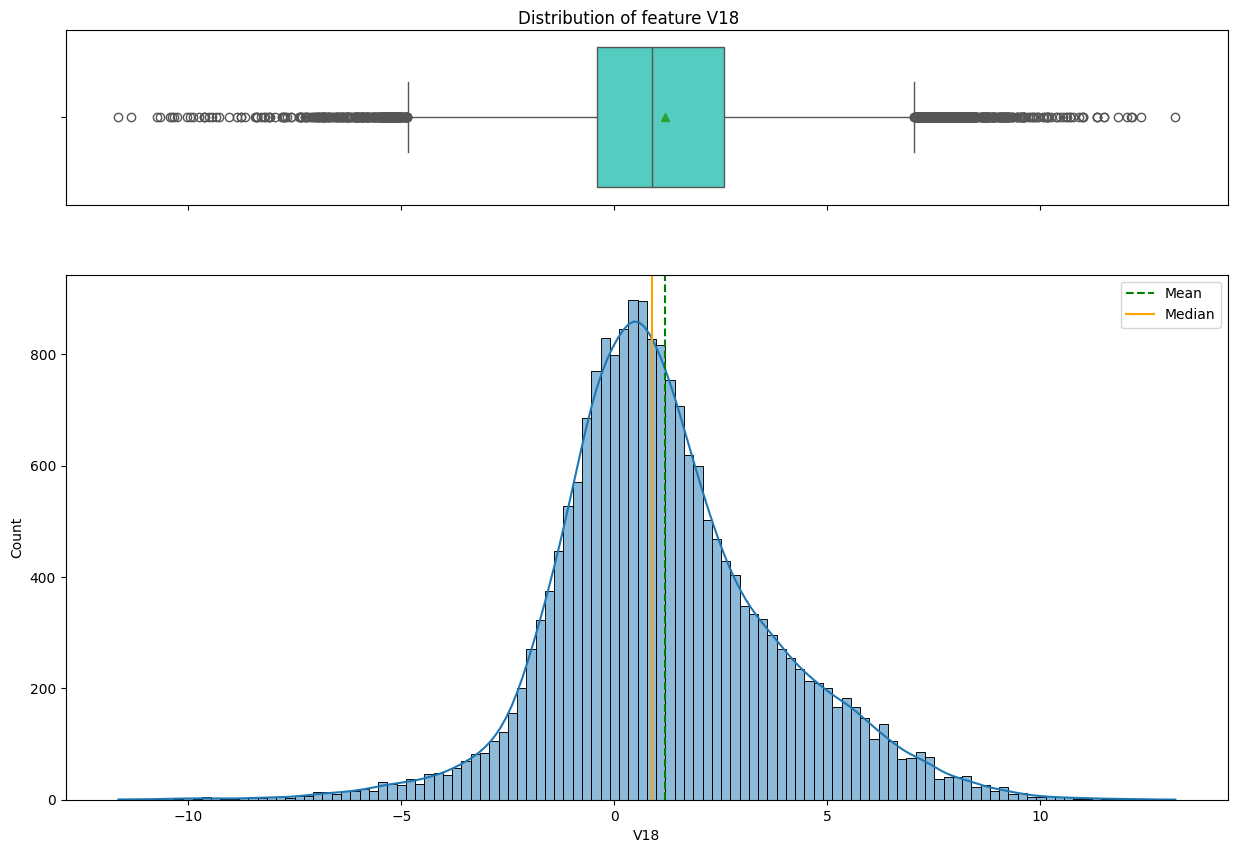

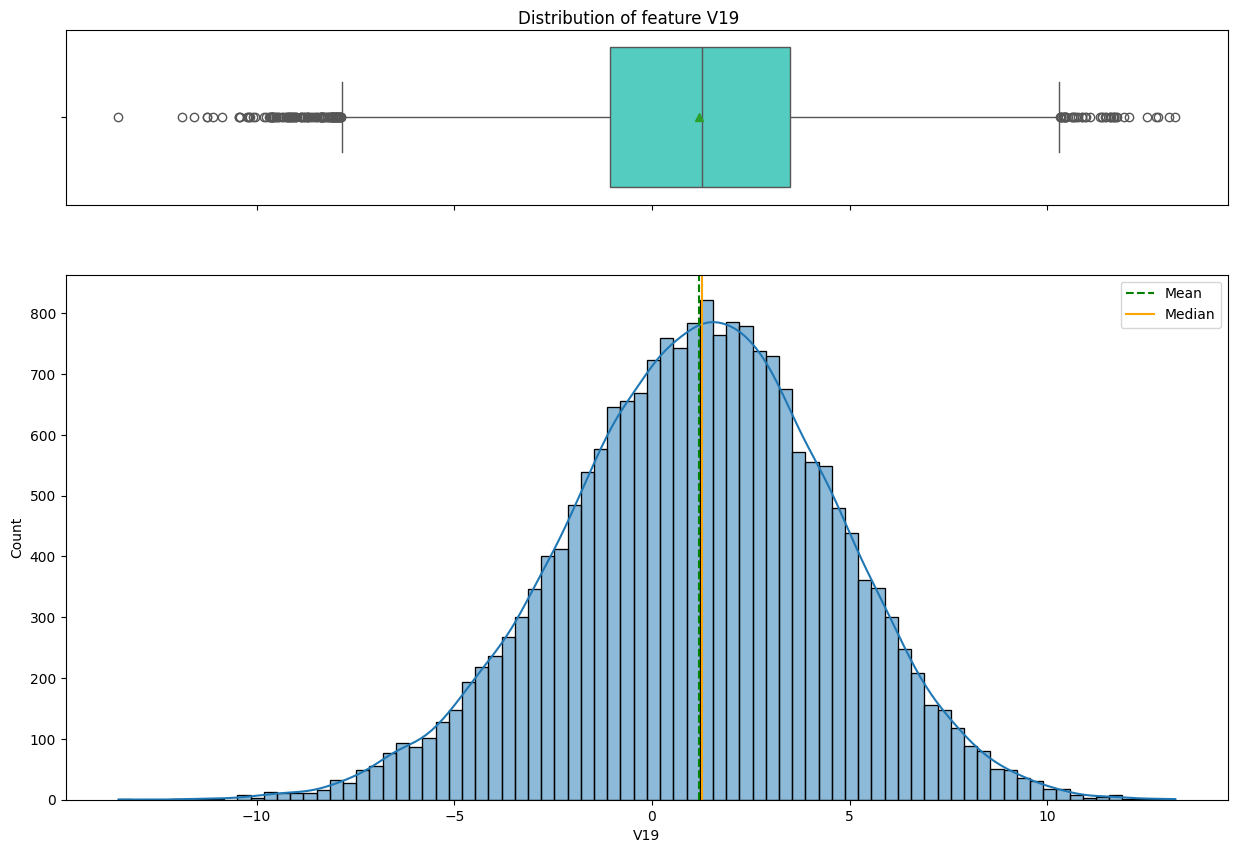

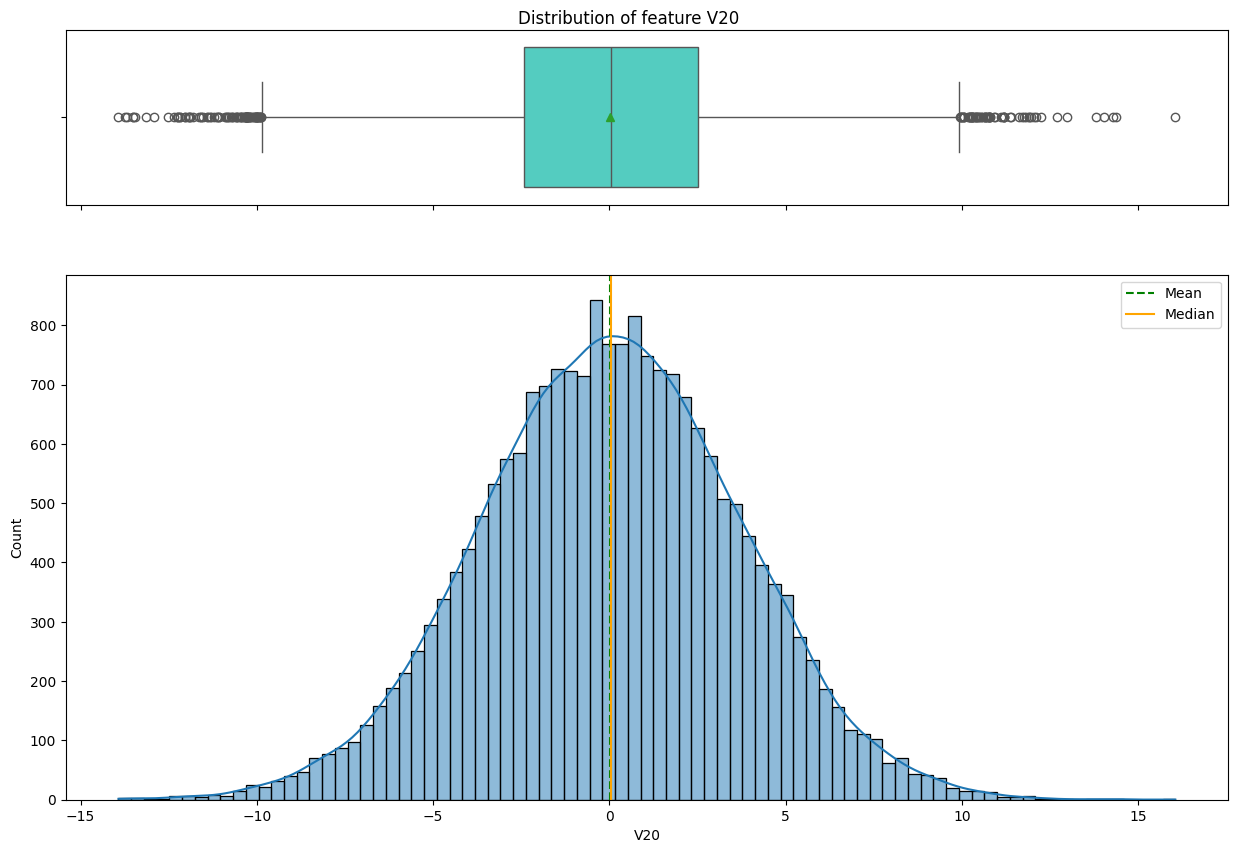

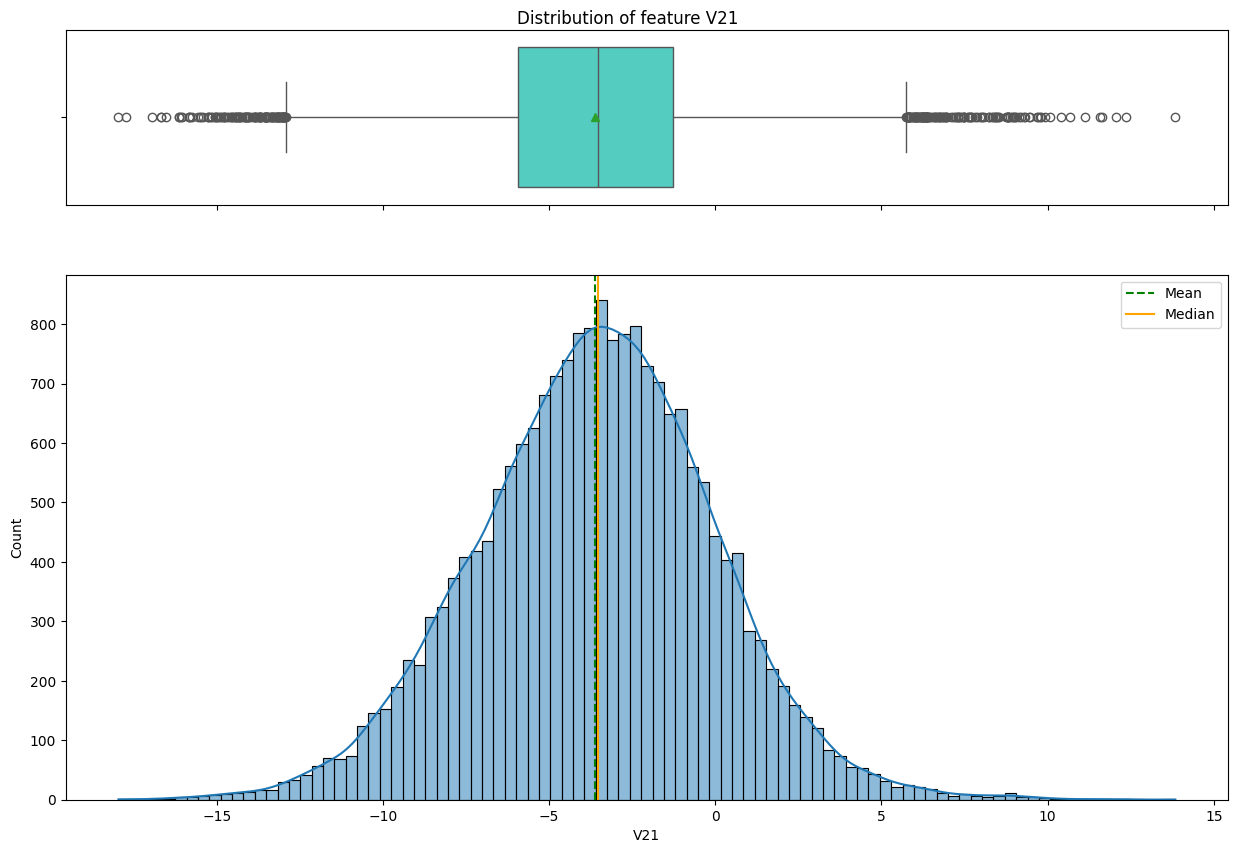

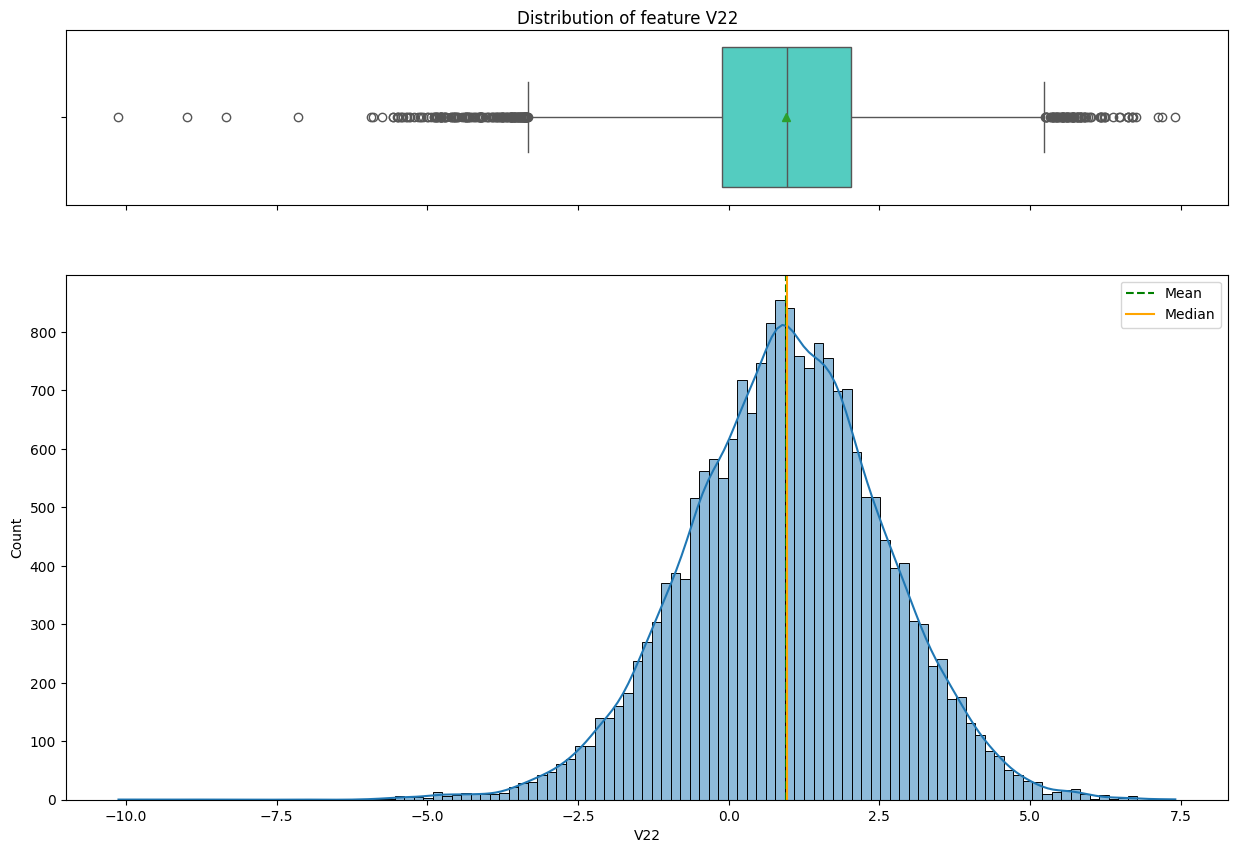

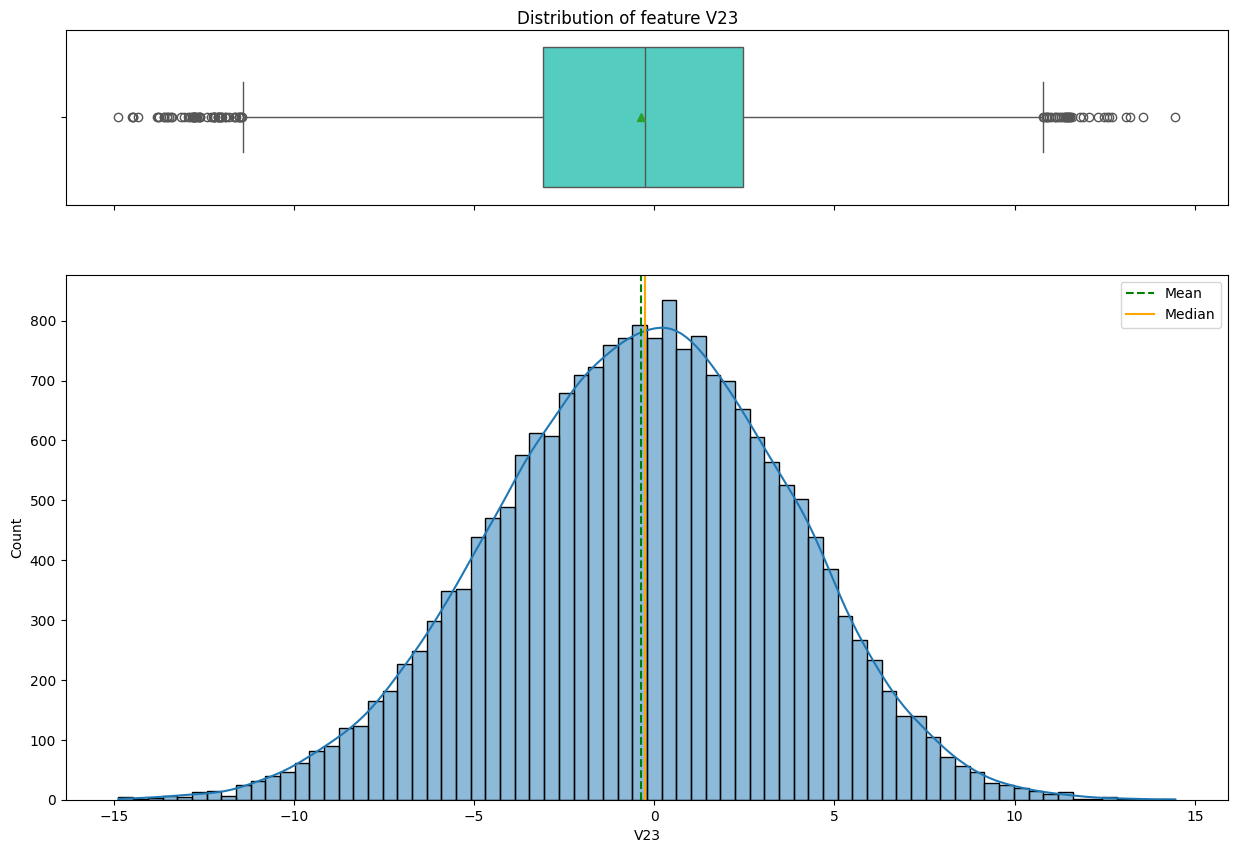

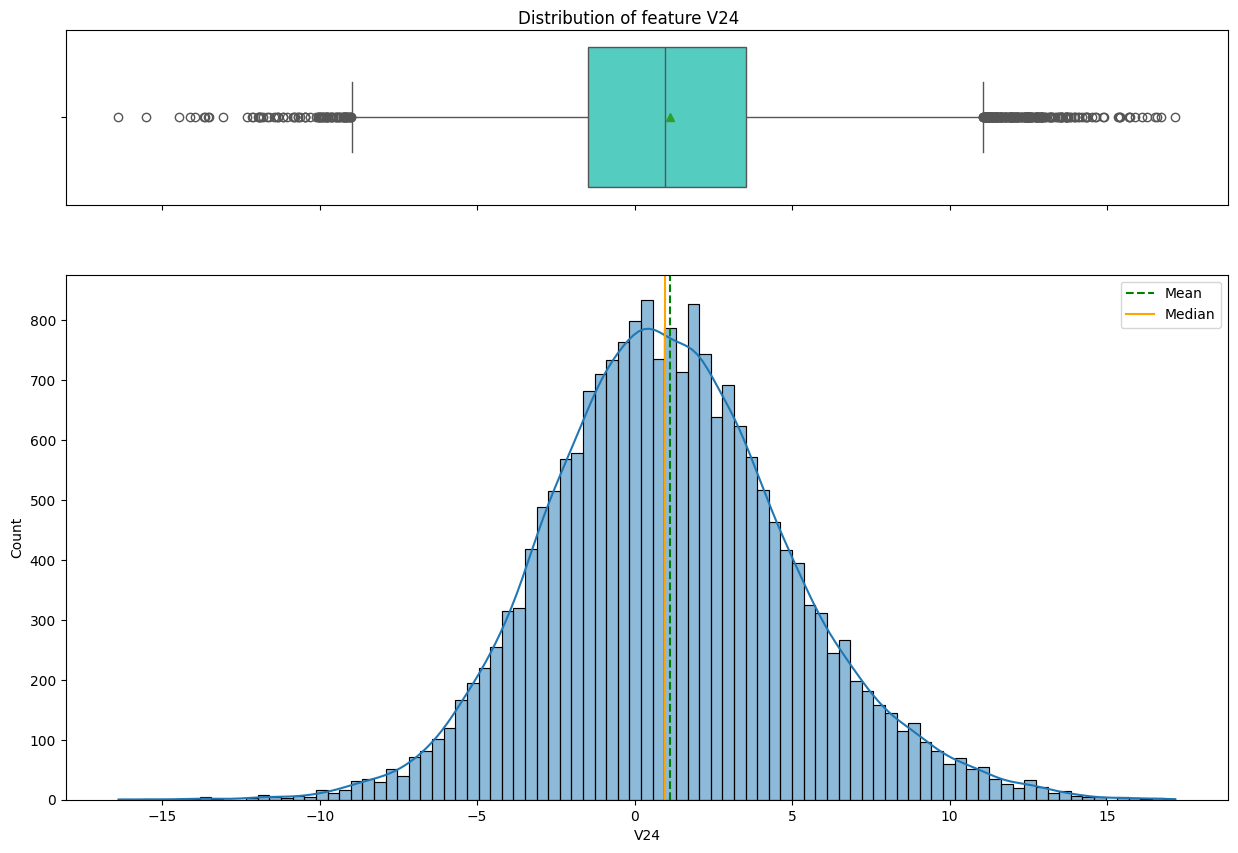

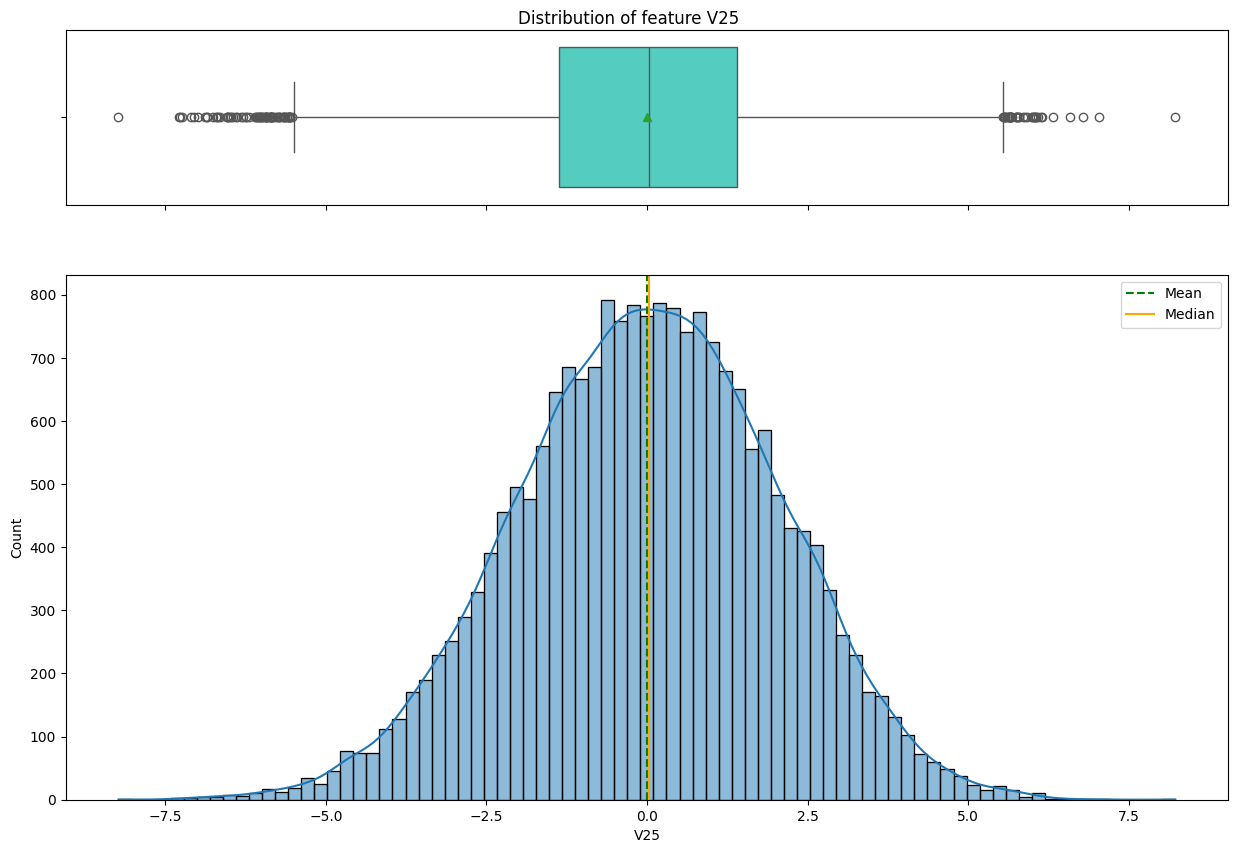

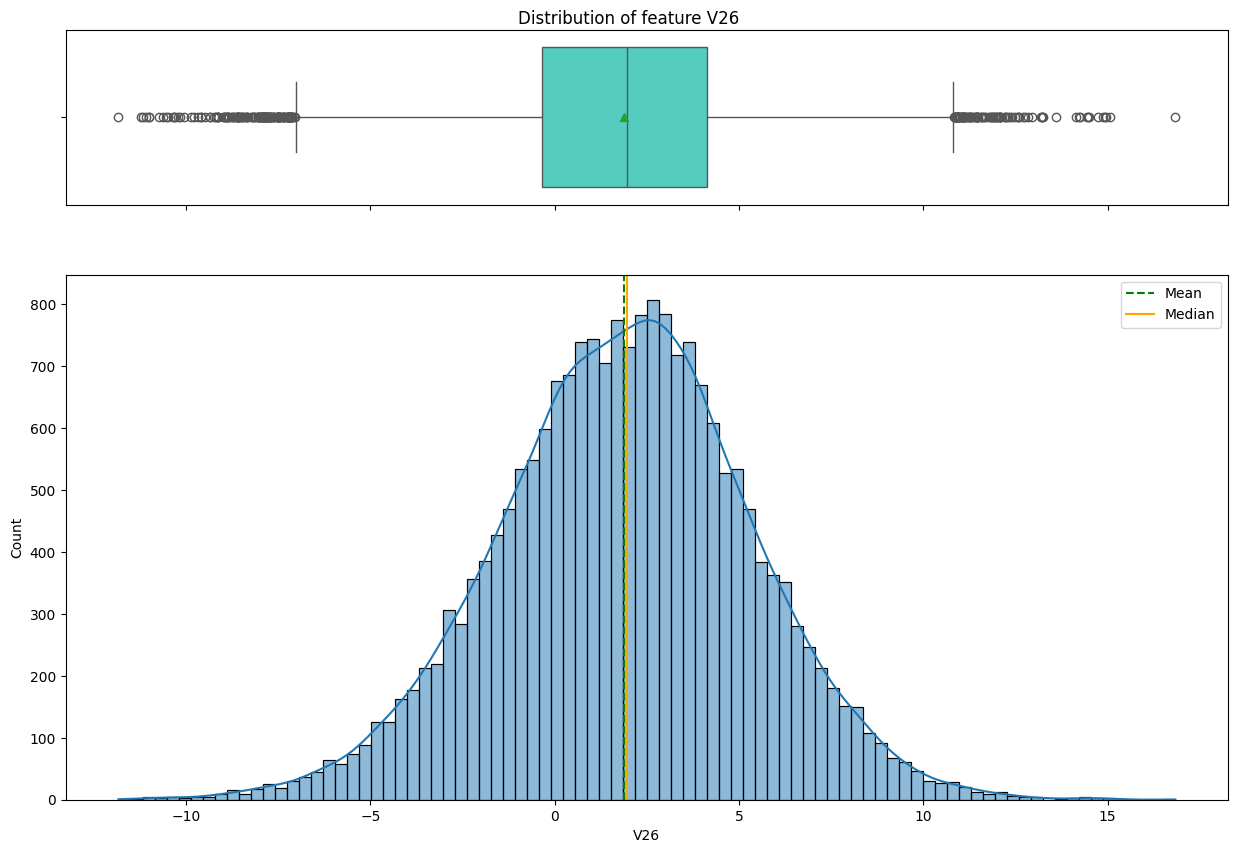

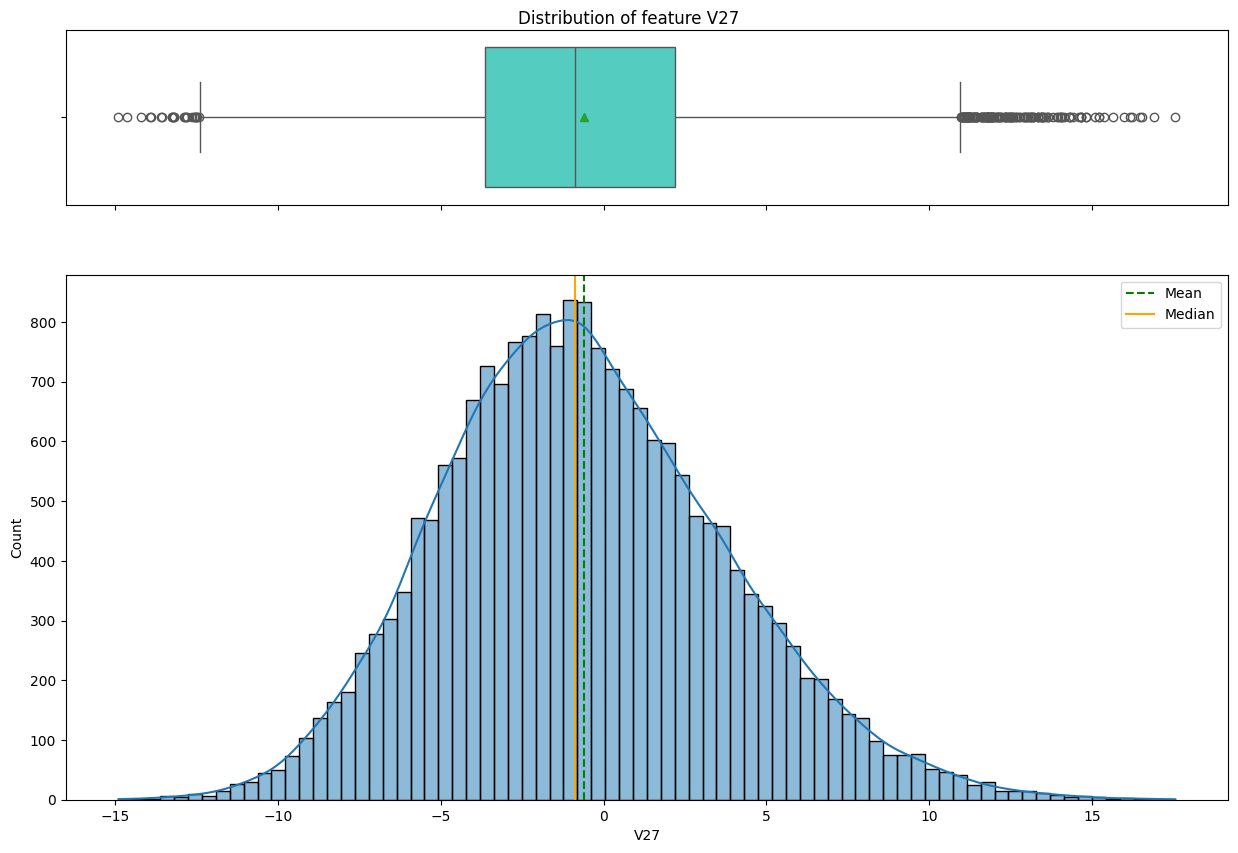

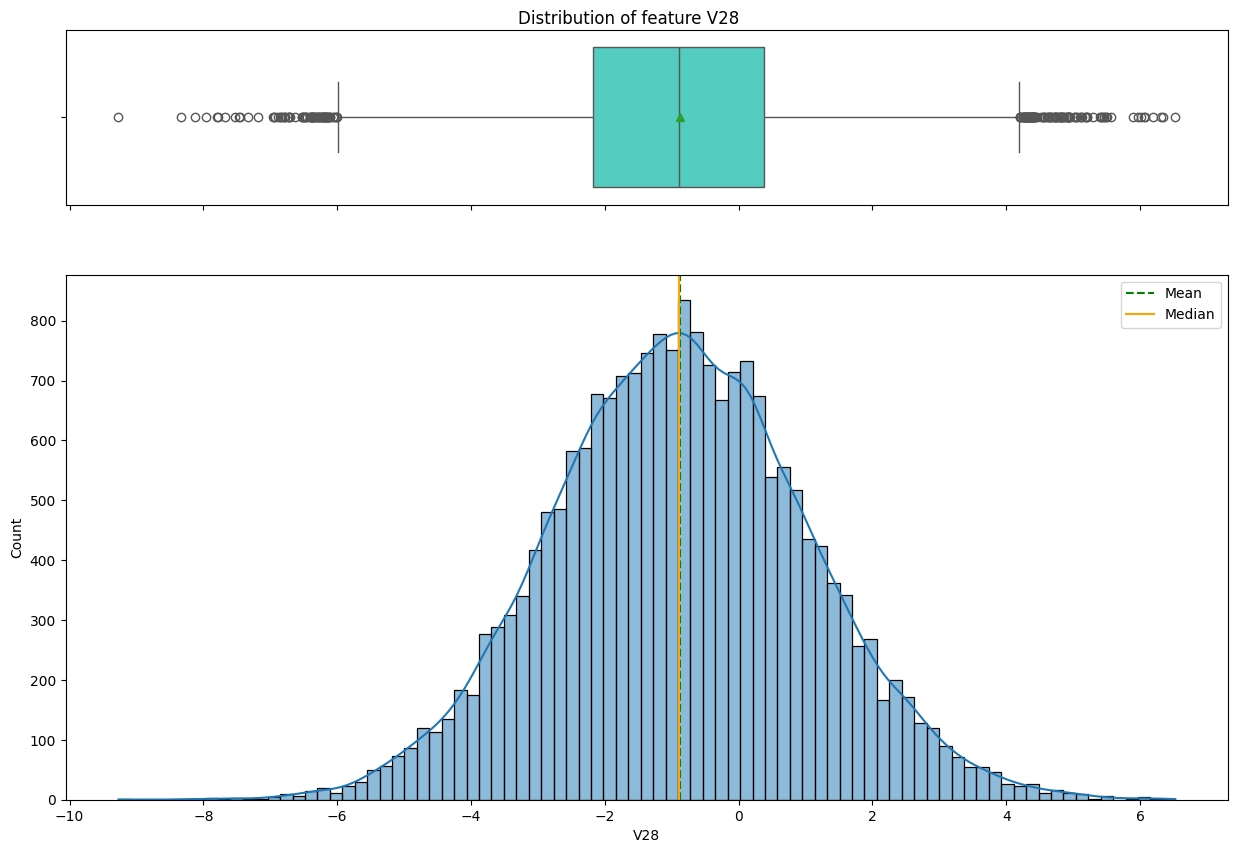

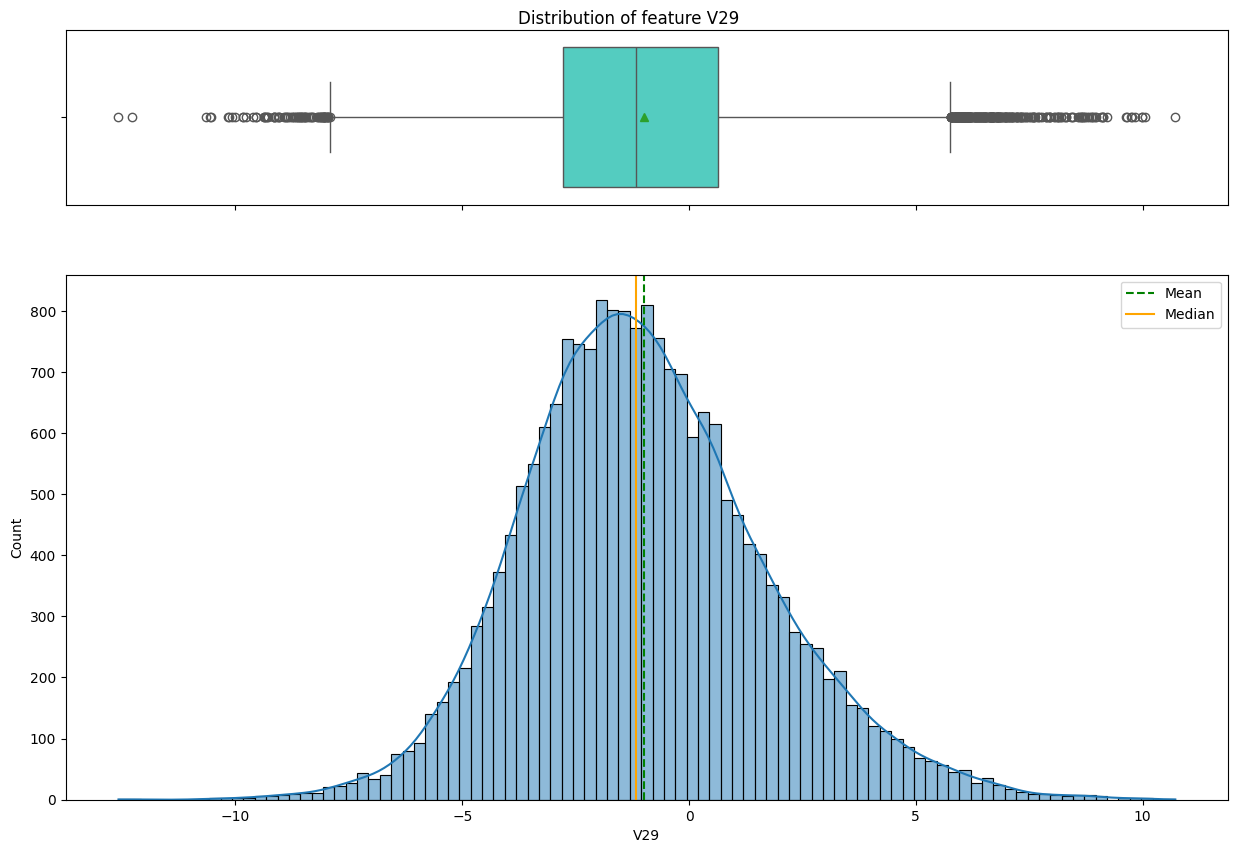

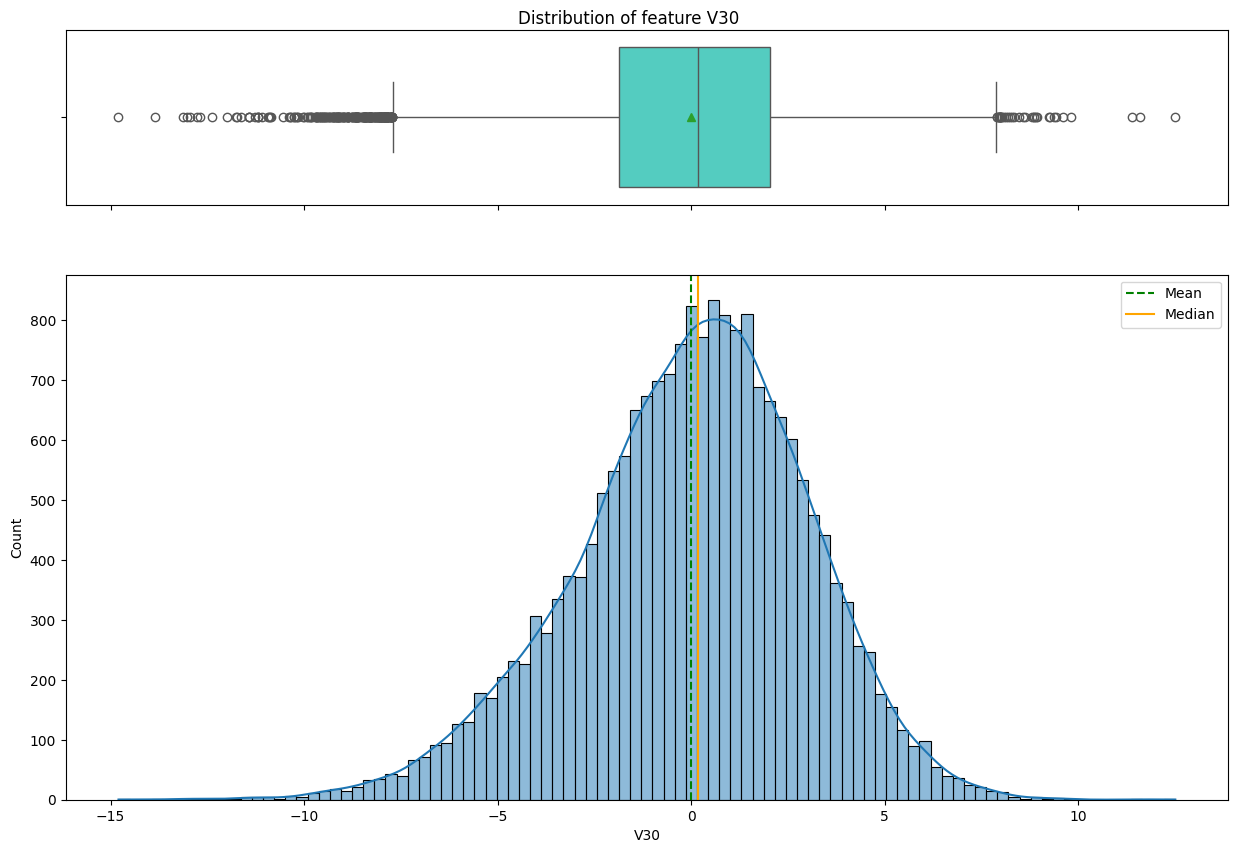

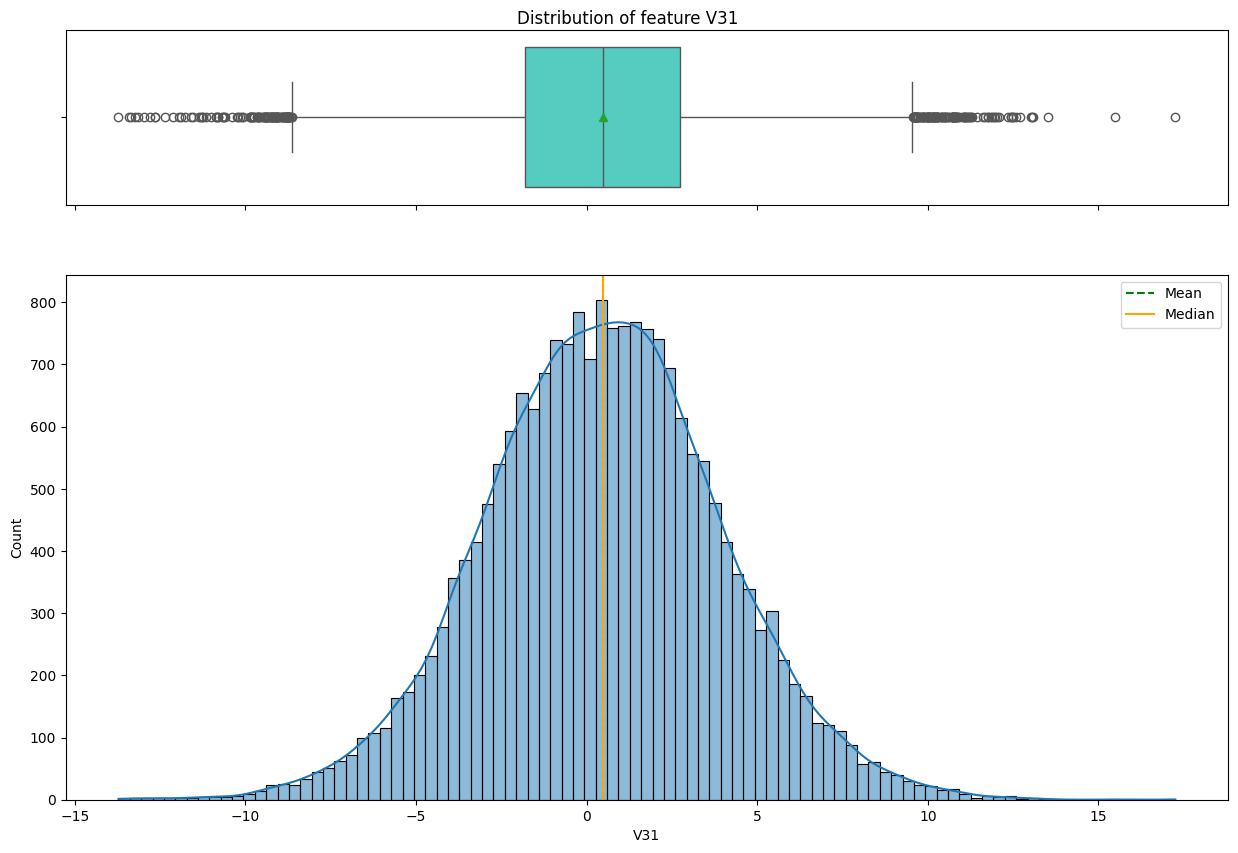

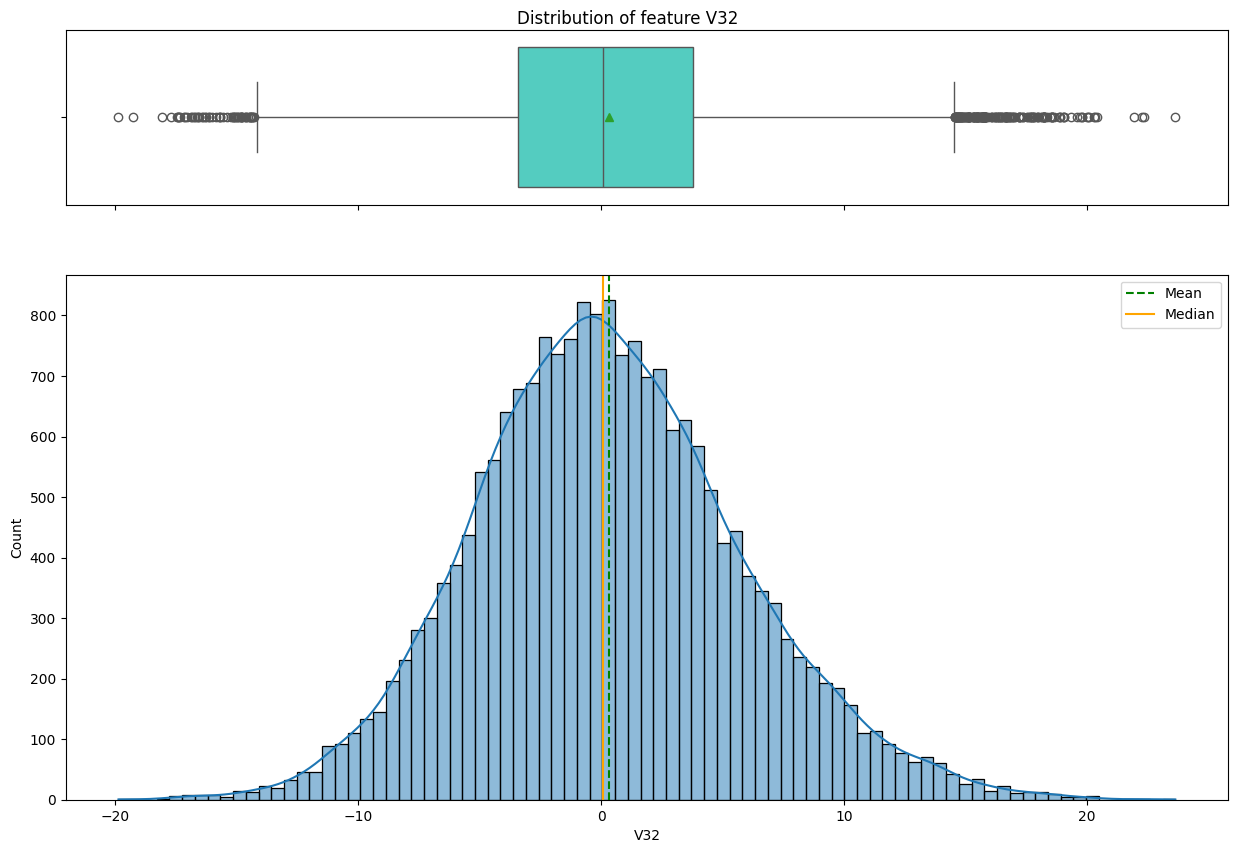

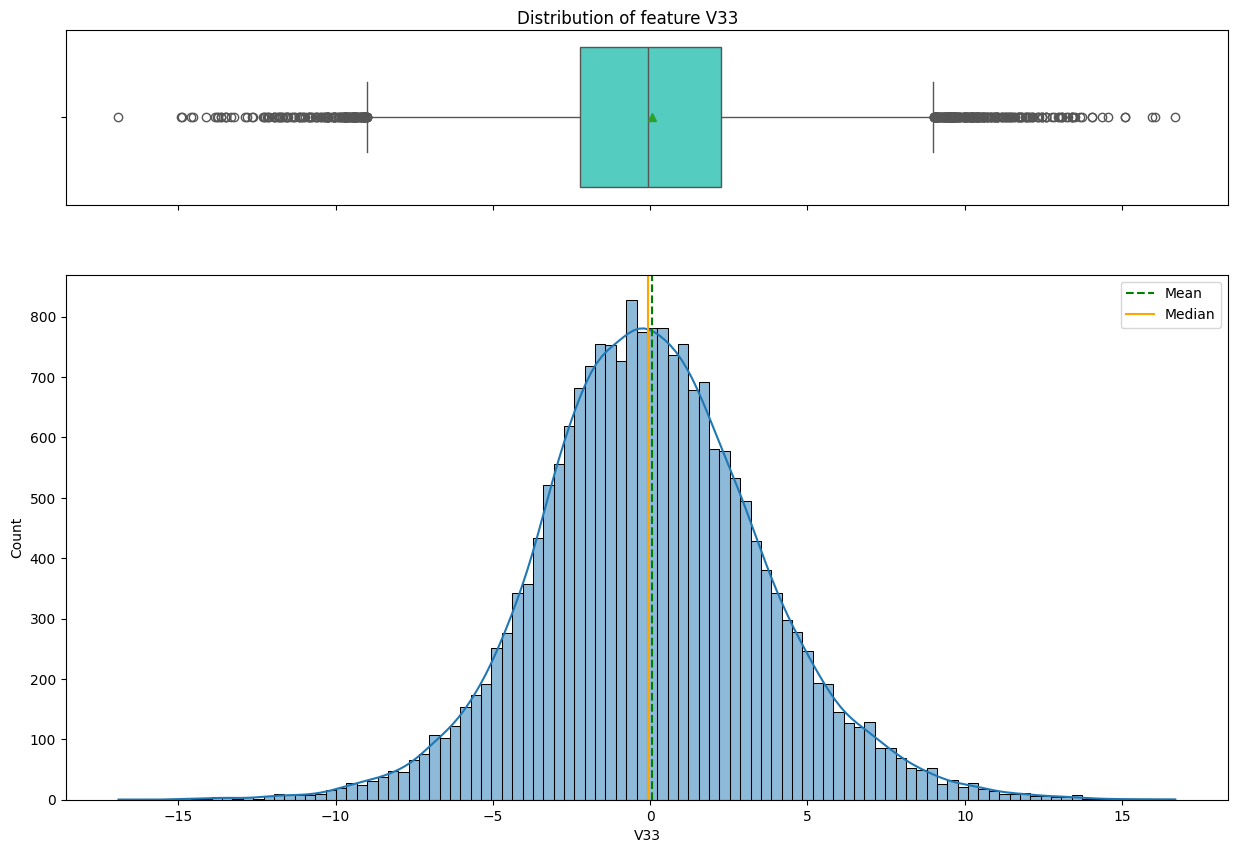

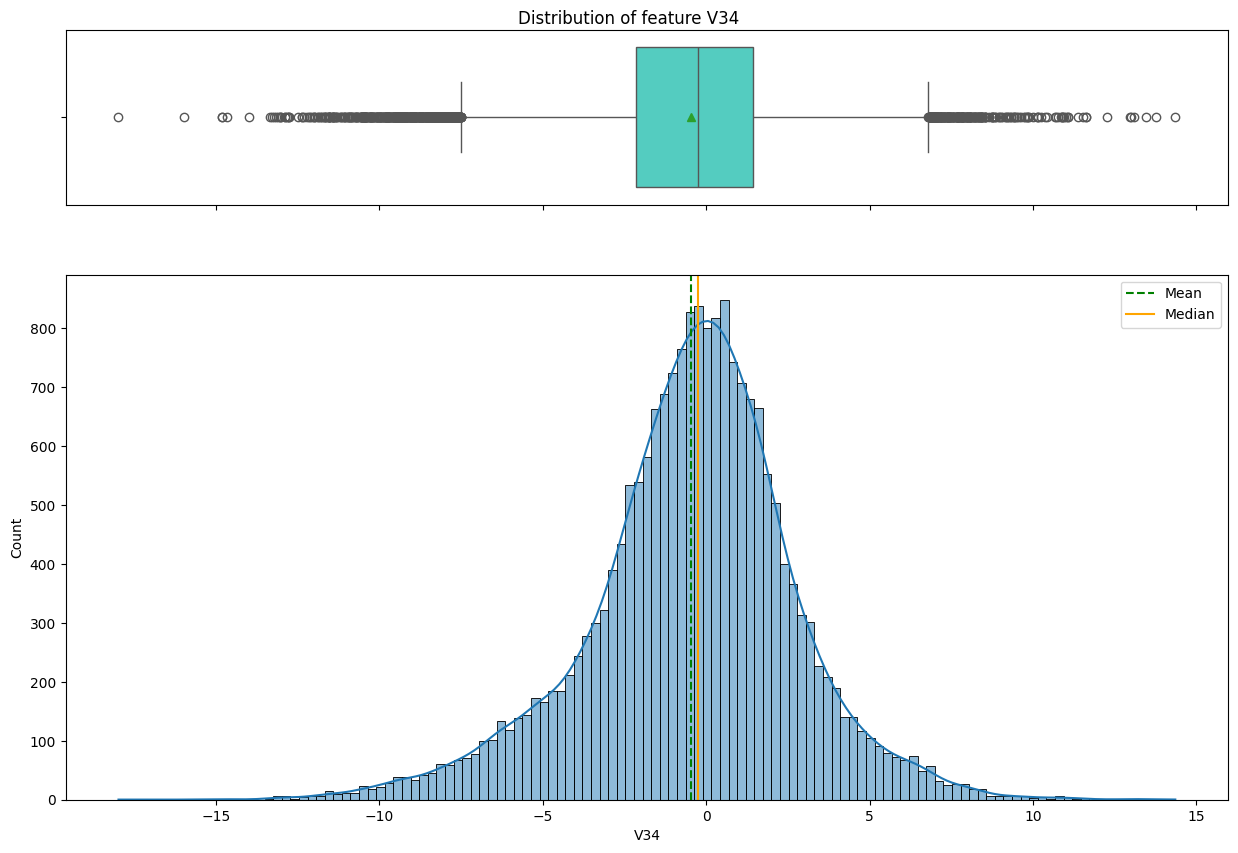

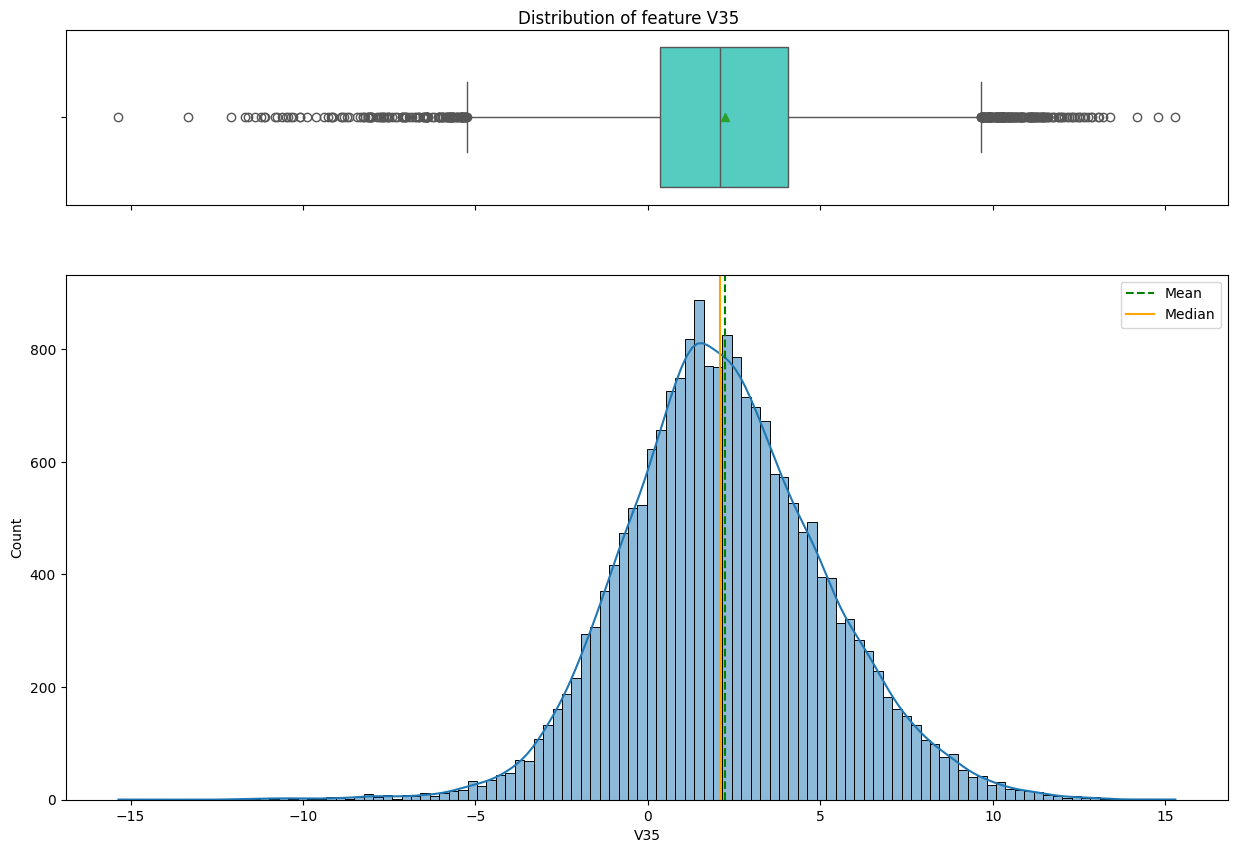

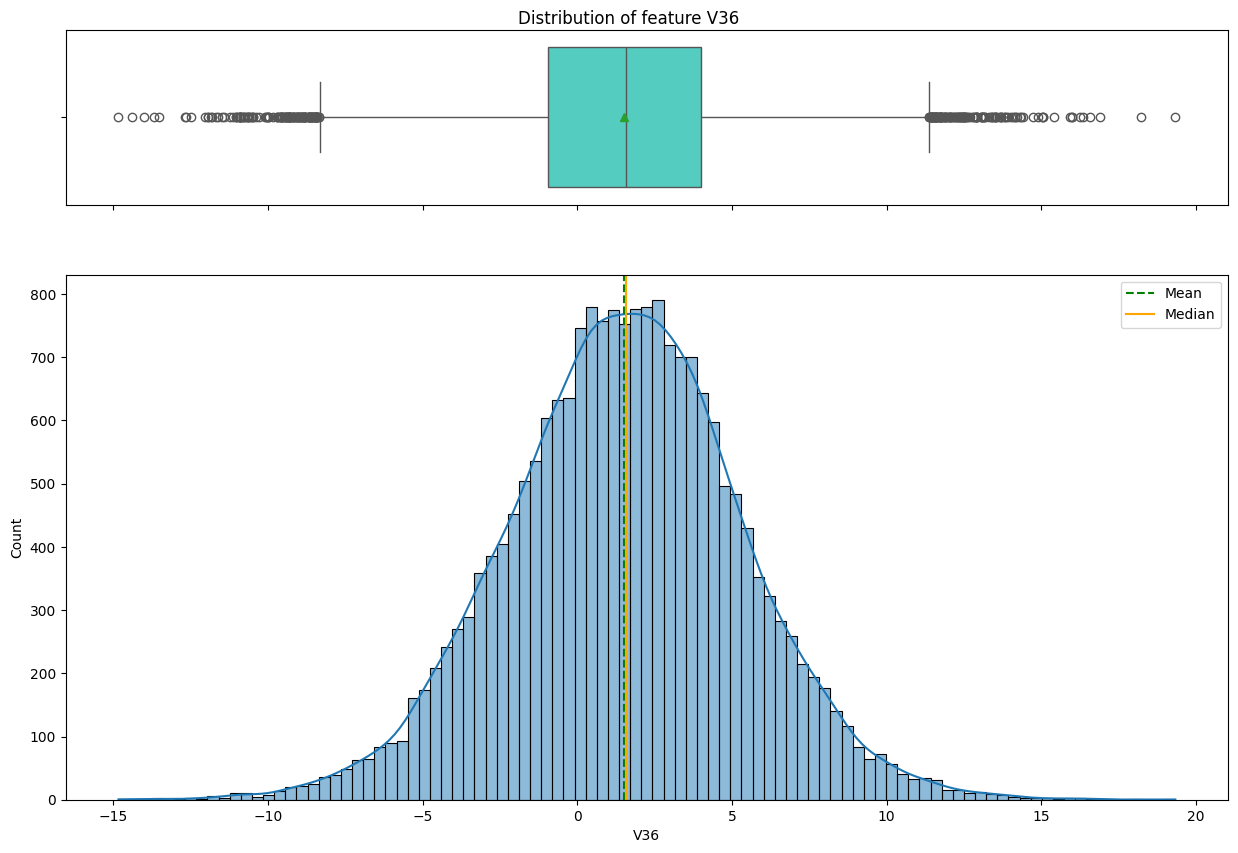

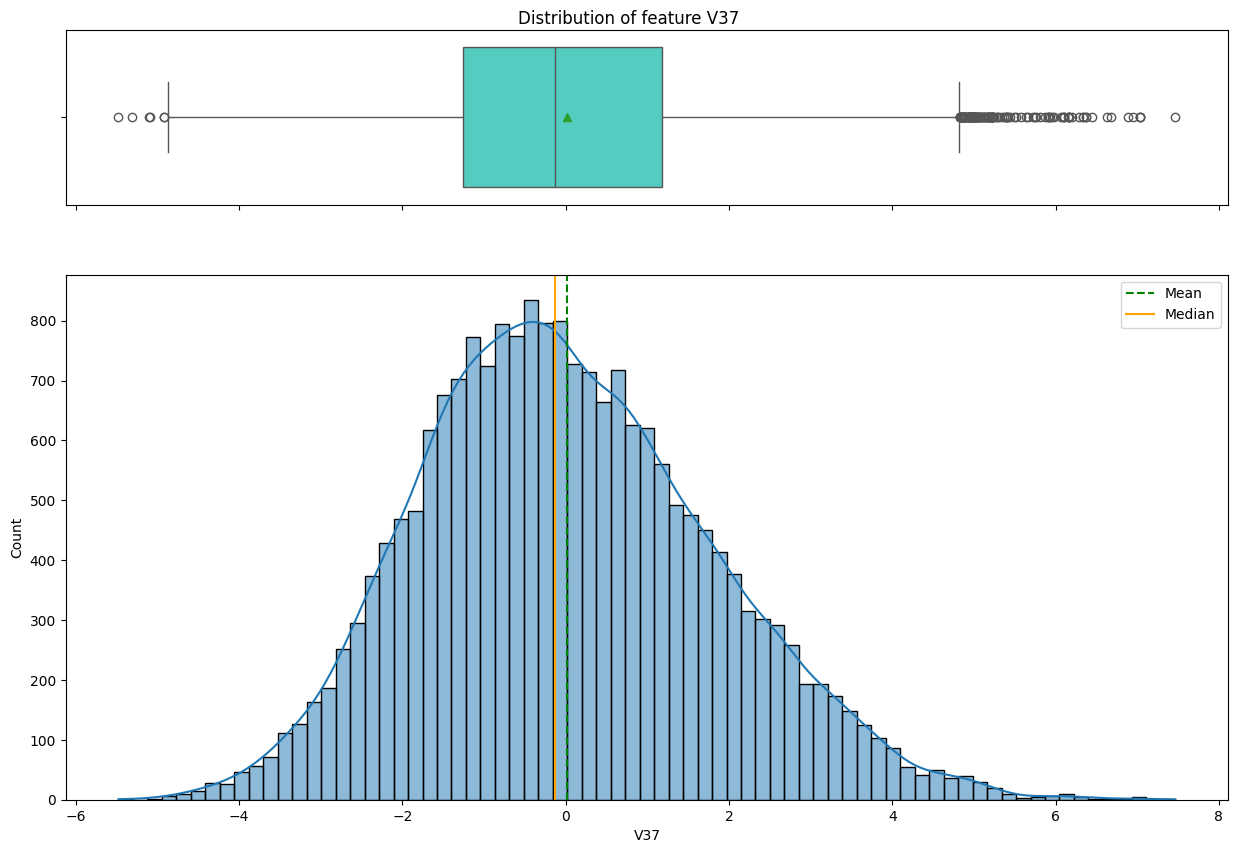

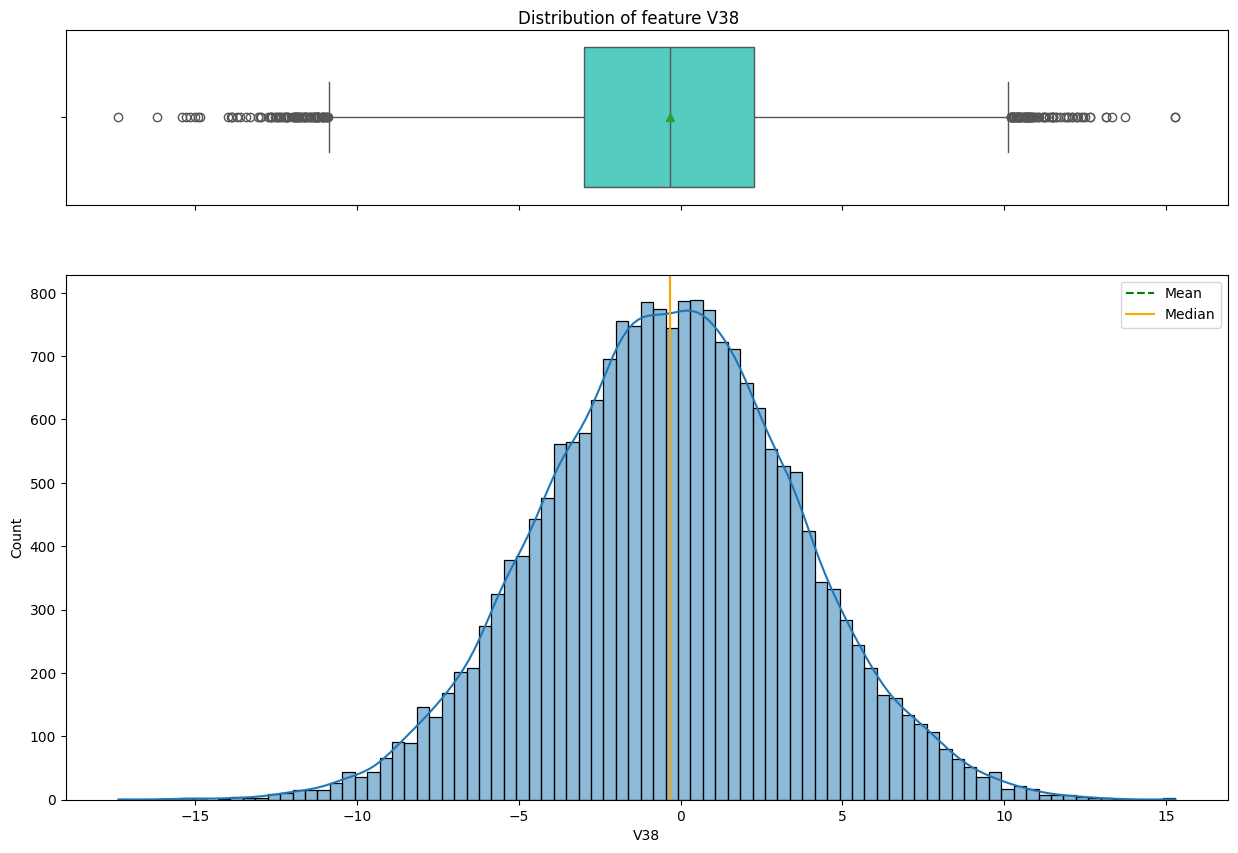

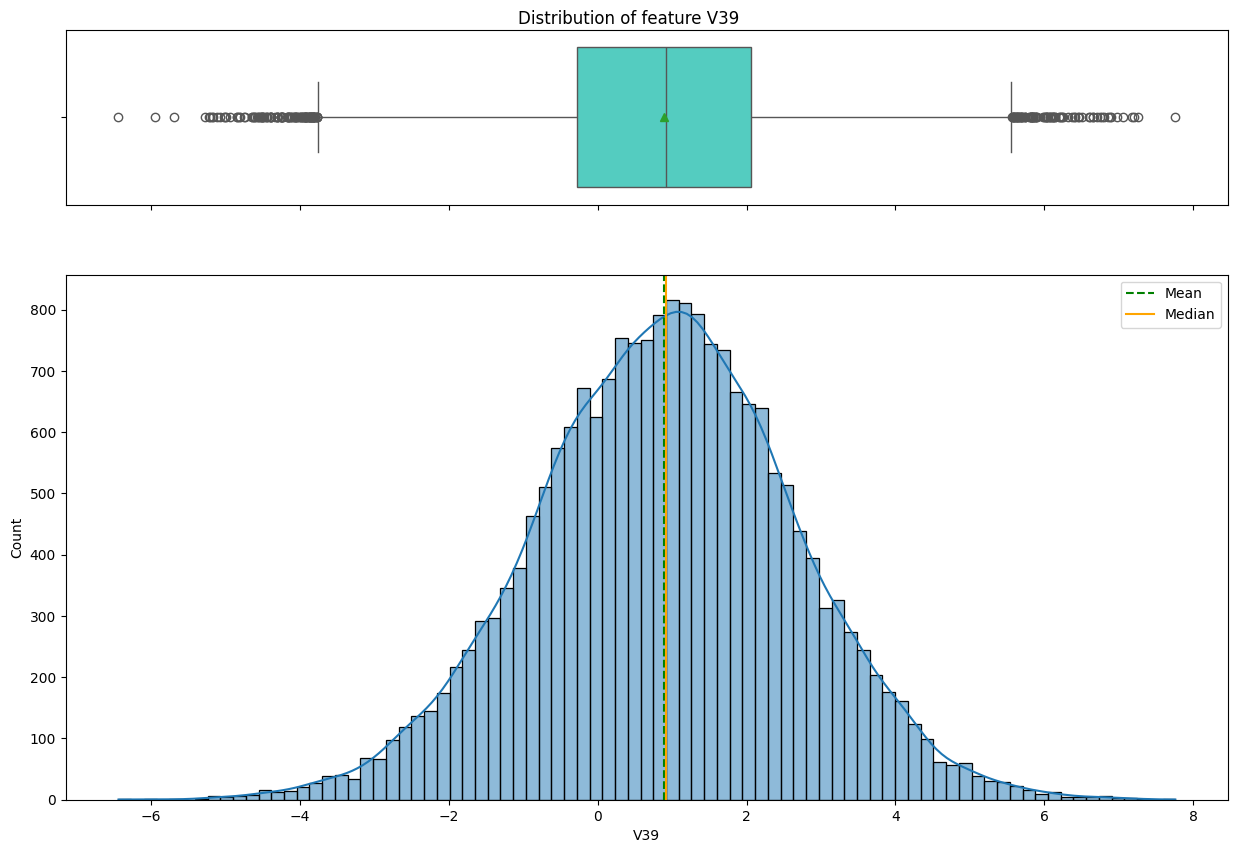

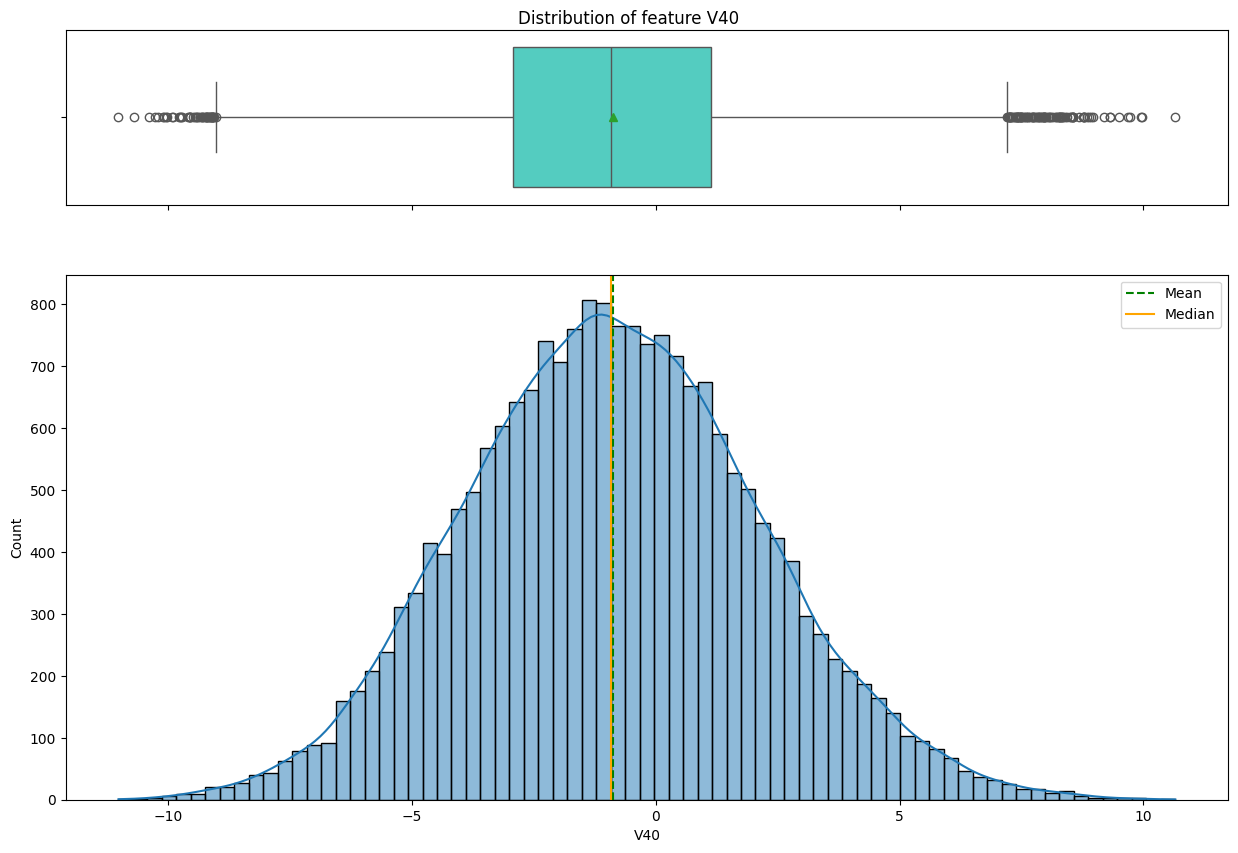

In [26]:
for feature in data.columns.to_list()[:-1]:
    histogram_boxplot(data, feature, kde=True, bins=None, title=f"Distribution of feature {feature}")

<span style="color: blue;"> **Observation**</span>
* The distributions of features V1 to V40 vary, with some exhibiting symmetry and others showing skewness.
* The box plots reveal the presence of outliers in almost all the features
* While the direct meaning of these ciphered features is unknown, their varying scales (also seen from describe() function) are important considerations for subsequent data preprocessing steps like normalization/standardization

### 4.2.2 Check the distrubution of Target variable

In [27]:
# For train data
data["Target"].value_counts(1)

Target
0.0    0.9445
1.0    0.0555
Name: proportion, dtype: float64

In [28]:
# display the proportion of the target variable in the test data
data_test["Target"].value_counts(1)

Target
0.0    0.9436
1.0    0.0564
Name: proportion, dtype: float64

**PCA is performed for visualization only**

In [29]:
# Find the index of column V40
data.columns.get_loc('V40')

39

type(features_2d) =  <class 'numpy.ndarray'>


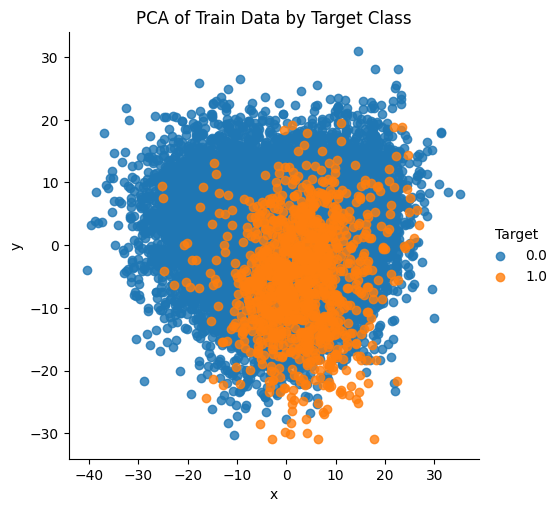

In [30]:
# Visualize data imbalance using PCA
pca = PCA(n_components=2)

# Columns 'V1' and 'V2' have missing values, which will cause an error in fitting.
# For visualization purposes only, we will use column indices from 2 to 39.
# Imputation will be performed after splitting the data.
features_2d = pca.fit_transform(data.iloc[:,2:39])
print("type(features_2d) = ", type(features_2d))

data_2d= pd.DataFrame(features_2d)
data_2d= pd.concat([data_2d, data['Target']], axis=1)
data_2d.columns= ['x', 'y', 'Target']
sns.lmplot(x='x', y='y', data=data_2d, fit_reg=False, hue='Target')
plt.title('PCA of Train Data by Target Class') # Add title here
plt.show() # Ensure the plot is displayed after adding the title

<span style="color: blue;"> **Observation**</span>
* Class imbalance is already observed in section 3.3
* Approximately 94.45% of the cases represent "No failure" (Target = 0), while about 5.5% represent "Failure" (Target = 1).
* PCA gives a better visualization of the imbalance in the train dataset

## 4.3 - Bivariate Analysis

### 4.3.1 - Correlation Check

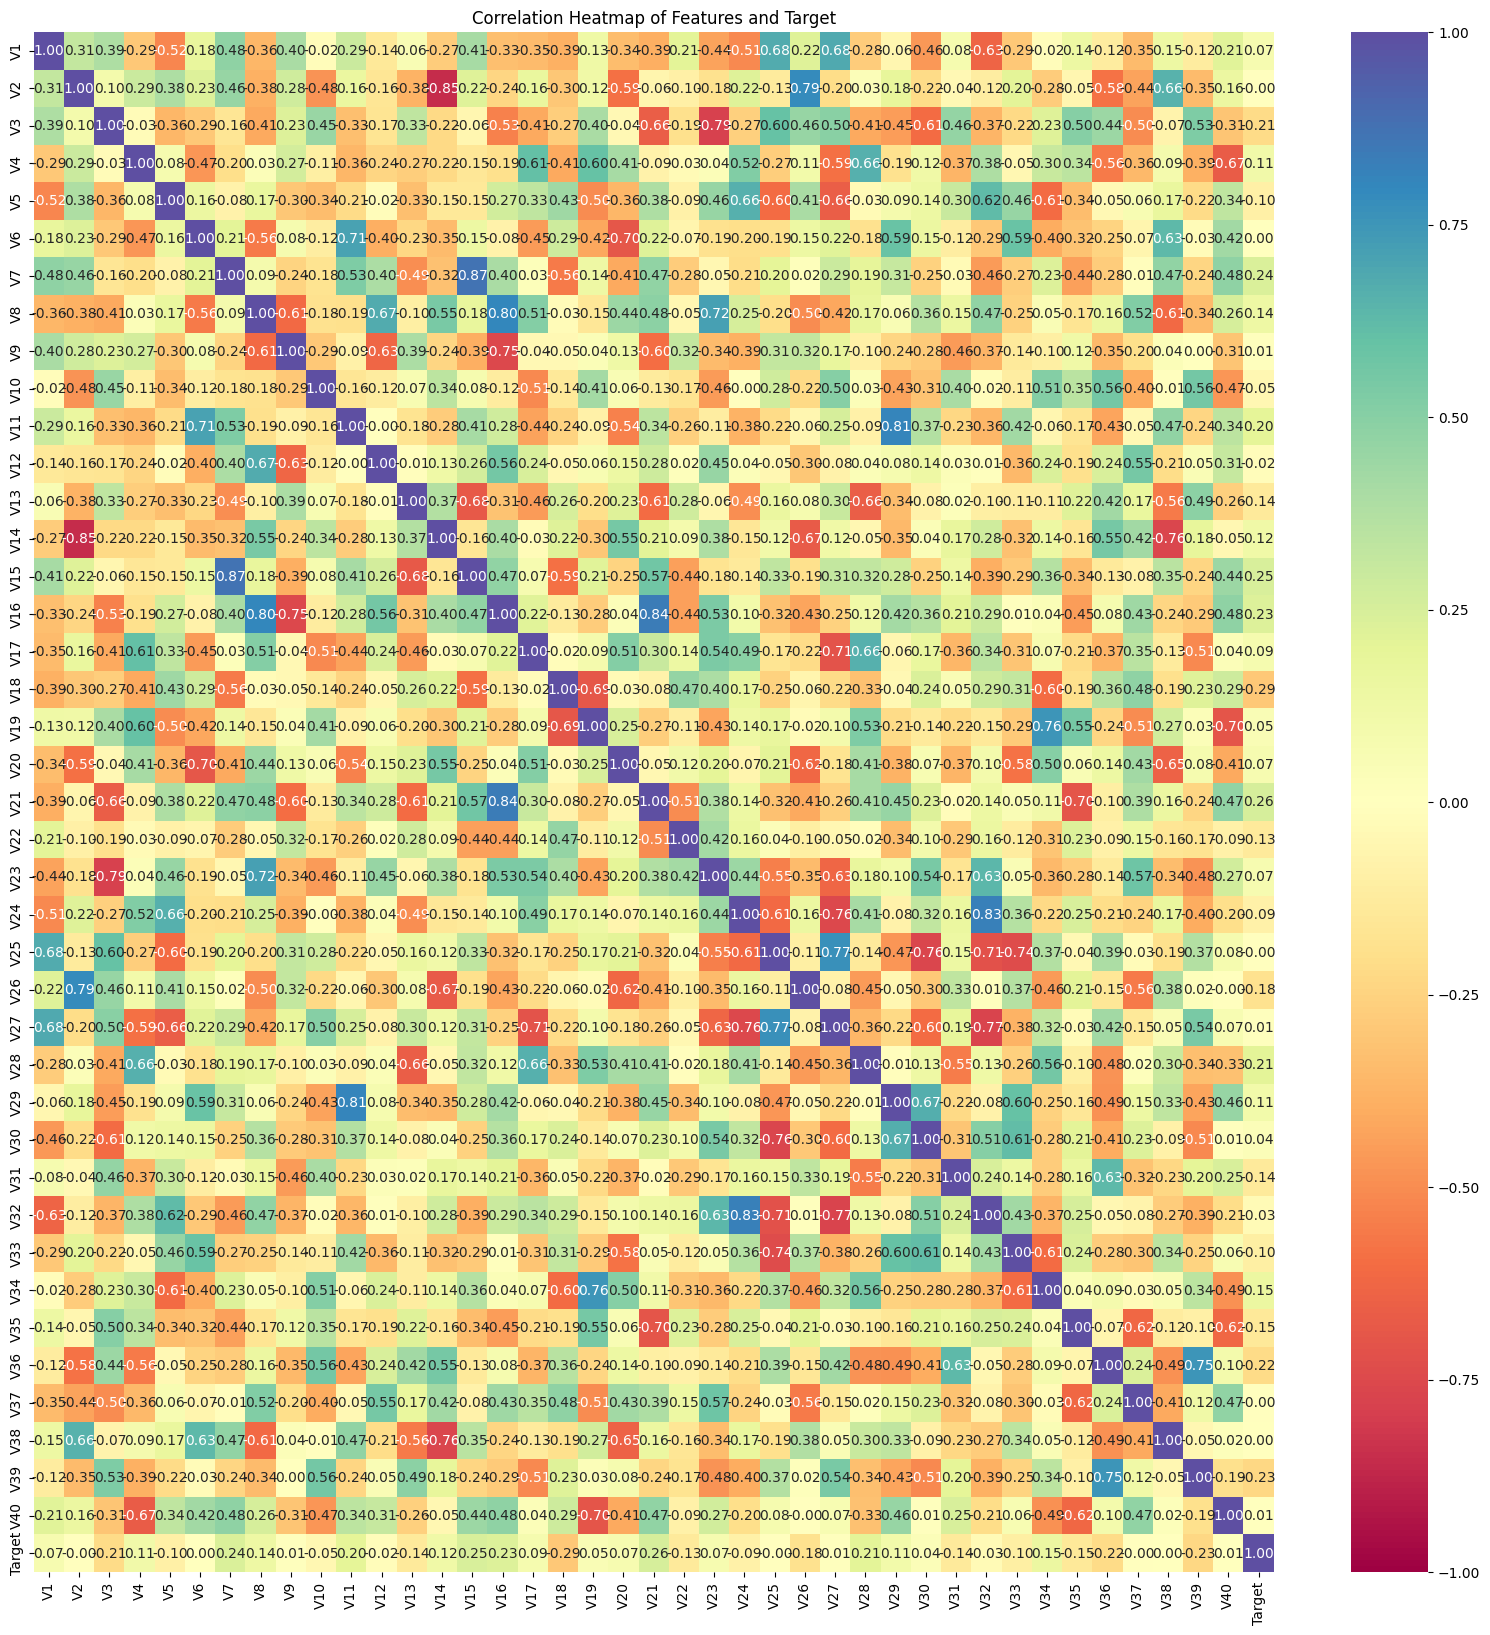

In [31]:
# Removing the target column is not necessary to see correlation
# all columns have numerical values
cols_list = data.columns.tolist()

plt.figure(figsize=(20, 20))
sns.heatmap(
    data[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.title('Correlation Heatmap of Features and Target')
plt.show()

<span style="color: blue;"> **Observation**</span>
* There are some highly positively correlated features with each other (e.g., V15 and V7 have a correlation of 0.87) and some negatively correlated features with each other (e.g., V14 and V2 have a correlation of -0.85).
* The correlation of any particular feature with the Target variable is relatively low, indicating no strong linear relationships between individual features and the target.

# 5 - Data Preprocessing

## 5.1 - Data Preparation for Modeling

In [32]:
# Divide train data into X and y

# Drop the 'Target' column
X = data.drop(columns = ["Target"] , axis=1)

# Column named 'Target' becomes y
y = data["Target"]

In [33]:
# Split data into training and validation set with 20% of the data allocated to validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [34]:
# Check the shape of X_train and y_train
print(X_train.shape)
print(y_train.shape)

(16000, 40)
(16000,)


In [35]:
# Check the shape of X_val and y_val
print(X_val.shape)
print(y_val.shape)

(4000, 40)
(4000,)


In [36]:
# Divide test data into X_test and y_test

# Drop the 'Target' column for X
X_test = data_test.drop(columns = ['Target'] , axis= 1)

# Retain only 'Target' column for y
y_test = data_test["Target"]

In [37]:
# Check the shape of X_test and y_test
print(X_test.shape)
print(y_test.shape)

(5000, 40)
(5000,)


In [38]:
# Check the percentage of classes in target column in training, validation and test set
print("Percentage of classes in Target column in train set : ", y_train.value_counts(1))
print("Percentage of classes in Target column in validation set : ", y_val.value_counts(1))
print("Percentage of classes in Target column in test set : ", y_test.value_counts(1))

Percentage of classes in Target column in train set :  Target
0.0    0.9445
1.0    0.0555
Name: proportion, dtype: float64
Percentage of classes in Target column in validation set :  Target
0.0    0.9445
1.0    0.0555
Name: proportion, dtype: float64
Percentage of classes in Target column in test set :  Target
0.0    0.9436
1.0    0.0564
Name: proportion, dtype: float64


## 5.2 - Missing Value Imputation and Scaling


In [39]:
imputer = SimpleImputer(strategy="median")

In [40]:
# Fit and transform the train data - calculates the median from the training data and imputes missing values
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data using the median calculated from the training data
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)

# Transform the test data using the median calculated from the training data
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

In [41]:
# Verify that no data set has any values missing
print("Missing values in X_train : ", X_train.isnull().sum())
print("-" * 30)
print("Missing values in X_val : ", X_val.isnull().sum())
print("-" * 30)
print("Missing values in X_test : ", X_test.isnull().sum())

Missing values in X_train :  V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
Missing values in X_val :  V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
Missing values in X_test :  V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0


In [42]:
# Backup the column names
column_names = X_train.columns.to_list()

In [43]:
# Standardizing all the columns as they have different ranges.
# This is to ensure that all features contribute equally, training becomes more stable, and the network can learn faster

# Initialize StandardScaler
scaler = StandardScaler()

In [44]:
# Fit the scaler on the training data and transform it
# This calculates the mean and standard deviation from the training data and applies the transformation
X_train = scaler.fit_transform(X_train)

# Transform the validation data using the scaler fitted on the training data
# This ensures that the validation data is scaled using the same parameters as the training data, preventing data leakage
X_val = scaler.transform(X_val)

# Transform the test data using the scaler fitted on the training data
# This ensures consistency in scaling across all datasets
X_test = scaler.transform(X_test)

In [45]:
print("type(X_train) : ", type(X_train))
print("type(X_val) : ", type(X_val))
print("type(X_test) : ", type(X_test))

type(X_train) :  <class 'numpy.ndarray'>
type(X_val) :  <class 'numpy.ndarray'>
type(X_test) :  <class 'numpy.ndarray'>


In [46]:
print("X_train shape : ", X_train.shape)
print("X_val shape : ", X_val.shape)
print("X_test shape : ", X_test.shape)

X_train shape :  (16000, 40)
X_val shape :  (4000, 40)
X_test shape :  (5000, 40)


In [47]:
# Convert target variables to NumPy arrays for compatibility with neural network libraries
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [48]:
print("y_train shape : ", y_train.shape)
print("y_val shape : ", y_val.shape)
print("y_test shape : ", y_test.shape)

y_train shape :  (16000,)
y_val shape :  (4000,)
y_test shape :  (5000,)


In [49]:
print("type(X_train) : ", type(X_train), "type(y_train) = ", type(y_train))
print("type(X_val) : ", type(X_val), "type(y_val) = ", type(y_val))
print("type(X_test) : ", type(X_test), "type(y_test) = ", type(y_test))

type(X_train) :  <class 'numpy.ndarray'> type(y_train) =  <class 'numpy.ndarray'>
type(X_val) :  <class 'numpy.ndarray'> type(y_val) =  <class 'numpy.ndarray'>
type(X_test) :  <class 'numpy.ndarray'> type(y_test) =  <class 'numpy.ndarray'>


<span style="color: blue;"> **Observation**</span>
* The dataset contains only numerical features (V1-V40) and a binary target variable, so categorical encoding is not required.
* Missing values in features V1 and V2 in train, validation and test sets are imputed.
* The predictor variables have a wide range of values, necessitating normalization or standardization for optimal neural network performance.
* A separate test set is provided for final model evaluation.
* Imputation and scaling will be performed after splitting the data to prevent data leakage.
* The target variable exhibits class imbalance, which should be addressed during model training (e.g., using class weights or other techniques).

# 6 - Model Building and Performance Improvement

## 6.1 - Model Evaluation Criterion

In this problem, we aim to predict generator failures, where:

- **Class 1** represents "Failure"
- **Class 0** represents "No failure"

When evaluating a classification model, we consider the following outcomes:

- **True Positives (TP)**: The model correctly predicts a "Failure" (Class 1) when the actual class is "Failure" (Class 1). These result in repair costs.
- **True Negatives (TN)**: The model correctly predicts "No failure" (Class 0) when the actual class is "No failure" (Class 0).
- **False Negatives (FN)**: The model incorrectly predicts "No failure" (Class 0) when the actual class is "Failure" (Class 1). These are costly as they lead to generator replacement.
- **False Positives (FP)**: The model incorrectly predicts "Failure" (Class 1) when the actual class is "No failure" (Class 0). These result in inspection costs.

Based on the problem description, the cost of a False Negative (replacement cost) is significantly higher than the cost of a False Positive (inspection cost), and the cost of a True Positive (repair cost) is less than the replacement cost.

Therefore, minimizing False Negatives is crucial. This translates to prioritizing a model that has a high **Recall** for the positive class (Failure). Recall measures the model's ability to identify all actual positive instances. A higher recall means the model is better at detecting failures, thus reducing the number of missed failures (False Negatives) and the associated high replacement costs.

## 6.2 - Define utility Functions
- A function required to plot loss and recall
- A function to derive metrics
- A function to visualize confusion matrix

In [50]:
# Plots loss and a specified metric against epochs
def plot(history, name, model_config):
    """
    Function to plot loss/accuracy

    history: an object which stores the metrics and losses.
    name: can be one of Loss or Accuracy
    model_config: name of the model
    """
    #Creating a subplot with figure and axes.
    fig, ax = plt.subplots()
    #Plotting the train accuracy or train loss
    plt.plot(history.history[name])
    #Plotting the validation accuracy or validation loss
    plt.plot(history.history['val_'+name])

    #Defining the title of the plot
    ax.set_title(f"Model - {name.capitalize()}\n{model_config}", fontsize=10)
    #Capitalizing the first letter
    plt.ylabel(name.capitalize())
    #Defining the label for the x-axis
    plt.xlabel('Epoch')
    #Defining the legend, loc controls the position of the legend.
    fig.legend(['Train', 'Validation'], loc="outside lower right")

In [51]:
# Define a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors) > threshold
    #print("type(pred) : ", type(pred), "Sample values : ", pred[0:5, :])
    #print("type(target) : ", type(target), "Sample values : ", target[0:5])

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='macro')  # to compute Recall
    precision = precision_score(target, pred, average='macro')  # to compute Precision
    f1 = f1_score(target, pred, average='macro')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,}, index = [0]
    )

    return df_perf

In [52]:
# Define function to plot sklearn confusion matrix using seaborn heatmap visalisation
def make_confusion_matrix(cf,
                          group_names=['True Negative','False Positive','False Negative','True Positive'],
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis.
    count:         If True, show the raw number in the confusion matrix.
    normalize:     If True, show the proportions for each category.
    cbar:          If True, show the color bar.
    xyticks:       If True, show x and y ticks.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure.
    sum_stats:     If True, display summary statistics below the figure.
    figsize:       Tuple representing the figure size.
    cmap:          Colormap of the values displayed from matplotlib.
    title:         Title for the heatmap.
    '''

    print(cf)

    # Code to generate text inside each sqaure
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # Code to generate summary statistics and text for summary stats
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        # Show some more stats for binary confusion matrix
        if len(cf)==2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # Set figure parameters according to other arguments
    if figsize==None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        # Do not show categories if xyticks is False
        categories=False

    # Plot heatmap visualisation
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title, fontsize=10)

In [53]:
# Since the class is imabalnced in the data, we'll use class weights in all the models
# Calculate class weights for imbalanced dataset. This gives higher weight to the minority class.
cw = (y_train.shape[0]) / np.bincount(y_train.astype(int))

# Create a dictionary mapping class indices to their respective class weights
cw_dict = {}
for i in range(cw.shape[0]):
    cw_dict[i] = cw[i]

cw_dict

{0: np.float64(1.0587612493382743), 1: np.float64(18.01801801801802)}

## 6.3 - Model 0 - Baseline Model

- Model Configuration
  - Model Architecture: Input Layer (40 neurons, implicitly defined by input data), 1 Hidden Layer (7 neurons), Output Layer (1 neuron).
  - Activation Functions: ReLU for the hidden layer, Sigmoid for the output layer (for binary classification probability).
  - Optimizer: Stochastic Gradient Descent (SGD).
  - Loss Function: Binary Crossentropy (standard for binary classification).
  - Class Imbalance Handling: Utilizing class weights to address the skewed distribution of the target variable.
  - Training Parameters:
      - Epochs: 25
      - Batch Size: 32

In [54]:
# Define model configuration string to use in the title of graphs
model_0_config = "(1HL,7N,relu \n sgd \n bs32, 25E) "

In [55]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [56]:
# Initializing the sequential model
model_0 = Sequential()

# Add the first hidden layer with 7 neurons, ReLU activation, and input dimension matching the number of features in X_train
model_0.add(Dense(7, activation="relu",input_dim=X_train.shape[1]))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_0.add(Dense(1, activation="sigmoid"))

In [57]:
model_0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 7)              │           287 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295 (1.15 KB)

 Trainable params: 295 (1.15 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Define SGD as the optimizer to be used
optimizer = tf.keras.optimizers.SGD()

# Recall is the chosen metric to measure
model_0.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [59]:
start = time.time()
history = model_0.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=32, epochs=25, class_weight=cw_dict)
end=time.time()

Epoch 1/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - Recall: 0.7680 - loss: 0.9952 - val_Recall: 0.8739 - val_loss: 0.3598
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8993 - loss: 0.5882 - val_Recall: 0.8784 - val_loss: 0.3195
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9010 - loss: 0.5407 - val_Recall: 0.8784 - val_loss: 0.2924
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9082 - loss: 0.5091 - val_Recall: 0.8784 - val_loss: 0.2752
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9045 - loss: 0.4882 - val_Recall: 0.8784 - val_loss: 0.2628
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8960 - loss: 0.4735 - val_Recall: 0.8784 - val_loss: 0.2507
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8995 - loss: 0.4573 - val_Recall: 0.8784 - val_loss: 0.2418
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8947 - loss: 0.4461 - val_Recall: 0.8784 - val_loss: 0.2335
Epoch 9/

In [60]:
print("Time taken in seconds ",end - start)

Time taken in seconds  33.30342411994934


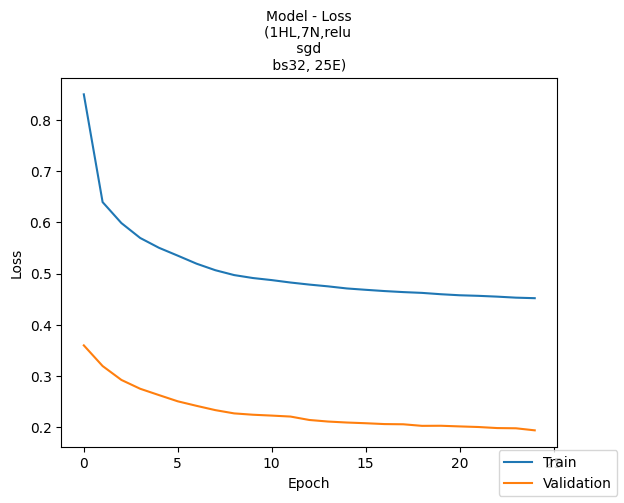

In [61]:
plot(history,'loss', model_0_config)

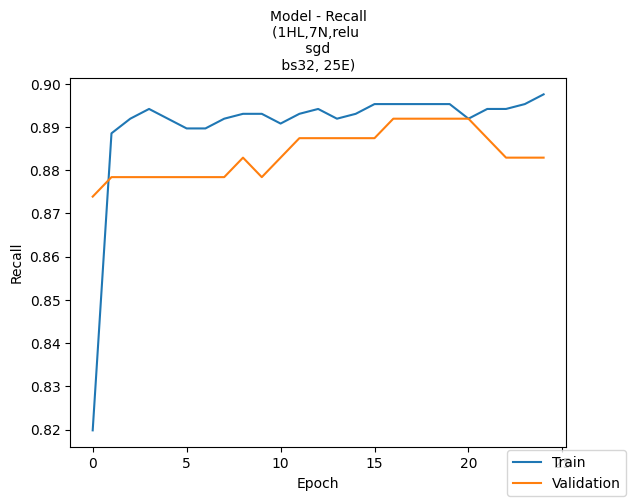

In [62]:
plot(history,'Recall', model_0_config)

In [63]:
model_0_train_perf = model_performance_classification(model_0, X_train, y_train)
model_0_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0  0.945438  0.925008   0.749345  0.808852

In [64]:
model_0_val_perf = model_performance_classification(model_0, X_val, y_val)
model_0_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy    Recall  Precision  F1 Score
0    0.9505  0.918678   0.762725  0.818843

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[4512  206]
 [  41  241]]


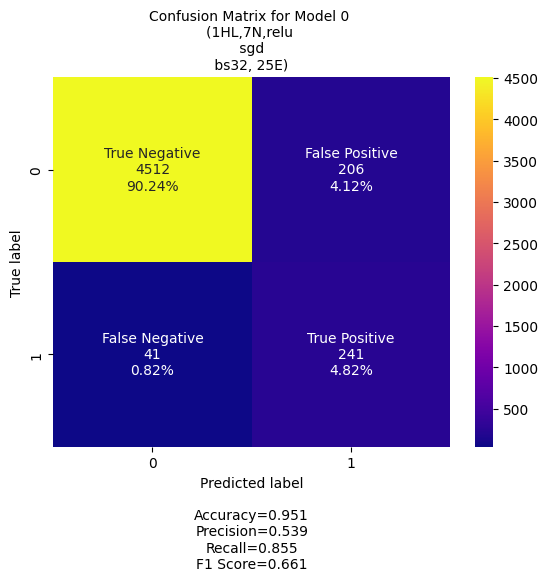

In [65]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_0.predict(X_test)
y_test_pred[0:10, :]
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 0 \n" + model_0_config
    )

<span style="color: blue;"> **Observation**</span>
* Baseline model
    * The loss function shows a steep decrease in the initial epochs and then stabilizes, indicating convergence.
    * Recall on the training set is approximately 92.50%, while on the validation set it's around 91.87%. The test set recall is 85.5%.
    * The number of False Negatives on the test set is 41.
    * The drop in recall from training/validation to the test set suggests a potential generalization gap.

## 6.4 - Model 1 - Increasing Epochs

- Model Configuration
  - Update epochs to 50 on Model 0 configuration

In [66]:
# Define model configuration string to use in the title of graphs
model_1_config = "(1HL,7N,relu \n sgd \n bs32, 50E) "

In [67]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [68]:
# Initializing the sequential model
model_1 = Sequential()

# Add the first hidden layer with 7 neurons, ReLU activation, and input dimension matching the number of features in X_train
model_1.add(Dense(7, activation="relu",input_dim=X_train.shape[1]))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_1.add(Dense(1, activation="sigmoid"))

In [69]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 7)              │           287 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295 (1.15 KB)

 Trainable params: 295 (1.15 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# Define SGD as the optimizer to be used
optimizer = tf.keras.optimizers.SGD()

# Recall is the chosen metric to measure
model_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [71]:
start = time.time()
history = model_1.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=32, epochs=50, class_weight=cw_dict)
end=time.time()

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.8738 - loss: 0.9185 - val_Recall: 0.8739 - val_loss: 0.4082
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8740 - loss: 0.6401 - val_Recall: 0.8829 - val_loss: 0.3537
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.8736 - loss: 0.5927 - val_Recall: 0.8784 - val_loss: 0.3259
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.8747 - loss: 0.5649 - val_Recall: 0.8784 - val_loss: 0.3102
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.8769 - loss: 0.5461 - val_Recall: 0.8829 - val_loss: 0.2934
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8804 - loss: 0.5313 - val_Recall: 0.8829 - val_loss: 0.2796
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8783 - loss: 0.5157 - val_Recall: 0.8784 - val_loss: 0.2658
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8872 - loss: 0.4947 - val_Recall: 0.8784 - val_loss: 0.2518
Epoch 9/

In [72]:
print("Time taken in seconds ",end - start)

Time taken in seconds  63.94768261909485


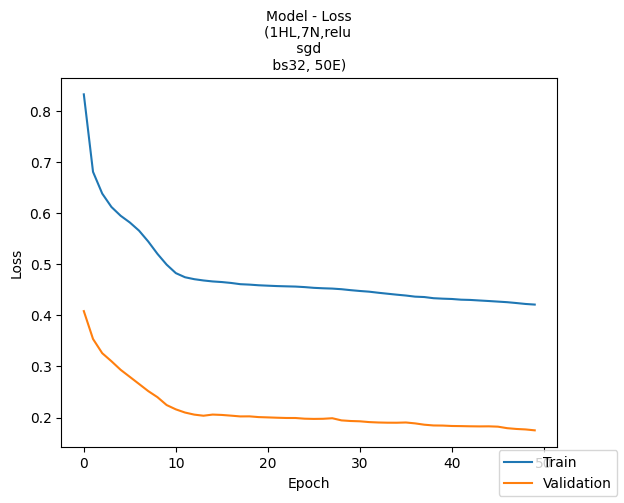

In [73]:
plot(history,'loss', model_1_config)

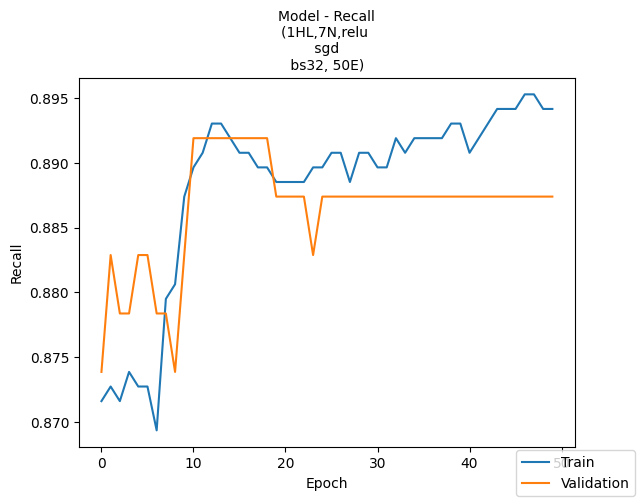

In [74]:
plot(history,'Recall', model_1_config)

In [75]:
model_1_train_perf = model_performance_classification(model_1, X_train, y_train)
model_1_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0  0.955562  0.933018   0.778021  0.834986

In [76]:
model_1_val_perf = model_performance_classification(model_1, X_val, y_val)
model_1_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy    Recall  Precision  F1 Score
0   0.95825  0.924901   0.787146  0.839934

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[4528  190]
 [  40  242]]


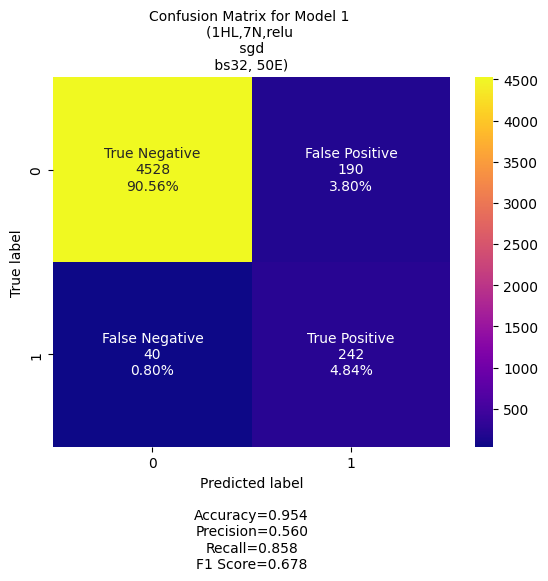

In [77]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_1.predict(X_test)
#print(y_test_pred[0:10, :])
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 1 \n" + model_1_config
    )

<span style="color: blue;"> **Observation**</span>
* Model 1 (Increased Epochs):
    * The loss function and recall plots show minimal improvement beyond 25 epochs, suggesting convergence was largely achieved earlier.
    * Doubling the training epochs resulted in a proportional increase in training time with only marginal improvements in performance metrics across all datasets.
    * Recall on the test set improved slightly, and the number of False Negatives decreased by one compared to the baseline model.
    * Given the minimal performance gain and increased training time, further models will revert to 25 epochs.

## 6.5 - Model 2 - Increase batch_size

- Model Configuration
  - Increase the mini-batch size to 64 on Model 0 configuration to reduce the number of parameter updates per epoch and evaluate its impact on model performance and training efficiency.

In [78]:
# Define model configuration string to use in the title of graphs
model_2_config = "(1HL,7N,relu \n sgd \n bs64, 25E) "

In [79]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [80]:
# Initializing the sequential model
model_2 = Sequential()

# Add the first hidden layer with 7 neurons, ReLU activation, and input dimension matching the number of features in X_train
model_2.add(Dense(7, activation="relu",input_dim=X_train.shape[1]))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_2.add(Dense(1, activation="sigmoid"))

In [81]:
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 7)              │           287 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295 (1.15 KB)

 Trainable params: 295 (1.15 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# Define SGD as the optimizer to be used
optimizer = tf.keras.optimizers.SGD()

# Recall is the chosen metric to measure
model_2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [83]:
start = time.time()
history = model_2.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=64, epochs=25, class_weight=cw_dict)
end=time.time()

Epoch 1/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - Recall: 0.8326 - loss: 1.1976 - val_Recall: 0.8829 - val_loss: 0.4640
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8828 - loss: 0.7161 - val_Recall: 0.8739 - val_loss: 0.3708
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8861 - loss: 0.6216 - val_Recall: 0.8694 - val_loss: 0.3293
Epoch 4/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8920 - loss: 0.5772 - val_Recall: 0.8829 - val_loss: 0.3081
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8990 - loss: 0.5504 - val_Recall: 0.9009 - val_loss: 0.2960
Epoch 6/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8978 - loss: 0.5321 - val_Recall: 0.9054 - val_loss: 0.2864
Epoch 7/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9018 - loss: 0.5175 - val_Recall: 0.9009 - val_loss: 0.2775
Epoch 8/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9021 - loss: 0.5070 - val_Recall: 0.9009 - val_loss: 0.2698
Epoch 9/

In [84]:
print("Time taken in seconds ",end - start)

Time taken in seconds  18.828055381774902


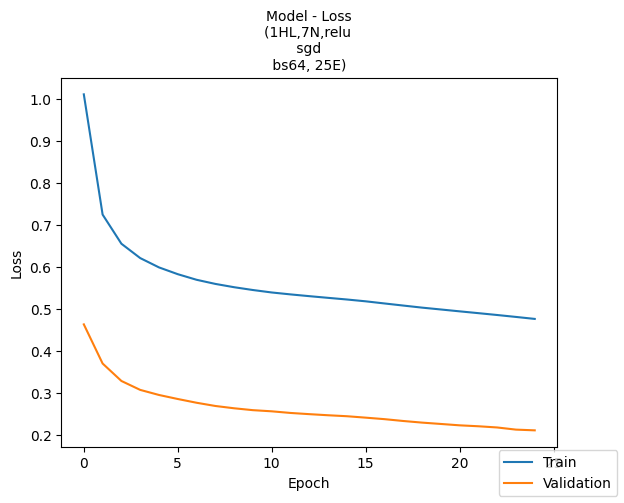

In [85]:
plot(history,'loss', model_2_config)

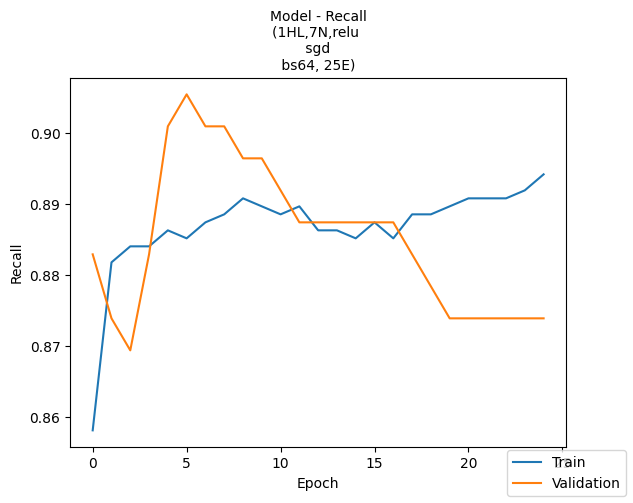

In [86]:
plot(history,'Recall', model_2_config)

In [87]:
model_2_train_perf = model_performance_classification(model_2, X_train, y_train)
model_2_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0  0.935187  0.919052   0.725615  0.785717

In [88]:
model_2_val_perf = model_performance_classification(model_2, X_val, y_val)
model_2_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy    Recall  Precision  F1 Score
0    0.9375  0.907556   0.729267  0.787096

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[4436  282]
 [  42  240]]


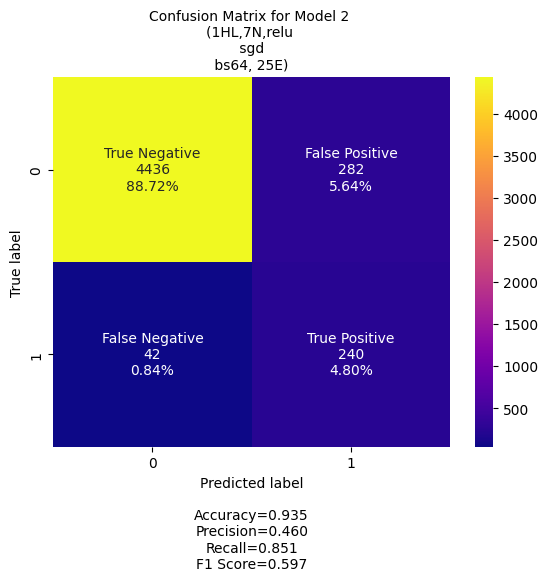

In [89]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_2.predict(X_test)
#print(y_test_pred[0:10, :])
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 2 \n" + model_2_config
    )

<span style="color: blue;"> **Observation**</span>
* Model 2 (Increased batch_size):
  * Increasing the batch size to 64 resulted in a slight decrease in model performance across evaluation metrics.
  * Specifically, a marginal reduction in recall was observed on both the training and validation sets.
  * Based on these findings, subsequent model iterations will utilize a batch size of 32 and be trained for 25 epochs.

## 6.6 - Model 3 - Increasing Neurons in the First Hidden Layer

- Model Configuration
  - Increase the number of neurons in the first hidden layer to explore a more complex model capacity.

In [90]:
# Define model configuration string to use in the title of graphs
model_3_config = "(1HL,21N,relu \n sgd \n bs32, 25E) "

In [91]:
# Define the batch size and epochs upfront to use the same values for all models
epochs = 25
batch_size = 32

In [92]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [93]:
# Initializing the sequential model
model_3 = Sequential()

# Add the first hidden layer with 7 neurons, ReLU activation, and input dimension matching the number of features in X_train
model_3.add(Dense(21, activation="relu",input_dim=X_train.shape[1]))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_3.add(Dense(1, activation="sigmoid"))

In [94]:
model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           861 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883 (3.45 KB)

 Trainable params: 883 (3.45 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
# Define SGD as the optimizer to be used
optimizer = tf.keras.optimizers.SGD()

# Recall is the chosen metric to measure
model_3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [96]:
start = time.time()
history = model_3.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.8085 - loss: 0.9271 - val_Recall: 0.8964 - val_loss: 0.3242
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.9049 - loss: 0.5349 - val_Recall: 0.8829 - val_loss: 0.2617
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.9092 - loss: 0.4641 - val_Recall: 0.8874 - val_loss: 0.2344
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9088 - loss: 0.4273 - val_Recall: 0.8919 - val_loss: 0.2185
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9062 - loss: 0.4064 - val_Recall: 0.8919 - val_loss: 0.2085
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9013 - loss: 0.3941 - val_Recall: 0.8919 - val_loss: 0.2010
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9035 - loss: 0.3848 - val_Recall: 0.8919 - val_loss: 0.1968
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9035 - loss: 0.3774 - val_Recall: 0.8919 - val_loss: 0.1916
Epoch 9/

In [97]:
print("Time taken in seconds ",end - start)

Time taken in seconds  34.822436571121216


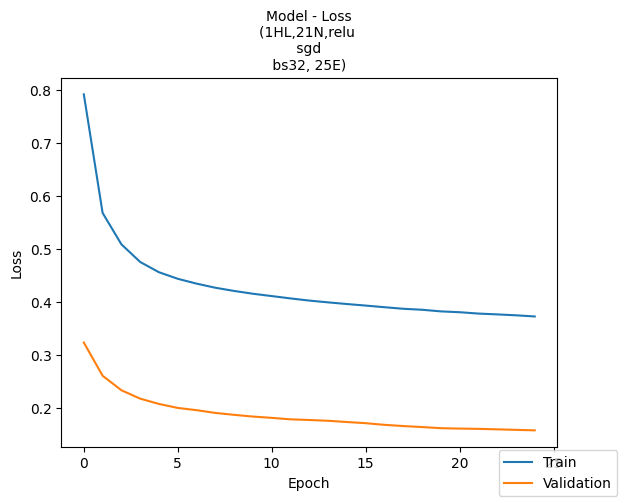

In [98]:
plot(history,'loss', model_3_config)

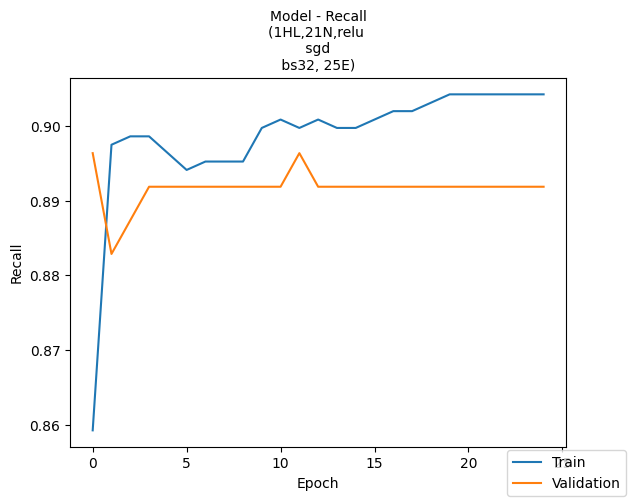

In [99]:
plot(history,'Recall', model_3_config)

In [100]:
model_3_train_perf = model_performance_classification(model_3, X_train, y_train)
model_3_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0  0.961125  0.941792   0.796185  0.851689

In [101]:
model_3_val_perf = model_performance_classification(model_3, X_val, y_val)
model_3_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Accuracy    Recall  Precision  F1 Score
0   0.96025  0.928079   0.794025  0.846078

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[4553  165]
 [  37  245]]


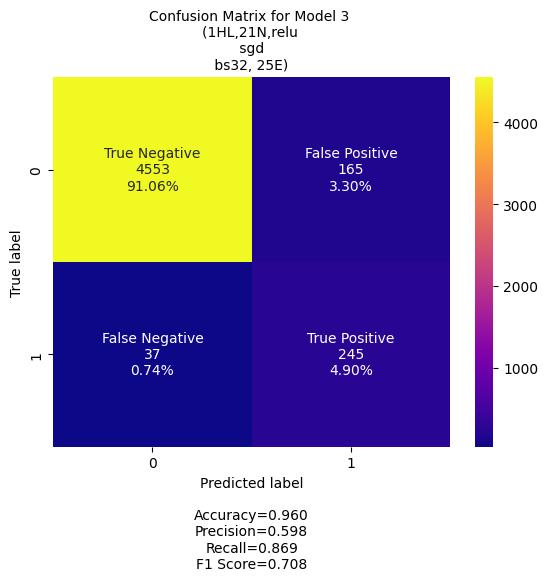

In [102]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_3.predict(X_test)
y_test_pred[0:10, :]
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 3 \n" + model_3_config
    )

<span style="color: blue;"> **Observation**</span>
* Increasing the complexity by increasing neurons in the hidden layer
  * The loss function shows a steep decrease in the initial epochs and then stabilizes, indicating convergence more or less similar to the baseline model.
  * Recall has improved, and the number of false negatives has decreased.
  * The training time remains nominal.
  * This configuration for the first hidden layer will be used in subsequent models.

## 6.7 - Model 4 - Change Activation in the First Hidden Layer

- Model Configuration
  - Change the activation function in the first hidden layer to leaky_relu and observe the performance

In [103]:
# Define model configuration string to use in the title of graphs
model_4_config = "(1HL,21N,leaky_relu \n sgd \n bs32, 25E) "

In [104]:
# Define the batch size and epochs upfront to use the same values for all models
epochs = 25
batch_size = 32

In [105]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [106]:
# Initializing the sequential model
model_4 = Sequential()

# Add the first hidden layer with 7 neurons, Leaky ReLU activation, and input dimension matching the number of features in X_train
model_4.add(Dense(21, activation="leaky_relu",input_dim=X_train.shape[1]))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_4.add(Dense(1, activation="sigmoid"))

In [107]:
model_4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           861 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883 (3.45 KB)

 Trainable params: 883 (3.45 KB)

 Non-trainable params: 0 (0.00 B)

In [108]:
# Define SGD as the optimizer to be used
optimizer = tf.keras.optimizers.SGD()

# Recall is the chosen metric to measure
model_4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [109]:
start = time.time()
history = model_4.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - Recall: 0.7609 - loss: 1.0298 - val_Recall: 0.8919 - val_loss: 0.3720
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.8901 - loss: 0.5994 - val_Recall: 0.8919 - val_loss: 0.3134
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9071 - loss: 0.5279 - val_Recall: 0.8919 - val_loss: 0.2797
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9112 - loss: 0.4831 - val_Recall: 0.8964 - val_loss: 0.2583
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9070 - loss: 0.4558 - val_Recall: 0.9009 - val_loss: 0.2433
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9026 - loss: 0.4364 - val_Recall: 0.9009 - val_loss: 0.2323
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9033 - loss: 0.4213 - val_Recall: 0.9009 - val_loss: 0.2232
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9033 - loss: 0.4104 - val_Recall: 0.9054 - val_loss: 0.2182
Epoch 9/

In [110]:
print("Time taken in seconds ",end - start)

Time taken in seconds  33.2160861492157


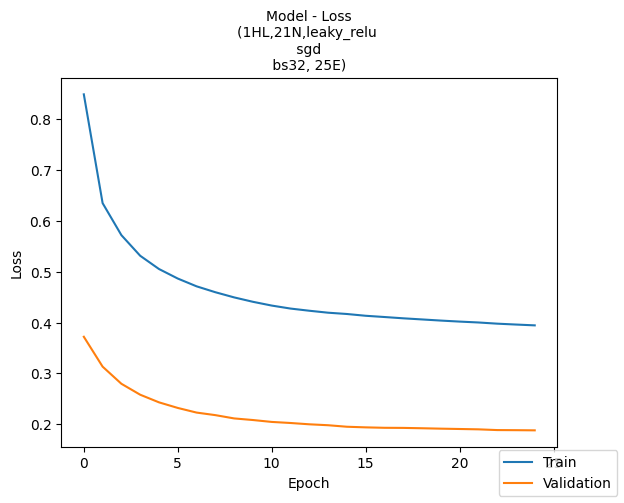

In [111]:
plot(history,'loss', model_4_config)

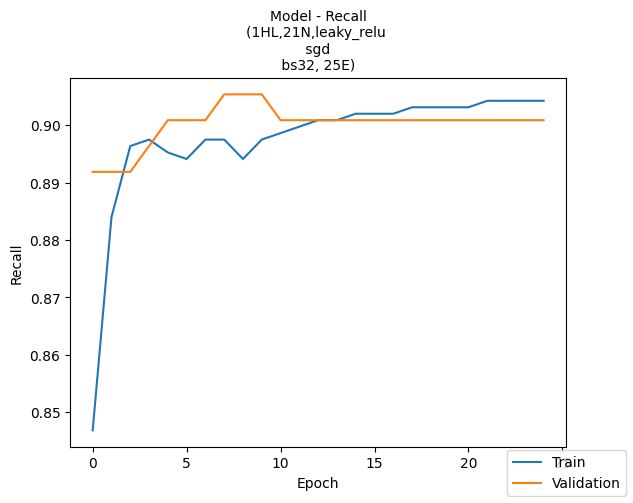

In [112]:
plot(history,'Recall', model_4_config)

In [113]:
model_4_train_perf = model_performance_classification(model_4, X_train, y_train)
model_4_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0    0.9475  0.933519   0.755054  0.815737

In [114]:
model_4_val_perf = model_performance_classification(model_4, X_val, y_val)
model_4_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy    Recall  Precision  F1 Score
0      0.95  0.926893   0.761513   0.81982

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[4495  223]
 [  41  241]]


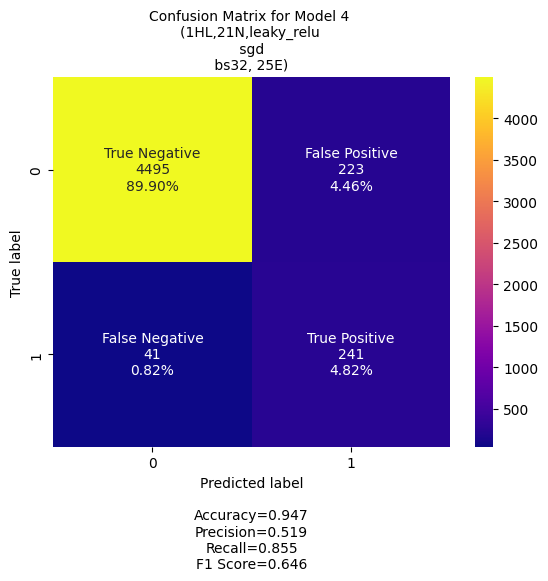

In [115]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_4.predict(X_test)
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 4 \n" + model_4_config
    )

<span style="color: blue;"> **Observation**</span>
* Changing the activation function in the hidden layer results in marginal improvements in training and validation recall, while the loss curve remains largely unchanged.
* leaky_relu will be used for the first hidden layer in subsequent models.

## 6.8 - Model 5 - Add additional hidden layer

- Model Configuration
  - Add additional layer over Model 4 and observe the performance

In [261]:
# Define model configuration string to use in the title of graphs
model_5_config = "(1HL,21N,leaky_relu + 2HL,14N,relu \n sgd \n bs32, 25E) "

In [262]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [263]:
# Initializing the sequential model
model_5 = Sequential()

# Add the first hidden layer with 7 neurons, ReLU activation, and input dimension matching the number of features in X_train
model_5.add(Dense(21, activation="leaky_relu",input_dim=X_train.shape[1]))

# Additional hidden layer with 14 neurons, ReLU activation
model_5.add(Dense(14, activation="relu"))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_5.add(Dense(1, activation="sigmoid"))

In [264]:
model_5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           861 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,184 (4.62 KB)

 Trainable params: 1,184 (4.62 KB)

 Non-trainable params: 0 (0.00 B)

In [265]:
# Define SGD as the optimizer to be used
optimizer = tf.keras.optimizers.SGD()

# Recall is the chosen metric to measure
model_5.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [266]:
start = time.time()
history = model_5.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.9056 - loss: 0.9221 - val_Recall: 0.8919 - val_loss: 0.3301
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8963 - loss: 0.5090 - val_Recall: 0.9009 - val_loss: 0.2712
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Recall: 0.8960 - loss: 0.4394 - val_Recall: 0.9009 - val_loss: 0.2392
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9028 - loss: 0.3984 - val_Recall: 0.8964 - val_loss: 0.2138
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9009 - loss: 0.3722 - val_Recall: 0.8964 - val_loss: 0.1918
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9031 - loss: 0.3539 - val_Recall: 0.8964 - val_loss: 0.1822
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9079 - loss: 0.3411 - val_Recall: 0.8964 - val_loss: 0.1731
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9071 - loss: 0.3304 - val_Recall: 0.8964 - val_loss: 0.1671
Epoch 9/

In [267]:
print("Time taken in seconds ",end - start)

Time taken in seconds  70.35406637191772


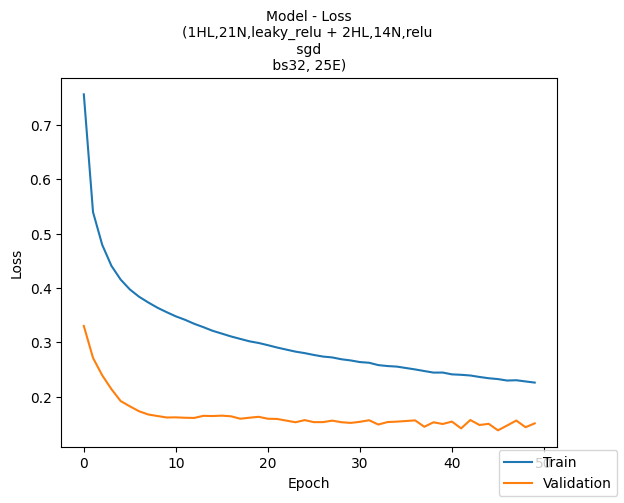

In [268]:
plot(history,'loss', model_5_config)

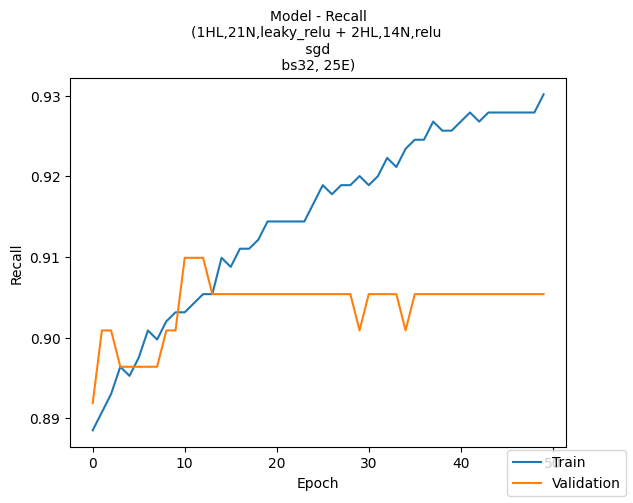

In [269]:
plot(history,'Recall', model_5_config)

In [270]:
model_5_train_perf = model_performance_classification(model_5,X_train,y_train)
model_5_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Accuracy    Recall  Precision  F1 Score
0  0.969938  0.952287   0.829431  0.879406

In [271]:
model_5_val_perf = model_performance_classification(model_5,X_val,y_val)
model_5_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Accuracy    Recall  Precision  F1 Score
0   0.96375  0.936292   0.806374  0.857731

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[4577  141]
 [  35  247]]


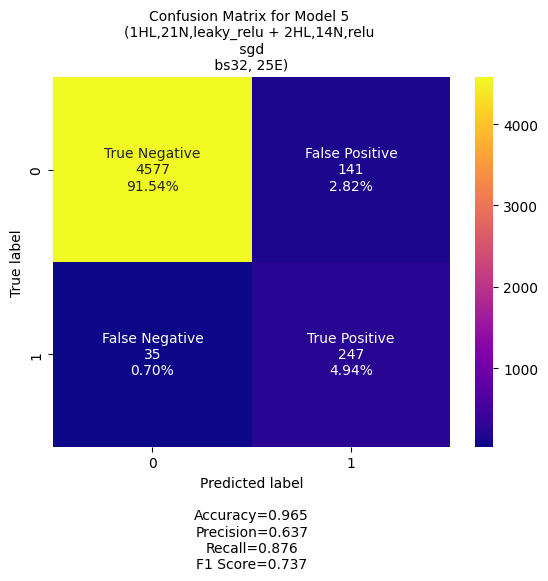

In [272]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_5.predict(X_test)
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 5 \n" + model_5_config
    )

<span style="color: blue;"> **Observation**</span>
* Adding a second hidden layer with 14 neurons and relu as activation function has reduced the gap between train and validation loss curves
* Recall has not improved and false negatives has increased in test set

## 6.9 - Model 6 - Increase Epochs

- Model Configuration
  - Increase the number of training epochs for Model 5 to allow for further learning and potential performance improvement.

In [273]:
# Define model configuration string to use in the title of graphs
model_6_config = "(1HL,21N,leaky_relu + 2HL,14N,relu \n sgd \n bs32, 50E) "

In [274]:
epochs = 50

In [275]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [276]:
# Initializing the sequential model
model_6 = Sequential()

# Add the first hidden layer with 7 neurons, ReLU activation, and input dimension matching the number of features in X_train
model_6.add(Dense(21, activation="leaky_relu",input_dim=X_train.shape[1]))

# Additional hidden layer with 14 neurons, ReLU activation
model_6.add(Dense(14, activation="relu"))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_6.add(Dense(1, activation="sigmoid"))

In [277]:
model_6.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           861 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,184 (4.62 KB)

 Trainable params: 1,184 (4.62 KB)

 Non-trainable params: 0 (0.00 B)

In [278]:
# Define SGD as the optimizer to be used
optimizer = tf.keras.optimizers.SGD()

# Recall is the chosen metric to measure
model_6.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [279]:
start = time.time()
history = model_6.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.8731 - loss: 1.0407 - val_Recall: 0.8784 - val_loss: 0.3510
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8810 - loss: 0.5451 - val_Recall: 0.8829 - val_loss: 0.2627
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8997 - loss: 0.4515 - val_Recall: 0.8874 - val_loss: 0.2234
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9043 - loss: 0.4051 - val_Recall: 0.8919 - val_loss: 0.2083
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9043 - loss: 0.3757 - val_Recall: 0.8964 - val_loss: 0.1886
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.9076 - loss: 0.3526 - val_Recall: 0.8964 - val_loss: 0.1838
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.9076 - loss: 0.3366 - val_Recall: 0.8964 - val_loss: 0.1780
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9097 - loss: 0.3248 - val_Recall: 0.9009 - val_loss: 0.1741
Epoch 9/

In [280]:
print("Time taken in seconds ",end - start)

Time taken in seconds  65.86164331436157


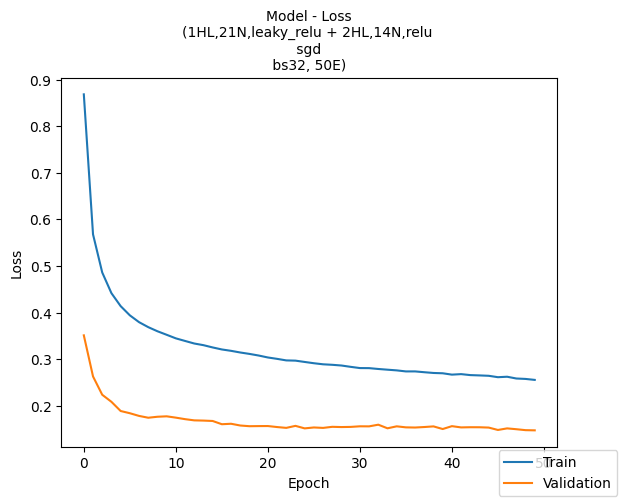

In [281]:
plot(history,'loss', model_6_config)

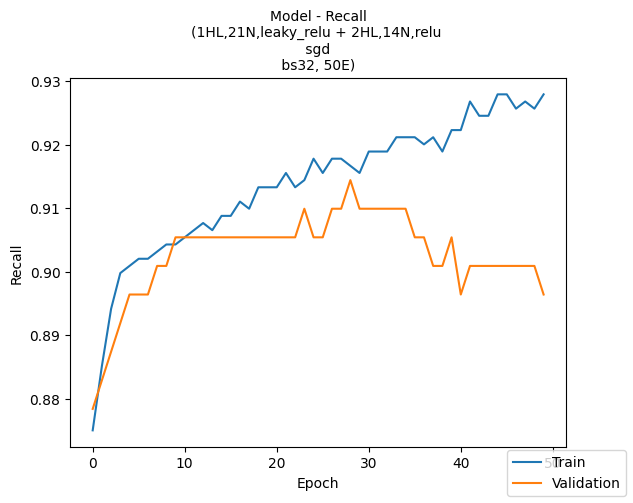

In [282]:
plot(history,'Recall', model_6_config)

In [283]:
model_6_train_perf = model_performance_classification(model_6,X_train,y_train)
model_6_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0     0.967  0.950732   0.817404  0.870267

In [284]:
model_6_val_perf = model_performance_classification(model_6,X_val,y_val)
model_6_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy    Recall  Precision  F1 Score
0   0.96475  0.932581   0.810758  0.859753

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[4572  146]
 [  37  245]]


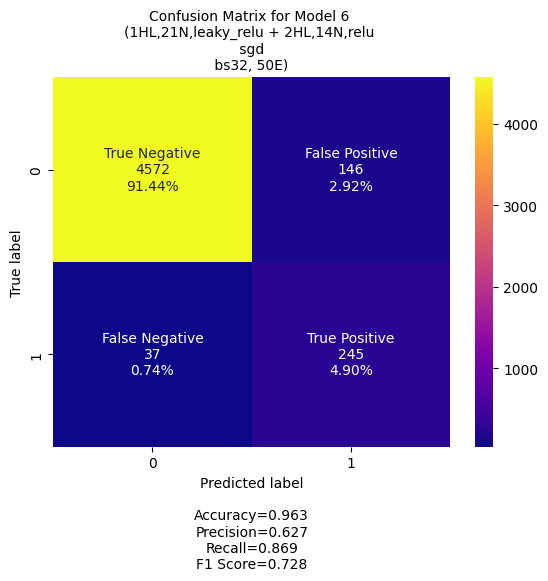

In [285]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_6.predict(X_test)
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 6 \n" + model_6_config
    )

<span style="color: blue;"> **Observation**</span>
* Increasing the epochs has slightly improved performance and reduced false negatives in test set

## 6.10 - Model 7 - Initialize weights using he_normal

- Model Configuration
  - Initialize weights using `he_normal` and observe performance.

In [286]:
# Define model configuration string to use in the title of graphs
model_7_config = "(1HL,21N,leaky_relu,he_normal + 2HL,14N,relu,he_normal \n sgd \n bs32, 50E) "

In [287]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [288]:
# Initializing the sequential model
model_7 = Sequential()

# Add the first hidden layer with 7 neurons, ReLU activation, and input dimension matching the number of features in X_train
model_7.add(Dense(21, activation="leaky_relu",kernel_initializer='he_normal', input_dim=X_train.shape[1]))

# Additional hidden layer with 14 neurons, ReLU activation
model_7.add(Dense(14, activation="relu", kernel_initializer='he_normal'))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_7.add(Dense(1, activation="sigmoid"))

In [289]:
model_7.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           861 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,184 (4.62 KB)

 Trainable params: 1,184 (4.62 KB)

 Non-trainable params: 0 (0.00 B)

In [290]:
# Define SGD as the optimizer to be used
optimizer = tf.keras.optimizers.SGD()

# Recall is the chosen metric to measure
model_7.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [291]:
start = time.time()
history = model_7.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.7985 - loss: 1.0430 - val_Recall: 0.8874 - val_loss: 0.3605
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8932 - loss: 0.5546 - val_Recall: 0.8739 - val_loss: 0.2774
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8969 - loss: 0.4596 - val_Recall: 0.8874 - val_loss: 0.2333
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.8981 - loss: 0.4041 - val_Recall: 0.8874 - val_loss: 0.2066
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.9034 - loss: 0.3694 - val_Recall: 0.8784 - val_loss: 0.1911
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - Recall: 0.9077 - loss: 0.3495 - val_Recall: 0.8829 - val_loss: 0.1816
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9096 - loss: 0.3341 - val_Recall: 0.8829 - val_loss: 0.1757
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9125 - loss: 0.3229 - val_Recall: 0.8874 - val_loss: 0.1720
Epoch 9/

In [292]:
print("Time taken in seconds ",end - start)

Time taken in seconds  67.42765974998474


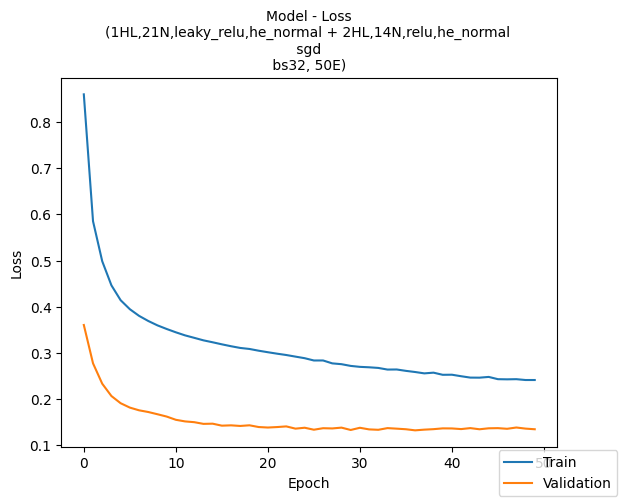

In [293]:
plot(history,'loss', model_7_config)

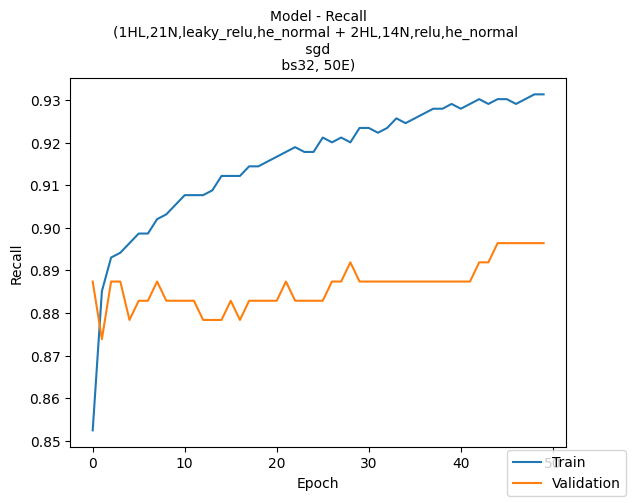

In [294]:
plot(history,'Recall', model_7_config)

In [295]:
model_7_train_perf = model_performance_classification(model_7,X_train,y_train)
model_7_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0     0.969  0.953381   0.825231  0.876768

In [296]:
model_7_val_perf = model_performance_classification(model_7,X_val,y_val)
model_7_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy    Recall  Precision  F1 Score
0    0.9645  0.932449    0.80977  0.859001

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[4551  167]
 [  38  244]]


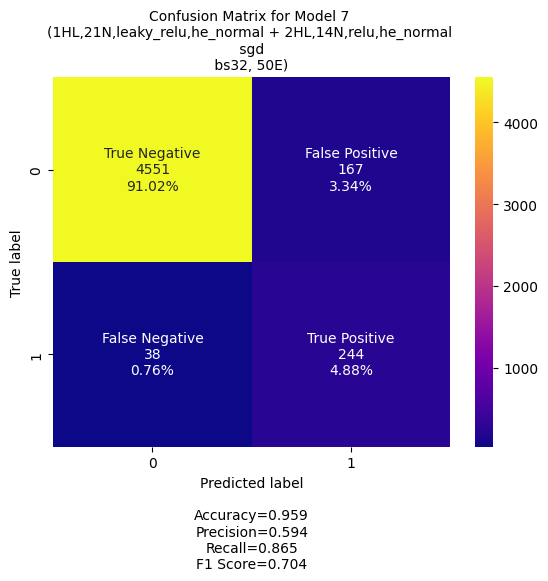

In [297]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_7.predict(X_test)
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 7 \n" + model_7_config
    )

<span style="color: blue;"> **Observation**</span>
* Initializing weights with `he_normal` for Model 7 shows marginal improvements in precision and F1-score on both training and validation sets compared to Model 6, while recall remains largely similar.
* The number of false negatives has increased slightly on the test set compared to Model 6.

## 6.11 - Model 8 - Add momentum

- Model Configuration
  - Use SGD with momentum and observe performance.

In [298]:
# Define model configuration string to use in the title of graphs
model_8_config = "(1HL,21N,leaky_relu,he_normal + 2HL,14N,relu,he_normal \n sgd,mom \n bs32, 50E) "

In [299]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [300]:
# Initializing the sequential model
model_8 = Sequential()

# Add the first hidden layer with 7 neurons, ReLU activation, and input dimension matching the number of features in X_train
model_8.add(Dense(21, activation="leaky_relu",kernel_initializer='he_normal', input_dim=X_train.shape[1]))

# Additional hidden layer with 14 neurons, ReLU activation
model_8.add(Dense(14, activation="relu", kernel_initializer='he_normal'))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_8.add(Dense(1, activation="sigmoid"))

In [301]:
model_8.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           861 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,184 (4.62 KB)

 Trainable params: 1,184 (4.62 KB)

 Non-trainable params: 0 (0.00 B)

In [302]:
# Define SGD as the optimizer to be used
optimizer = tf.keras.optimizers.SGD(momentum=0.6)

# Recall is the chosen metric to measure
model_8.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [303]:
start = time.time()
history = model_8.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - Recall: 0.8383 - loss: 0.8141 - val_Recall: 0.9054 - val_loss: 0.3150
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.8933 - loss: 0.4659 - val_Recall: 0.9099 - val_loss: 0.2832
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9004 - loss: 0.4008 - val_Recall: 0.9009 - val_loss: 0.2496
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8990 - loss: 0.3650 - val_Recall: 0.8919 - val_loss: 0.2270
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9076 - loss: 0.3406 - val_Recall: 0.8874 - val_loss: 0.2075
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9150 - loss: 0.3224 - val_Recall: 0.8964 - val_loss: 0.2035
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9193 - loss: 0.3130 - val_Recall: 0.9009 - val_loss: 0.2046
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9202 - loss: 0.3035 - val_Recall: 0.9009 - val_loss: 0.2030
Epoch 9/

In [304]:
print("Time taken in seconds ",end - start)

Time taken in seconds  67.72423529624939


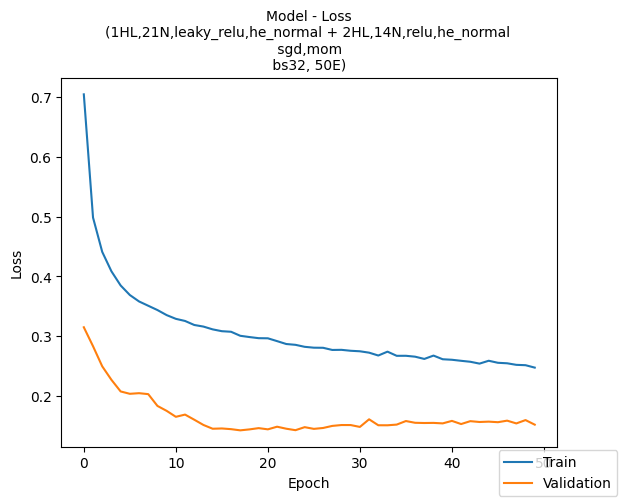

In [305]:
plot(history,'loss', model_8_config)

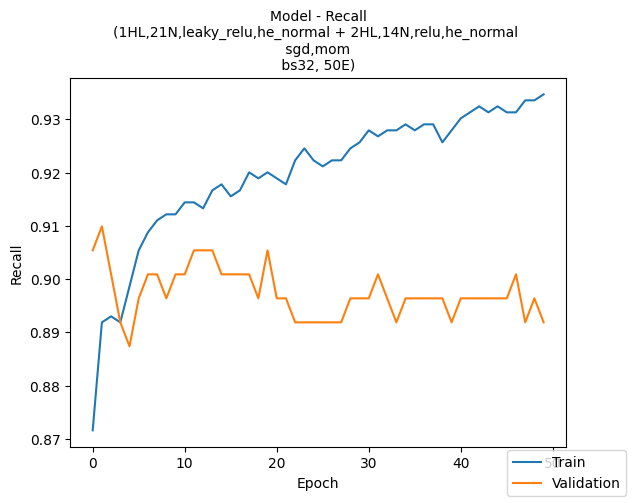

In [306]:
plot(history,'Recall', model_8_config)

In [307]:
model_8_train_perf = model_performance_classification(model_8,X_train,y_train)
model_8_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0  0.964562  0.949971   0.808011  0.863063

In [308]:
model_8_val_perf = model_performance_classification(model_8,X_val,y_val)
model_8_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy    Recall  Precision  F1 Score
0      0.96  0.927947   0.793134  0.845368

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[4533  185]
 [  41  241]]


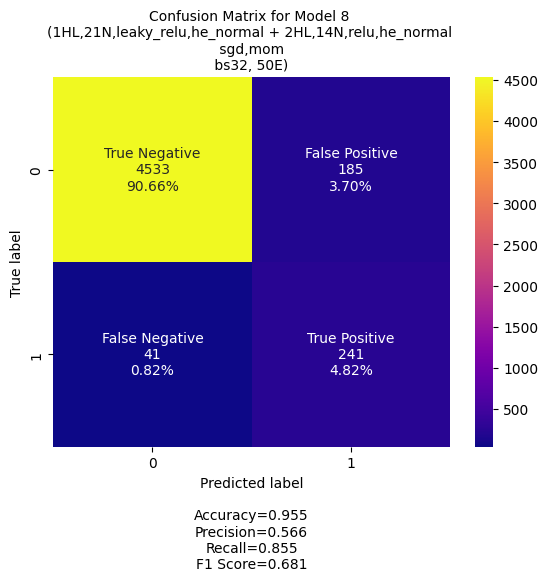

In [309]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_8.predict(X_test)
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 8 \n" + model_8_config
    )

<span style="color: blue;"> **Observation**</span>
* The training loss continues to decrease, while the validation loss shows signs of plateauing and a slight increase towards the later epochs, indicating a potential divergence and the onset of overfitting.
* The model exhibits improved recall on the test set, alongside a reduction in the number of false negatives.

## 6.12 - Model 9 - Add third hidden layer

- Model Configuration
  - Add a third hidden layer with 7 neurons and ReLU activation.

In [310]:
# Define model configuration string to use in the title of graphs
model_9_config = "(1HL,21N,leaky_relu,he_normal + 2HL,14N,relu,he_normal + 3HL,7N,relu \n sgd,mom \n bs32 + 50E) "

In [311]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [312]:
# Initializing the sequential model
model_9 = Sequential()

# Add the first hidden layer with 7 neurons, ReLU activation, and input dimension matching the number of features in X_train
model_9.add(Dense(21, activation="leaky_relu",kernel_initializer='he_normal', input_dim=X_train.shape[1]))

# Additional hidden layer with 14 neurons, ReLU activation
model_9.add(Dense(14, activation="relu", kernel_initializer='he_normal'))

# Additional hidden layer with 7 neurons, ReLU activation
model_9.add(Dense(7, activation="relu"))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_9.add(Dense(1, activation="sigmoid"))

In [313]:
model_9.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           861 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

In [314]:
# Define SGD as the optimizer to be used
optimizer = tf.keras.optimizers.SGD(momentum=0.6)

# Recall is the chosen metric to measure
model_9.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [315]:
start = time.time()
history = model_9.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.7589 - loss: 0.9291 - val_Recall: 0.8649 - val_loss: 0.2087
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8952 - loss: 0.4349 - val_Recall: 0.8874 - val_loss: 0.1818
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.9107 - loss: 0.3656 - val_Recall: 0.8964 - val_loss: 0.1838
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.9107 - loss: 0.3428 - val_Recall: 0.9009 - val_loss: 0.1856
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.9114 - loss: 0.3259 - val_Recall: 0.9054 - val_loss: 0.1749
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9165 - loss: 0.3083 - val_Recall: 0.9099 - val_loss: 0.1654
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9172 - loss: 0.3037 - val_Recall: 0.9054 - val_loss: 0.2315
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9189 - loss: 0.2981 - val_Recall: 0.9054 - val_loss: 0.1501
Epoch 9/

In [316]:
print("Time taken in seconds ",end - start)

Time taken in seconds  69.86283731460571


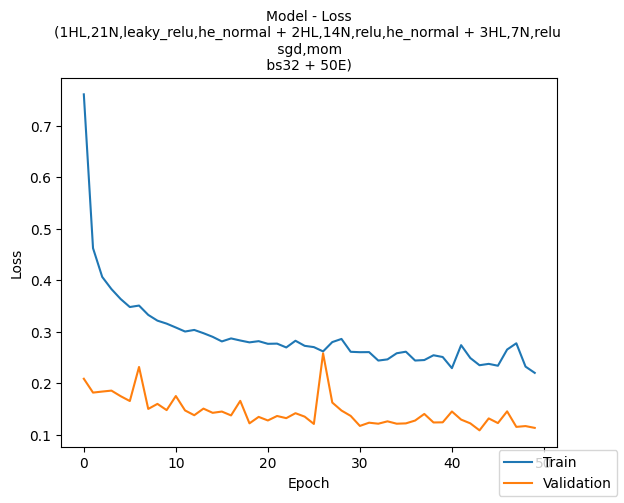

In [317]:
plot(history,'loss', model_9_config)

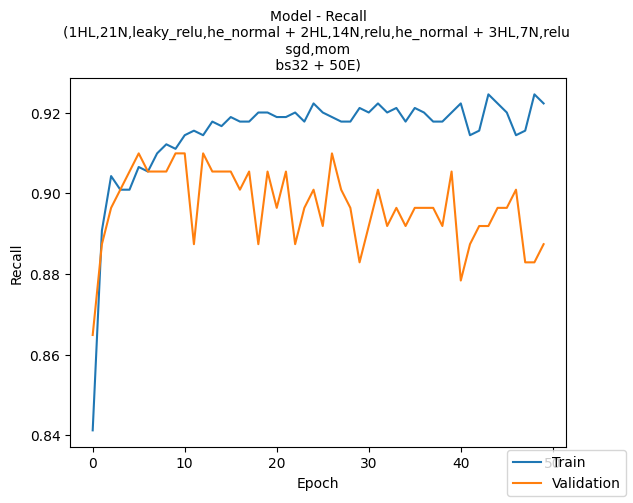

In [318]:
plot(history,'Recall', model_9_config)

In [319]:
model_9_train_perf = model_performance_classification(model_9,X_train,y_train)
model_9_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0   0.98975  0.958535   0.945344   0.95183

In [320]:
model_9_val_perf = model_performance_classification(model_9,X_val,y_val)
model_9_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy   Recall  Precision  F1 Score
0     0.988  0.94065    0.94442  0.942526

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[4677   41]
 [  37  245]]


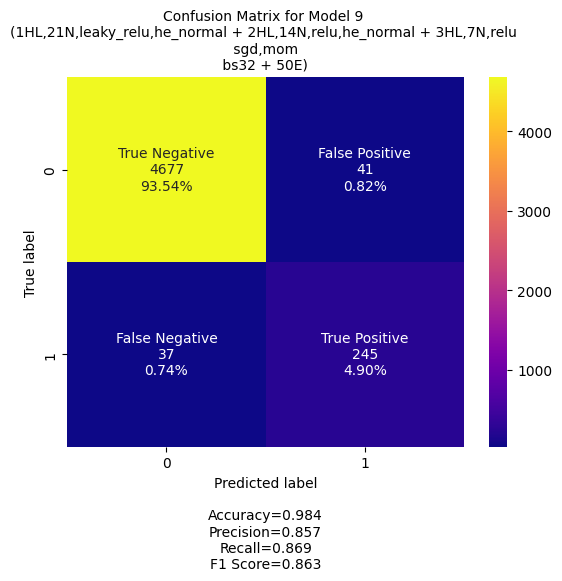

In [321]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_9.predict(X_test)
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 9 \n" + model_9_config
    )

<span style="color: blue;"> **Observation**</span>
* Adding the third layer has shown improvement in performance
* The gap between training and validation loss appears to be slightly widening, potentially indicating the beginning of overfitting.

## 6.13 - Model 10 - Add dropout layer

- Model Configuration
  - Add dropout layer to see if it addresses overfitting issue

In [322]:
# Define model configuration string to use in the title of graphs
model_10_config = "(1HL,21N,leaky_relu,he_normal + DP.4 + 2HL,14N,relu,he_normal + 3HL,7N,relu \n sgd,mom \n bs32 + 50E) "

In [323]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [324]:
# Initializing the sequential model
model_10 = Sequential()

# Add the first hidden layer with 7 neurons, ReLU activation, and input dimension matching the number of features in X_train
model_10.add(Dense(21, activation="leaky_relu",kernel_initializer='he_normal', input_dim=X_train.shape[1]))

# Drop 40%
model_10.add(Dropout(0.4))

# Additional hidden layer with 14 neurons, ReLU activation
model_10.add(Dense(14, activation="relu", kernel_initializer='he_normal'))

# Additional hidden layer with 7 neurons, ReLU activation
model_10.add(Dense(7, activation="relu"))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_10.add(Dense(1, activation="sigmoid"))

In [325]:
model_10.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           861 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

In [326]:
# Define SGD as the optimizer to be used
optimizer = tf.keras.optimizers.SGD(momentum=0.6)

# Recall is the chosen metric to measure
model_10.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [327]:
start = time.time()
history = model_10.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - Recall: 0.8047 - loss: 1.0039 - val_Recall: 0.8694 - val_loss: 0.3235
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.8516 - loss: 0.6316 - val_Recall: 0.8784 - val_loss: 0.2683
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - Recall: 0.8673 - loss: 0.5464 - val_Recall: 0.8784 - val_loss: 0.2186
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8531 - loss: 0.5312 - val_Recall: 0.8694 - val_loss: 0.2239
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8680 - loss: 0.4927 - val_Recall: 0.8919 - val_loss: 0.2199
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8679 - loss: 0.4746 - val_Recall: 0.8829 - val_loss: 0.2187
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8808 - loss: 0.4676 - val_Recall: 0.8829 - val_loss: 0.1988
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8846 - loss: 0.4464 - val_Recall: 0.8784 - val_loss: 0.1828
Epoch 9/

In [328]:
print("Time taken in seconds ",end - start)

Time taken in seconds  72.56161594390869


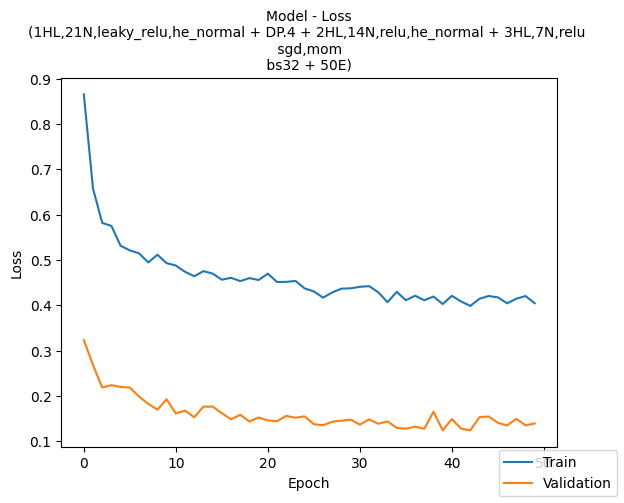

In [329]:
plot(history,'loss', model_10_config)

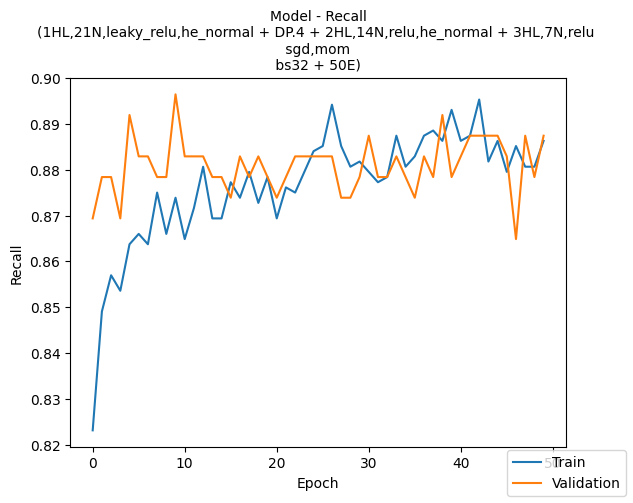

In [330]:
plot(history,'Recall', model_10_config)

In [331]:
model_10_train_perf = model_performance_classification(model_10,X_train,y_train)
model_10_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Accuracy    Recall  Precision  F1 Score
0  0.983875  0.945356   0.909142  0.926365

In [332]:
model_10_val_perf = model_performance_classification(model_10,X_val,y_val)
model_10_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Accuracy    Recall  Precision  F1 Score
0    0.9825  0.937738   0.903699  0.919925

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[4660   58]
 [  38  244]]


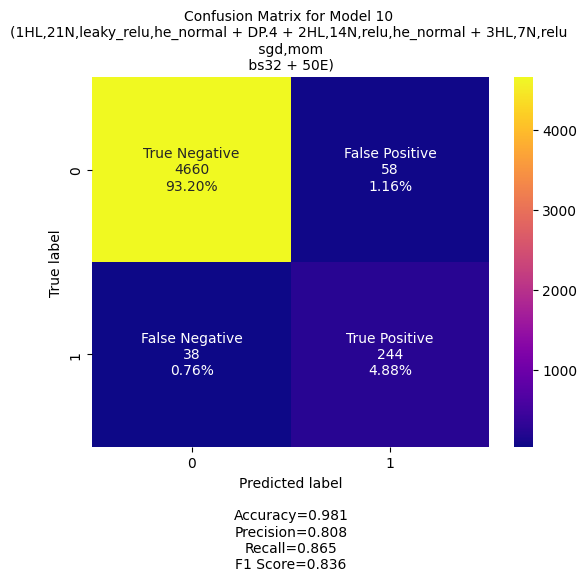

In [333]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_10.predict(X_test)
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 10 \n" + model_10_config
    )

<span style="color: blue;"> **Observation**</span>
* The introduction of the Dropout layer effectively reduced the discrepancy between the training and validation loss curves, suggesting improved generalization and reduced overfitting.
* The Recall metric on both training and validation sets remained largely consistent.
* Conversely, the number of False Negatives observed on the test set increased.

## 6.14 - Model 11 - Change the optimizer to Adam

- Model Configuration
  - Change the optimizer to Adam

In [334]:
# Define model configuration string to use in the title of graphs
model_11_config = "(1HL,21N,leaky_relu,he_normal + 2HL,14N,relu,he_normal + 3HL,7N,relu \n adam \n bs32,50E) "

In [335]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [336]:
# Initializing the sequential model
model_11 = Sequential()

# Add the first hidden layer with 7 neurons, ReLU activation, and input dimension matching the number of features in X_train
model_11.add(Dense(21, activation="leaky_relu",kernel_initializer='he_normal', input_dim=X_train.shape[1]))

# Additional hidden layer with 14 neurons, ReLU activation
model_11.add(Dense(14, activation="relu", kernel_initializer='he_normal'))

# Additional hidden layer with 7 neurons, ReLU activation
model_11.add(Dense(7, activation="relu"))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_11.add(Dense(1, activation="sigmoid"))

In [337]:
model_11.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           861 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

In [338]:
# Define Adam as the optimizer to be used
optimizer = tf.keras.optimizers.Adam()

# Recall is the chosen metric to measure
model_11.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [339]:
start = time.time()
history = model_11.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Recall: 0.6294 - loss: 1.0397 - val_Recall: 0.8649 - val_loss: 0.3898
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.8946 - loss: 0.5548 - val_Recall: 0.8694 - val_loss: 0.3109
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9054 - loss: 0.4600 - val_Recall: 0.8829 - val_loss: 0.2732
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9143 - loss: 0.4011 - val_Recall: 0.8919 - val_loss: 0.2445
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9171 - loss: 0.3640 - val_Recall: 0.9009 - val_loss: 0.2405
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9156 - loss: 0.3377 - val_Recall: 0.9054 - val_loss: 0.2101
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.9220 - loss: 0.3167 - val_Recall: 0.9099 - val_loss: 0.2173
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.9231 - loss: 0.3034 - val_Recall: 0.9099 - val_loss: 0.2208
Epoch 9/

In [340]:
print("Time taken in seconds ",end - start)

Time taken in seconds  73.58409357070923


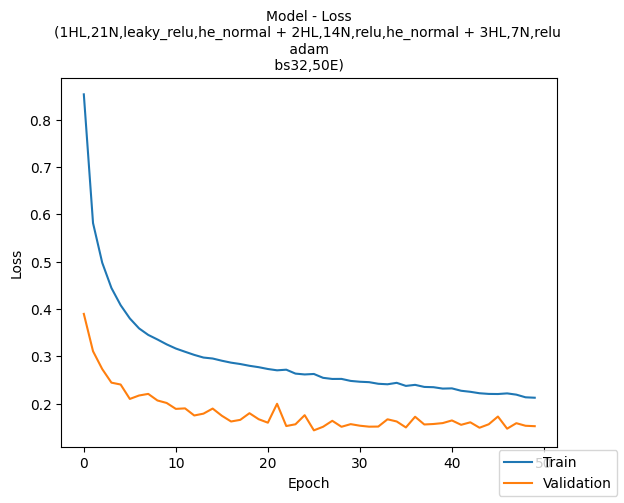

In [341]:
plot(history,'loss', model_11_config)

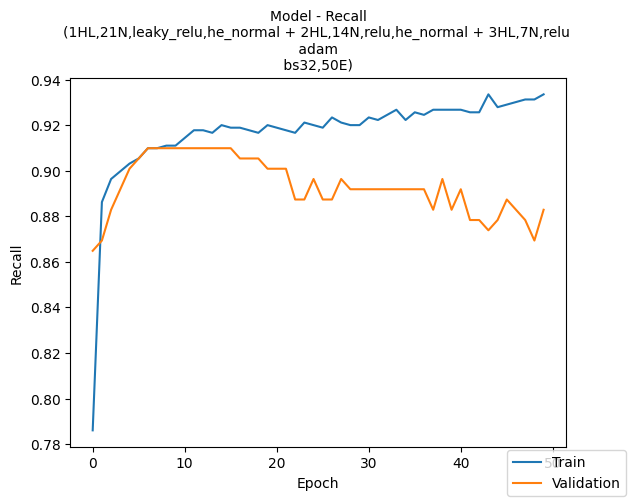

In [342]:
plot(history,'Recall', model_11_config)

In [343]:
model_11_train_perf = model_performance_classification(model_11,X_train,y_train)
model_11_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0   0.97625  0.960928   0.857047  0.901242

In [344]:
model_11_val_perf = model_performance_classification(model_11,X_val,y_val)
model_11_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy    Recall  Precision  F1 Score
0     0.968  0.927942   0.825347  0.868367

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[4600  118]
 [  37  245]]


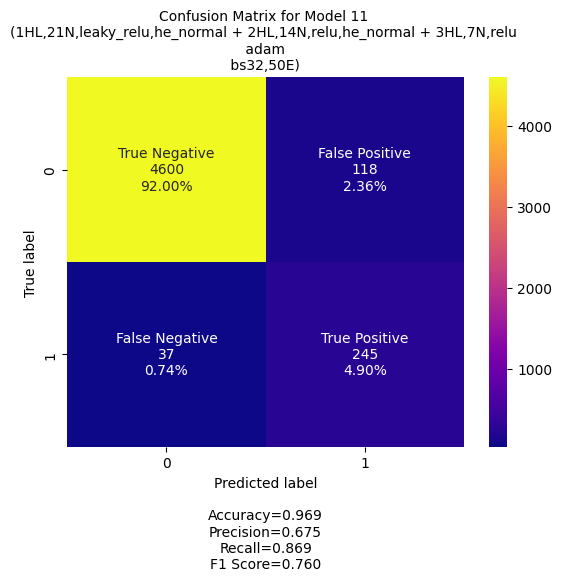

In [345]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_11.predict(X_test)
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 11 \n" + model_11_config
    )

<span style="color: blue;"> **Observation**</span>
* Using adam optimizer has shown little better recall
* However, the gap between training and validation loss appears to be widening, potentially indicating overfitting.

## 6.15 - Model 12 - Introduce Regularization (dropout)

- Model Configuration
  - Introduce regularization by adding a Dropout layer after the first hidden layer to mitigate overfitting.

In [346]:
# Define model configuration string to use in the title of graphs
model_12_config = "(1HL,21N,leaky_relu,he_normal + DR.4 + 2HL,14N,relu,he_normal + 3HL,7N,relu \n adam \n bs32,50E) "

In [347]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [348]:
# Initializing the sequential model
model_12 = Sequential()

# Add the first hidden layer with 7 neurons, ReLU activation, and input dimension matching the number of features in X_train
model_12.add(Dense(21, activation="leaky_relu",kernel_initializer='he_normal', input_dim=X_train.shape[1]))

# Dropout 40%
model_12.add(Dropout(0.4))

# Additional hidden layer with 14 neurons, ReLU activation
model_12.add(Dense(14, activation="relu", kernel_initializer='he_normal'))

# Additional hidden layer with 7 neurons, ReLU activation
model_12.add(Dense(7, activation="relu"))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_12.add(Dense(1, activation="sigmoid"))

In [349]:
model_12.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           861 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

In [350]:
# Define Adam as the optimizer to be used
optimizer = tf.keras.optimizers.Adam()

# Recall is the chosen metric to measure
model_12.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [351]:
start = time.time()
history = model_12.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Recall: 0.7456 - loss: 1.1227 - val_Recall: 0.8784 - val_loss: 0.4319
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.8303 - loss: 0.8033 - val_Recall: 0.8694 - val_loss: 0.3294
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.8652 - loss: 0.6609 - val_Recall: 0.8829 - val_loss: 0.3278
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8853 - loss: 0.5960 - val_Recall: 0.8784 - val_loss: 0.3078
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8671 - loss: 0.5818 - val_Recall: 0.8829 - val_loss: 0.2936
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8776 - loss: 0.5663 - val_Recall: 0.8739 - val_loss: 0.2571
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8669 - loss: 0.5511 - val_Recall: 0.8784 - val_loss: 0.2487
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8739 - loss: 0.5050 - val_Recall: 0.8874 - val_loss: 0.2448
Epoch 9/

In [352]:
print("Time taken in seconds ",end - start)

Time taken in seconds  80.2877733707428


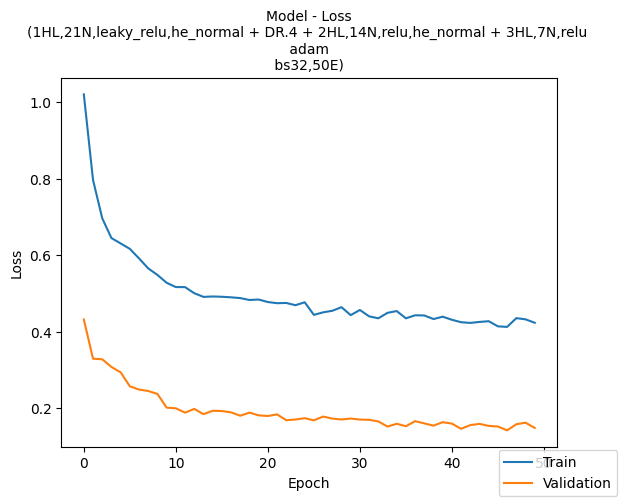

In [353]:
plot(history,'loss', model_12_config)

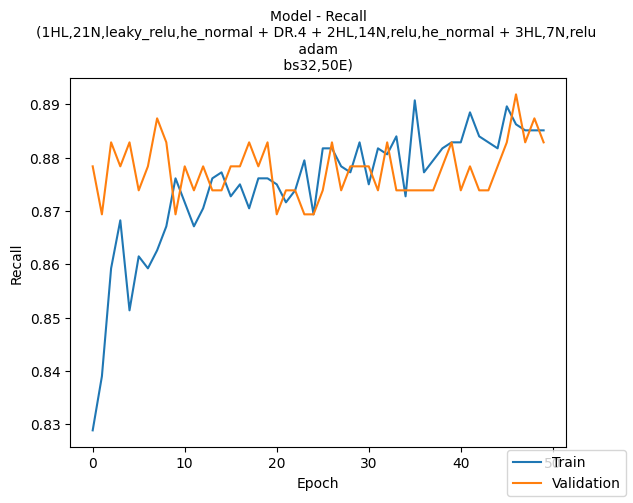

In [354]:
plot(history,'Recall', model_12_config)

In [355]:
model_12_train_perf = model_performance_classification(model_12,X_train,y_train)
model_12_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0  0.979812  0.945325   0.882392   0.91108

In [356]:
model_12_val_perf = model_performance_classification(model_12,X_val,y_val)
model_12_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy    Recall  Precision  F1 Score
0   0.98125  0.934957   0.896538  0.914722

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[4653   65]
 [  37  245]]


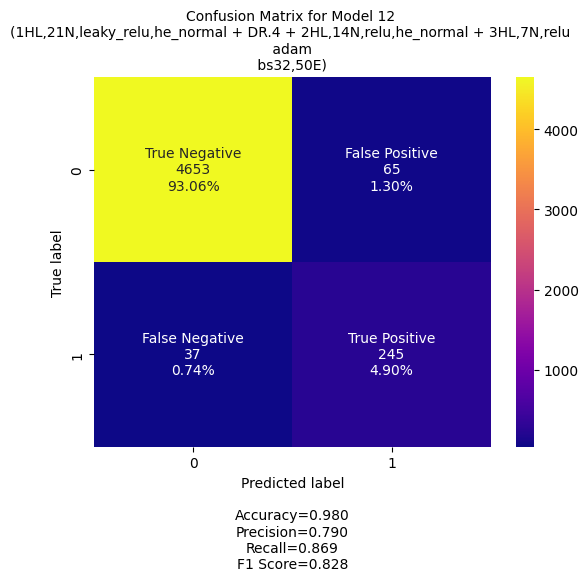

In [357]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_12.predict(X_test)
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 12 \n" + model_12_config
    )

<span style="color: blue;"> **Observation**</span>
* The introduction of the Dropout layer effectively reduced the discrepancy between the training and validation loss curves, suggesting improved generalization and reduced overfitting.
* The Recall metric on both training and validation sets remained largely consistent.
* Conversely, the number of False Negatives observed on the test set increased.

## 6.16 - Model 13 - Introduce learning_rate

- Model Configuration
  - **Adjust Learning Rate**: Modify the learning rate of the Adam optimizer to influence the step size taken during parameter updates. A carefully chosen learning rate can help the model converge more smoothly and avoid oscillations in the loss function, leading to more stable training and potentially better performance.

In [358]:
# Define model configuration string to use in the title of graphs
model_13_config = "(1HL,21N,leaky_relu,he_normal + DR.4 + 2HL,14N,relu,he_normal + 3HL,7N,relu \n adam,lr.0001 \n bs32, 50E) "

In [359]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [360]:
# Initializing the sequential model
model_13 = Sequential()

# Add the first hidden layer with 7 neurons, ReLU activation, and input dimension matching the number of features in X_train
model_13.add(Dense(21, activation="leaky_relu",kernel_initializer='he_normal', input_dim=X_train.shape[1]))

# Dropout 40%
model_13.add(Dropout(0.4))

# Additional hidden layer with 14 neurons, ReLU activation
model_13.add(Dense(14, activation="relu", kernel_initializer='he_normal'))

# Additional hidden layer with 7 neurons, ReLU activation
model_13.add(Dense(7, activation="relu"))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_13.add(Dense(1, activation="sigmoid"))

In [361]:
model_13.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           861 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

In [362]:
# Define Adam as the optimizer to be used
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Recall is the chosen metric to measure
model_13.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [363]:
start = time.time()
history = model_13.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Recall: 0.9503 - loss: 2.2143 - val_Recall: 0.7793 - val_loss: 0.8507
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.8519 - loss: 1.4082 - val_Recall: 0.8649 - val_loss: 0.6660
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.8787 - loss: 1.1929 - val_Recall: 0.8694 - val_loss: 0.5866
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.8563 - loss: 1.0781 - val_Recall: 0.8829 - val_loss: 0.5347
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8777 - loss: 0.9735 - val_Recall: 0.8784 - val_loss: 0.4877
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8704 - loss: 0.8996 - val_Recall: 0.8739 - val_loss: 0.4528
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8813 - loss: 0.8176 - val_Recall: 0.8694 - val_loss: 0.4171
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8536 - loss: 0.8229 - val_Recall: 0.8649 - val_loss: 0.3872
Epoch 9/

In [364]:
print("Time taken in seconds ",end - start)

Time taken in seconds  81.3853588104248


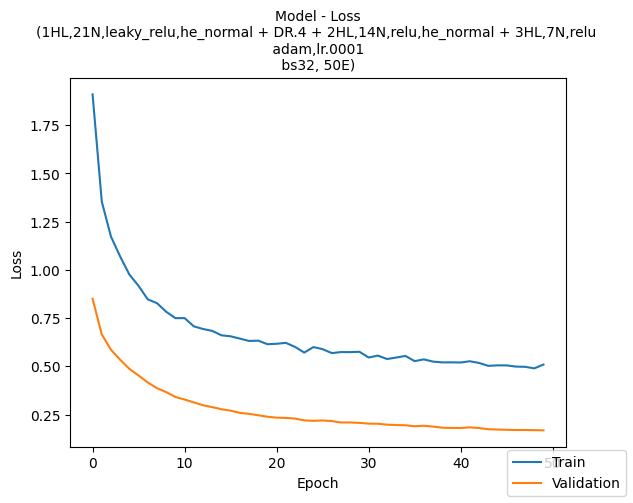

In [365]:
plot(history,'loss', model_13_config)

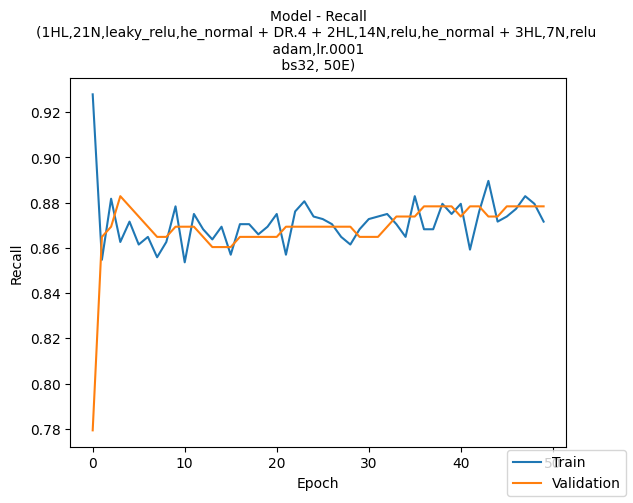

In [366]:
plot(history,'Recall', model_13_config)

In [367]:
model_13_train_perf = model_performance_classification(model_11,X_train,y_train)
model_13_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0   0.97625  0.960928   0.857047  0.901242

In [368]:
model_13_val_perf = model_performance_classification(model_13,X_val,y_val)
model_13_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy    Recall  Precision  F1 Score
0    0.9725  0.928205   0.847092  0.882667

In [369]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_13.predict(X_test)
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 13 \n" + model_13_config
    )

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[4621   97]
 [  42  240]]


<span style="color: blue;"> **Observation**</span>
* Adjusting the learning rate has helped to reduce oscillations in the loss curves, contributing to smoother convergence.
* The recall on the test set for Model 11 is approximately 73.76% (208 / (74 + 208)), which is lower compared to some previous models (e.g., Model 8 with 84.95% recall). This indicates an increase in False Negatives (74 in Model 11 vs 43 in Model 8).

## 6.17 - Model 14 - Introduce additional dropout layer

- Model Configuration
  - Add a Dropout layer after the second hidden layer to observe performance

In [370]:
# Define model configuration string to use in the title of graphs
model_14_config = "(1HL,21N,leaky_relu,he_normal + DR.4 + 2HL,14N,relu,he_normal + DR.3 + 3HL,7N,relu \n adam,,lr.0001 \n bs32, 50E) "

In [371]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [372]:
# Initializing the sequential model
model_14 = Sequential()

# Add the first hidden layer with 7 neurons, ReLU activation, and input dimension matching the number of features in X_train
model_14.add(Dense(21, activation="leaky_relu",kernel_initializer='he_normal', input_dim=X_train.shape[1]))

# Dropout 40%
model_14.add(Dropout(0.4))

# Additional hidden layer with 14 neurons, ReLU activation
model_14.add(Dense(14, activation="relu", kernel_initializer='he_normal'))

# Dropout 30%
model_14.add(Dropout(0.3))

# Additional hidden layer with 7 neurons, ReLU activation
model_14.add(Dense(7, activation="relu"))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_14.add(Dense(1, activation="sigmoid"))

In [373]:
model_14.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           861 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

In [374]:
# Define Adam as the optimizer to be used
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Recall is the chosen metric to measure
model_14.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [375]:
start = time.time()
history = model_14.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - Recall: 0.6265 - loss: 1.6751 - val_Recall: 0.7162 - val_loss: 0.7702
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - Recall: 0.6940 - loss: 1.4200 - val_Recall: 0.8198 - val_loss: 0.6728
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.7330 - loss: 1.2800 - val_Recall: 0.8514 - val_loss: 0.6215
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.7489 - loss: 1.1853 - val_Recall: 0.8784 - val_loss: 0.5827
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.7402 - loss: 1.1379 - val_Recall: 0.8784 - val_loss: 0.5500
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.7640 - loss: 1.0869 - val_Recall: 0.8829 - val_loss: 0.5265
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.7780 - loss: 1.0453 - val_Recall: 0.8964 - val_loss: 0.5074
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - Recall: 0.8043 - loss: 0.9876 - val_Recall: 0.9009 - val_loss: 0.4886
Epoch 9/

In [376]:
print("Time taken in seconds ",end - start)

Time taken in seconds  81.98619771003723


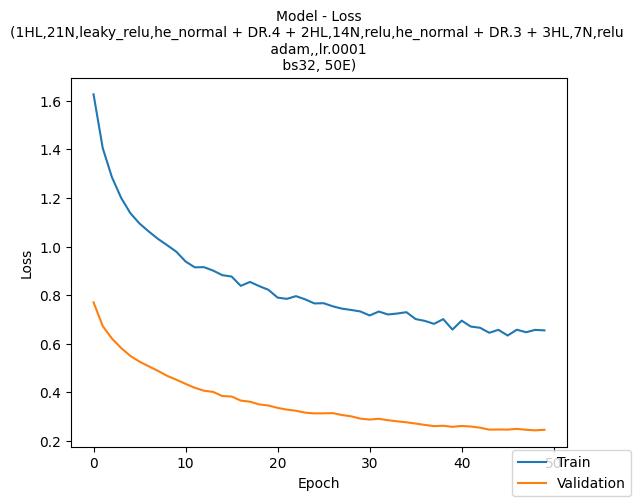

In [377]:
plot(history,'loss', model_14_config)

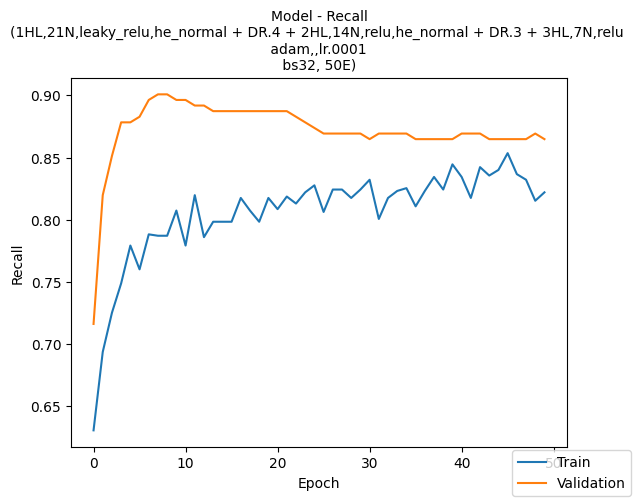

In [378]:
plot(history,'Recall', model_14_config)

In [379]:
model_14_train_perf = model_performance_classification(model_14,X_train,y_train)
model_14_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy   Recall  Precision  F1 Score
0  0.945875  0.91888   0.750108  0.808181

In [380]:
model_14_val_perf = model_performance_classification(model_14,X_val,y_val)
model_14_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Accuracy    Recall  Precision  F1 Score
0   0.94775  0.908743   0.754627  0.809669

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[4508  210]
 [  46  236]]


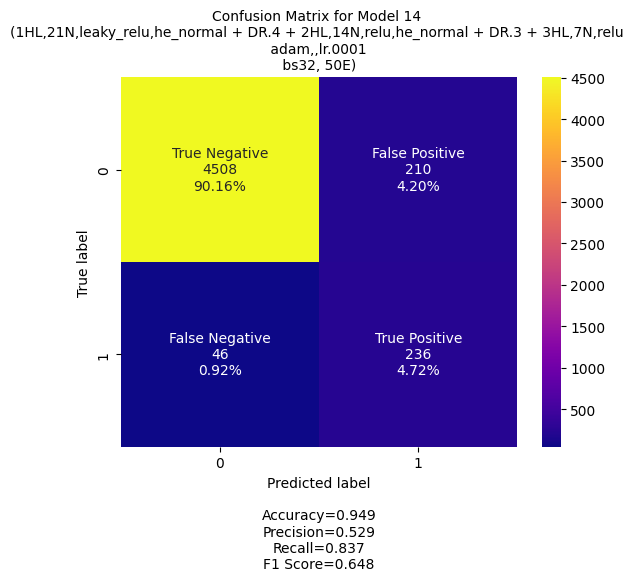

In [381]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_14.predict(X_test)
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 14 \n" + model_14_config
    )

<span style="color: blue;"> **Observation**</span>
* The introduction of the Dropout layer after the second hidden layer started to show slight increase in validtion loss.
* The Recall metric on both training and validation sets started to dip
* False Negatives observed on the test set increased.

## 6.18 - Model 15 - Add fourth hidden layer

- Model Configuration
  - Add a fourth hidden layer with 5 neurons and sigmoid activation to evaluate the impact on model performance.

In [382]:
# Define model configuration string to use in the title of graphs
model_15_config = "(1HL,21N,leaky_relu,he_normal + DR.4 + 2HL,14N,relu,he_normal + 3HL,7N,relu + 4HL,5N,sigmoid \n adam \n bs32,50E) "

In [383]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [384]:
# Initializing the sequential model
model_15 = Sequential()

# Add the first hidden layer with 7 neurons, ReLU activation, and input dimension matching the number of features in X_train
model_15.add(Dense(21, activation="leaky_relu",kernel_initializer='he_normal', input_dim=X_train.shape[1]))

# Dropout 40%
model_15.add(Dropout(0.4))

# Additional hidden layer with 14 neurons, ReLU activation
model_15.add(Dense(14, activation="relu", kernel_initializer='he_normal'))

# Additional hidden layer with 7 neurons, ReLU activation
model_15.add(Dense(7, activation="relu"))

# Additional hidden layer with 5 neurons, sigmoid activation
model_15.add(Dense(5, activation="sigmoid"))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_15.add(Dense(1, activation="sigmoid"))

In [385]:
model_15.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           861 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

In [386]:
# Define Adam as the optimizer to be used
optimizer = tf.keras.optimizers.Adam()

# Recall is the chosen metric to measure
model_15.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [387]:
start = time.time()
history = model_15.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Recall: 0.9522 - loss: 1.3048 - val_Recall: 0.8919 - val_loss: 0.5125
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8494 - loss: 0.8030 - val_Recall: 0.8829 - val_loss: 0.3863
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8578 - loss: 0.6776 - val_Recall: 0.8784 - val_loss: 0.3136
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.8757 - loss: 0.5959 - val_Recall: 0.8784 - val_loss: 0.2785
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - Recall: 0.8596 - loss: 0.5807 - val_Recall: 0.8829 - val_loss: 0.2826
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - Recall: 0.8658 - loss: 0.5413 - val_Recall: 0.8739 - val_loss: 0.2305
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - Recall: 0.8668 - loss: 0.5135 - val_Recall: 0.8739 - val_loss: 0.1996
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - Recall: 0.8559 - loss: 0.4994 - val_Recall: 0.8829 - val_loss: 0.2086
Epoch 9/

In [388]:
print("Time taken in seconds ",end - start)

Time taken in seconds  86.78437495231628


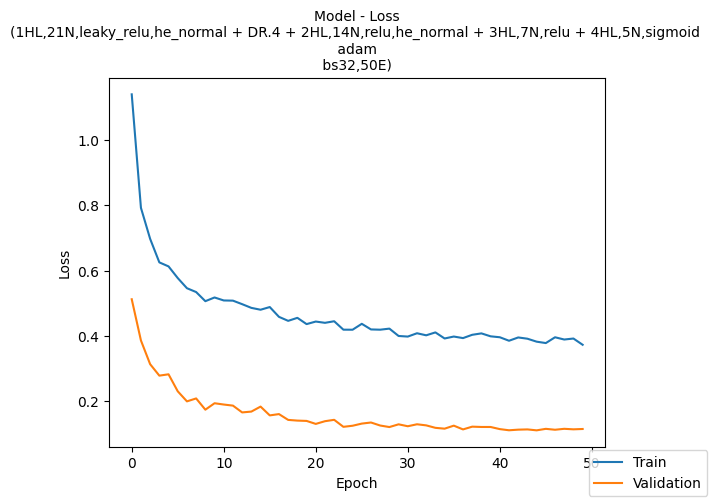

In [389]:
plot(history,'loss', model_15_config)

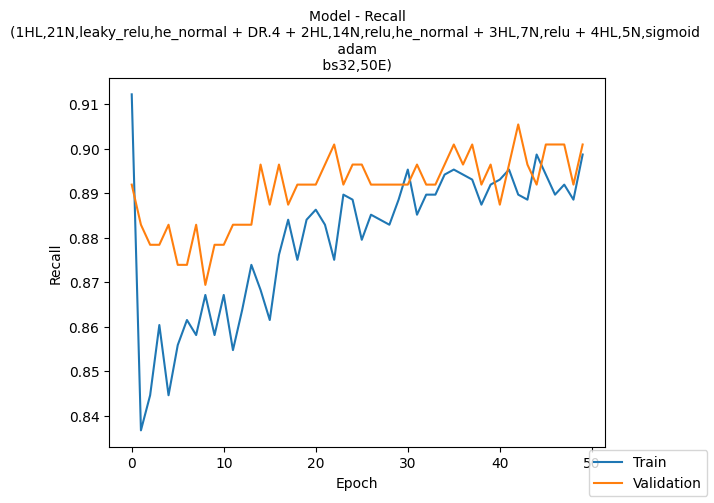

In [390]:
plot(history,'Recall', model_15_config)

In [391]:
model_15_train_perf = model_performance_classification(model_15,X_train,y_train)
model_15_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy   Recall  Precision  F1 Score
0  0.985375  0.95145   0.916344   0.93308

In [392]:
model_15_val_perf = model_performance_classification(model_15,X_val,y_val)
model_15_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy   Recall  Precision  F1 Score
0     0.987  0.94648   0.931865  0.939033

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[4679   39]
 [  36  246]]


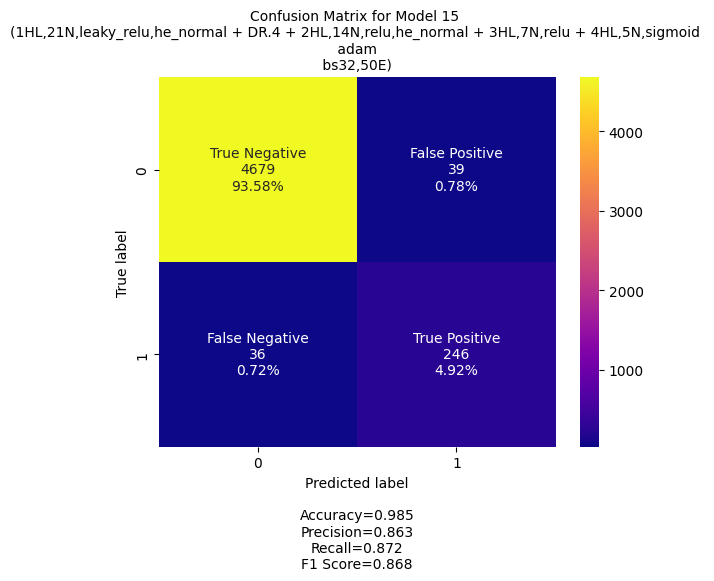

In [393]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_15.predict(X_test)
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 15 \n" + model_15_config
    )

<span style="color: blue;"> **Observation**</span>
* Adding a fourth hidden layer has helped to improve metrics and redcue false negatives

## 6.19 - Model 16 - Change activation function of the first hidden layer

- Model Configuration
  - Change the activation function of first hidden layer to sogmoid and observe the performance

In [394]:
# Define model configuration string to use in the title of graphs
model_16_config = "(1HL,21N,sigmoid + DR.4 + 2HL,14N,relu,he_normal + 3HL,7N,relu + 4HL,5N,sigmoid \n adam \n bs32,50E) "

In [395]:
# Clear the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [396]:
# Initializing the sequential model
model_16 = Sequential()

# Add the first hidden layer with 7 neurons, ReLU activation, and input dimension matching the number of features in X_train
model_16.add(Dense(21, activation="sigmoid", input_dim=X_train.shape[1]))

# Dropout 40%
model_16.add(Dropout(0.4))

# Additional hidden layer with 14 neurons, ReLU activation
model_16.add(Dense(14, activation="relu", kernel_initializer='he_normal'))

# Additional hidden layer with 7 neurons, ReLU activation
model_16.add(Dense(7, activation="relu"))

# Additional hidden layer with 5 neurons, sigmoid activation
model_16.add(Dense(5, activation="sigmoid"))

# Add the output layer with 1 neuron and sigmoid activation for binary classification probability output
model_16.add(Dense(1, activation="sigmoid"))

In [397]:
model_16.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           861 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

In [398]:
# Define Adam as the optimizer to be used
optimizer = tf.keras.optimizers.Adam()

# Recall is the chosen metric to measure
model_16.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['Recall'])

In [399]:
start = time.time()
history = model_16.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=cw_dict)
end=time.time()

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Recall: 0.1296 - loss: 1.3185 - val_Recall: 0.8649 - val_loss: 0.4586
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8435 - loss: 0.8954 - val_Recall: 0.8559 - val_loss: 0.3706
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8398 - loss: 0.7478 - val_Recall: 0.8514 - val_loss: 0.3492
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8446 - loss: 0.6862 - val_Recall: 0.8514 - val_loss: 0.3352
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.8588 - loss: 0.6381 - val_Recall: 0.8423 - val_loss: 0.3018
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - Recall: 0.8562 - loss: 0.6250 - val_Recall: 0.8559 - val_loss: 0.3010
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Recall: 0.8557 - loss: 0.6122 - val_Recall: 0.8514 - val_loss: 0.2681
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.8579 - loss: 0.5947 - val_Recall: 0.8559 - val_loss: 0.2567
Epoch 9/

In [400]:
print("Time taken in seconds ",end - start)

Time taken in seconds  86.98876309394836


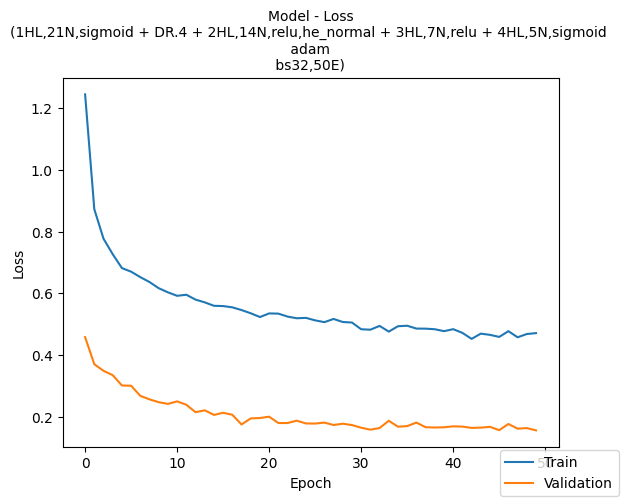

In [401]:
plot(history,'loss', model_16_config)

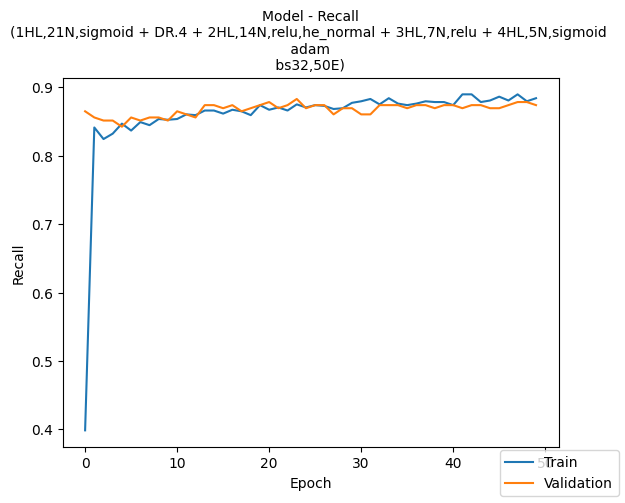

In [402]:
plot(history,'Recall', model_16_config)

In [403]:
model_16_train_perf = model_performance_classification(model_16,X_train,y_train)
model_16_train_perf

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy    Recall  Precision  F1 Score
0  0.975187  0.938107   0.858402  0.893587

In [404]:
model_16_val_perf = model_performance_classification(model_16,X_val,y_val)
model_16_val_perf

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy    Recall  Precision  F1 Score
0    0.9725  0.926085    0.84769  0.882227

In [405]:
# Evaluate Model 0 performance on the test set and visualize the confusion matrix.
y_test_pred = model_16.predict(X_test)
for i in range(len(y_test)):
    if y_test_pred[i]>0.5:
        y_test_pred[i]=1
    else:
        y_test_pred[i]=0

cm2=confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(
    cm2,
    cmap='plasma',
    title="Confusion Matrix for Model 16 \n" + model_16_config
    )

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[4613  105]
 [  41  241]]


<span style="color: blue;"> **Observation**</span>
* The recall metric on train and val is very close suggesting good generalization.
* However, overall recall is more or less in the same range as observed in few models earlier
* False negatives has increased on test data set

# 7 - Model Performance Comparison and Final Model Selection

Now, in order to select the final model, we will compare the performances of all the models for the training and test sets.

**Training Performance Comparison**

In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        model_0_train_perf.T,
        model_1_train_perf.T,
        model_2_train_perf.T,
        model_3_train_perf.T,
        model_4_train_perf.T,
        model_5_train_perf.T,
        model_6_train_perf.T

    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Model 0",
    "Model 1",
    "Model 2",
    "Model 3",
    "Model 4",
    "Model 5",
    "Model 6"
]
print("Training set performance comparison:")
models_train_comp_df

**Validation Performance Comparison**

In [ ]:
# Validation performance comparison

models_val_comp_df = pd.concat(
    [
        model_0_val_perf.T,
        model_1_val_perf.T,
        model_2_val_perf.T,
        model_3_val_perf.T,
        model_4_val_perf.T,
        model_5_val_perf.T,
        model_6_val_perf.T

    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Model 0",
    "Model 1",
    "Model 2",
    "Model 3",
    "Model 4",
    "Model 5",
    "Model 6"
]
print("Validation set performance comparison:")
models_val_comp_df

**Checking the performance of the best model on the test set**

In [ ]:
# best_model = model_0 ## Uncomment this line in case the best model is model_0
# best_model = model_1 ## Uncomment this line in case the best model is model_1
# best_model = model_2 ## Uncomment this line in case the best model is model_2
# best_model = model_3 ## Uncomment this line in case the best model is model_3
# best_model = model_4 ## Uncomment this line in case the best model is model_4
# best_model = model_5 ## Uncomment this line in case the best model is model_5
# best_model = model_6 ## Uncomment this line in case the best model is model_6

In [ ]:
# Test set performance for the best model
best_model_test_perf = model_performance_classification(best_model,X_test,y_test)
best_model_test_perf

In [ ]:
y_test_pred_best = best_model.predict(X_test)

cr_test_best_model = classification_report(y_test, y_test_pred_best>0.5) # Check the classification report of best model on test data.
print(cr_test_best_model)

# 8 - Actionable Insights and Recommendations

- Write down actionable insights here

- Write down business recommendations here